In [2]:
#Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C:\Users\annek\AppData\Local\Temp\ipykernel_1920\2446634136.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


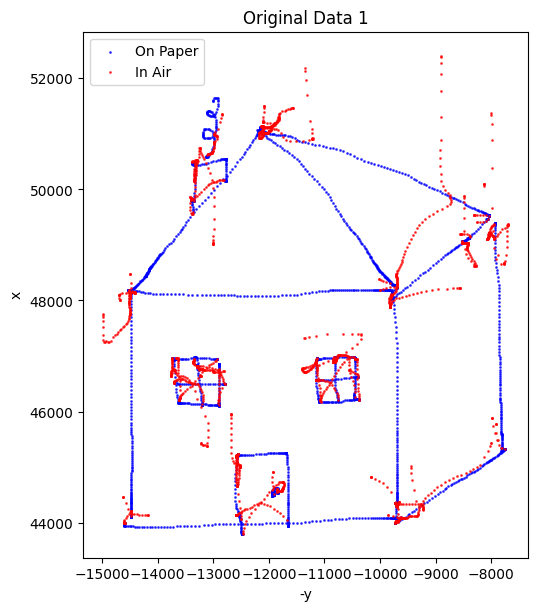

Processed data shape: (4000, 3)
Average number of data points: 4000


In [12]:
# Cell 2 (modified)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        df = df.iloc[:, [0, 1, 3]]  # Select x, y, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points

directory = 'Task2'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")

In [20]:
# Cell 3 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(3,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(3)
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy = tf.sigmoid(decoded[:, :2])
        pen_status = tf.sigmoid(decoded[:, 2])
        return tf.concat([xy, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Function to compute loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy = tf.reduce_mean(tf.keras.losses.mse(x[:, :2], x_reconstructed[:, :2]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 2], x_reconstructed[:, 2]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy + reconstruction_loss_pen, kl_loss, model.beta * kl_loss

latent_dim = 256
beta = 0.001
# beta = 0.000001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/1000:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch 1/1000: 100%|██████████| 8/8 [00:08<00:00,  1.02s/batch, Total Loss=0.78, Reconstruction Loss=0.78, KL Loss=0.000501]  


Epoch 1: Total Loss = 0.785714, Reconstruction Loss = 0.785713, KL Divergence Loss = 0.000323
MAE = 0.233418, MSE = 0.075517, NRMSE = 0.274803


Epoch 2/1000: 100%|██████████| 8/8 [00:00<00:00, 60.00batch/s, Total Loss=0.738, Reconstruction Loss=0.738, KL Loss=0.00158] 


Epoch 2: Total Loss = 0.756957, Reconstruction Loss = 0.756956, KL Divergence Loss = 0.000992
MAE = 0.233345, MSE = 0.074893, NRMSE = 0.273666


Epoch 3/1000: 100%|██████████| 8/8 [00:00<00:00, 64.25batch/s, Total Loss=0.688, Reconstruction Loss=0.688, KL Loss=0.0059] 


Epoch 3: Total Loss = 0.713670, Reconstruction Loss = 0.713667, KL Divergence Loss = 0.003550
MAE = 0.234765, MSE = 0.074562, NRMSE = 0.273061


Epoch 4/1000: 100%|██████████| 8/8 [00:00<00:00, 68.60batch/s, Total Loss=0.393, Reconstruction Loss=0.393, KL Loss=0.0265] 


Epoch 4: Total Loss = 0.544049, Reconstruction Loss = 0.544034, KL Divergence Loss = 0.015633
MAE = 0.234035, MSE = 0.074171, NRMSE = 0.272344


Epoch 5/1000: 100%|██████████| 8/8 [00:00<00:00, 59.25batch/s, Total Loss=0.1, Reconstruction Loss=0.1, KL Loss=0.0886]    

Epoch 5: Total Loss = 0.197383, Reconstruction Loss = 0.197324, KL Divergence Loss = 0.058890
MAE = 0.236751, MSE = 0.075904, NRMSE = 0.275507



Epoch 6/1000: 100%|██████████| 8/8 [00:00<00:00, 57.93batch/s, Total Loss=0.0734, Reconstruction Loss=0.0733, KL Loss=0.162]


Epoch 6: Total Loss = 0.076979, Reconstruction Loss = 0.076848, KL Divergence Loss = 0.130777
MAE = 0.237090, MSE = 0.075896, NRMSE = 0.275492


Epoch 7/1000: 100%|██████████| 8/8 [00:00<00:00, 56.67batch/s, Total Loss=0.0728, Reconstruction Loss=0.0725, KL Loss=0.229]


Epoch 7: Total Loss = 0.071285, Reconstruction Loss = 0.071084, KL Divergence Loss = 0.200664
MAE = 0.237177, MSE = 0.076066, NRMSE = 0.275800


Epoch 8/1000: 100%|██████████| 8/8 [00:00<00:00, 40.81batch/s, Total Loss=0.0596, Reconstruction Loss=0.0593, KL Loss=0.278]


Epoch 8: Total Loss = 0.067357, Reconstruction Loss = 0.067093, KL Divergence Loss = 0.264024
MAE = 0.237771, MSE = 0.076410, NRMSE = 0.276423


Epoch 9/1000: 100%|██████████| 8/8 [00:00<00:00, 56.48batch/s, Total Loss=0.0617, Reconstruction Loss=0.0614, KL Loss=0.304]


Epoch 9: Total Loss = 0.061990, Reconstruction Loss = 0.061703, KL Divergence Loss = 0.287072
MAE = 0.239949, MSE = 0.077636, NRMSE = 0.278633


Epoch 10/1000: 100%|██████████| 8/8 [00:00<00:00, 61.80batch/s, Total Loss=0.056, Reconstruction Loss=0.0557, KL Loss=0.343] 


Epoch 10: Total Loss = 0.056848, Reconstruction Loss = 0.056527, KL Divergence Loss = 0.320785
MAE = 0.240503, MSE = 0.078217, NRMSE = 0.279672


Epoch 11/1000: 100%|██████████| 8/8 [00:00<00:00, 62.21batch/s, Total Loss=0.0566, Reconstruction Loss=0.0563, KL Loss=0.369]


Epoch 11: Total Loss = 0.053812, Reconstruction Loss = 0.053450, KL Divergence Loss = 0.361137
MAE = 0.241126, MSE = 0.078761, NRMSE = 0.280644


Epoch 12/1000: 100%|██████████| 8/8 [00:00<00:00, 57.55batch/s, Total Loss=0.0504, Reconstruction Loss=0.05, KL Loss=0.408]  


Epoch 12: Total Loss = 0.051731, Reconstruction Loss = 0.051326, KL Divergence Loss = 0.405628
MAE = 0.242139, MSE = 0.079512, NRMSE = 0.281979


Epoch 13/1000: 100%|██████████| 8/8 [00:00<00:00, 61.89batch/s, Total Loss=0.0485, Reconstruction Loss=0.0481, KL Loss=0.423]


Epoch 13: Total Loss = 0.049527, Reconstruction Loss = 0.049103, KL Divergence Loss = 0.424128
MAE = 0.243520, MSE = 0.080591, NRMSE = 0.283886


Epoch 14/1000: 100%|██████████| 8/8 [00:00<00:00, 38.31batch/s, Total Loss=0.0469, Reconstruction Loss=0.0465, KL Loss=0.439]


Epoch 14: Total Loss = 0.047523, Reconstruction Loss = 0.047087, KL Divergence Loss = 0.435582
MAE = 0.245482, MSE = 0.082115, NRMSE = 0.286557


Epoch 15/1000: 100%|██████████| 8/8 [00:00<00:00, 44.34batch/s, Total Loss=0.0433, Reconstruction Loss=0.0428, KL Loss=0.472]


Epoch 15: Total Loss = 0.045456, Reconstruction Loss = 0.044997, KL Divergence Loss = 0.459092
MAE = 0.247958, MSE = 0.083989, NRMSE = 0.289808


Epoch 16/1000: 100%|██████████| 8/8 [00:00<00:00, 50.63batch/s, Total Loss=0.0425, Reconstruction Loss=0.0419, KL Loss=0.508]


Epoch 16: Total Loss = 0.043913, Reconstruction Loss = 0.043428, KL Divergence Loss = 0.485015
MAE = 0.249719, MSE = 0.085409, NRMSE = 0.292248


Epoch 17/1000: 100%|██████████| 8/8 [00:00<00:00, 56.18batch/s, Total Loss=0.0438, Reconstruction Loss=0.0433, KL Loss=0.521]


Epoch 17: Total Loss = 0.042141, Reconstruction Loss = 0.041629, KL Divergence Loss = 0.512413
MAE = 0.252780, MSE = 0.088069, NRMSE = 0.296764


Epoch 18/1000: 100%|██████████| 8/8 [00:00<00:00, 37.44batch/s, Total Loss=0.0407, Reconstruction Loss=0.0402, KL Loss=0.534]


Epoch 18: Total Loss = 0.040342, Reconstruction Loss = 0.039808, KL Divergence Loss = 0.534350
MAE = 0.255030, MSE = 0.090434, NRMSE = 0.300723


Epoch 19/1000: 100%|██████████| 8/8 [00:00<00:00, 48.59batch/s, Total Loss=0.0389, Reconstruction Loss=0.0384, KL Loss=0.559]


Epoch 19: Total Loss = 0.038846, Reconstruction Loss = 0.038287, KL Divergence Loss = 0.559276
MAE = 0.260595, MSE = 0.095259, NRMSE = 0.308641


Epoch 20/1000: 100%|██████████| 8/8 [00:00<00:00, 48.27batch/s, Total Loss=0.0343, Reconstruction Loss=0.0337, KL Loss=0.601]


Epoch 20: Total Loss = 0.036230, Reconstruction Loss = 0.035644, KL Divergence Loss = 0.586494
MAE = 0.263966, MSE = 0.098279, NRMSE = 0.313495


Epoch 21/1000: 100%|██████████| 8/8 [00:00<00:00, 47.13batch/s, Total Loss=0.0308, Reconstruction Loss=0.0302, KL Loss=0.623]


Epoch 21: Total Loss = 0.033937, Reconstruction Loss = 0.033328, KL Divergence Loss = 0.609710
MAE = 0.269389, MSE = 0.102300, NRMSE = 0.319844


Epoch 22/1000: 100%|██████████| 8/8 [00:00<00:00, 55.72batch/s, Total Loss=0.0295, Reconstruction Loss=0.0288, KL Loss=0.639]

Epoch 22: Total Loss = 0.031025, Reconstruction Loss = 0.030383, KL Divergence Loss = 0.642695


MAE = 0.274314, MSE = 0.106432, NRMSE = 0.326239


Epoch 23/1000: 100%|██████████| 8/8 [00:00<00:00, 53.97batch/s, Total Loss=0.0244, Reconstruction Loss=0.0237, KL Loss=0.713]

Epoch 23: Total Loss = 0.028062, Reconstruction Loss = 0.027373, KL Divergence Loss = 0.688606


MAE = 0.278979, MSE = 0.111298, NRMSE = 0.333614


Epoch 24/1000: 100%|██████████| 8/8 [00:00<00:00, 60.58batch/s, Total Loss=0.0199, Reconstruction Loss=0.0191, KL Loss=0.768]


Epoch 24: Total Loss = 0.023077, Reconstruction Loss = 0.022326, KL Divergence Loss = 0.750250
MAE = 0.283769, MSE = 0.115695, NRMSE = 0.340140


Epoch 25/1000: 100%|██████████| 8/8 [00:00<00:00, 37.32batch/s, Total Loss=0.0177, Reconstruction Loss=0.0168, KL Loss=0.83] 


Epoch 25: Total Loss = 0.018223, Reconstruction Loss = 0.017400, KL Divergence Loss = 0.823640
MAE = 0.289047, MSE = 0.120188, NRMSE = 0.346681


Epoch 26/1000: 100%|██████████| 8/8 [00:00<00:00, 60.88batch/s, Total Loss=0.0155, Reconstruction Loss=0.0146, KL Loss=0.905]


Epoch 26: Total Loss = 0.016081, Reconstruction Loss = 0.015195, KL Divergence Loss = 0.886873
MAE = 0.292912, MSE = 0.124181, NRMSE = 0.352393


Epoch 27/1000: 100%|██████████| 8/8 [00:00<00:00, 68.61batch/s, Total Loss=0.0146, Reconstruction Loss=0.0136, KL Loss=0.939]


Epoch 27: Total Loss = 0.014673, Reconstruction Loss = 0.013741, KL Divergence Loss = 0.931999
MAE = 0.299043, MSE = 0.129593, NRMSE = 0.359991


Epoch 28/1000: 100%|██████████| 8/8 [00:00<00:00, 65.97batch/s, Total Loss=0.0133, Reconstruction Loss=0.0123, KL Loss=0.98] 


Epoch 28: Total Loss = 0.013113, Reconstruction Loss = 0.012159, KL Divergence Loss = 0.954282
MAE = 0.303086, MSE = 0.133410, NRMSE = 0.365254


Epoch 29/1000: 100%|██████████| 8/8 [00:00<00:00, 57.63batch/s, Total Loss=0.012, Reconstruction Loss=0.0109, KL Loss=1.02]  

Epoch 29: Total Loss = 0.011489, Reconstruction Loss = 0.010482, KL Divergence Loss = 1.007066
MAE = 0.306586, MSE = 0.137265, NRMSE = 0.370493



Epoch 30/1000: 100%|██████████| 8/8 [00:00<00:00, 57.91batch/s, Total Loss=0.00832, Reconstruction Loss=0.00722, KL Loss=1.1] 

Epoch 30: Total Loss = 0.010022, Reconstruction Loss = 0.008972, KL Divergence Loss = 1.050160


MAE = 0.309028, MSE = 0.139381, NRMSE = 0.373338


Epoch 31/1000: 100%|██████████| 8/8 [00:00<00:00, 29.39batch/s, Total Loss=0.00725, Reconstruction Loss=0.00612, KL Loss=1.13]


Epoch 31: Total Loss = 0.008480, Reconstruction Loss = 0.007376, KL Divergence Loss = 1.104207
MAE = 0.311714, MSE = 0.142074, NRMSE = 0.376926


Epoch 32/1000: 100%|██████████| 8/8 [00:00<00:00, 51.18batch/s, Total Loss=0.00713, Reconstruction Loss=0.00594, KL Loss=1.2] 


Epoch 32: Total Loss = 0.007089, Reconstruction Loss = 0.005917, KL Divergence Loss = 1.171257
MAE = 0.312531, MSE = 0.143320, NRMSE = 0.378577


Epoch 33/1000: 100%|██████████| 8/8 [00:00<00:00, 46.32batch/s, Total Loss=0.00661, Reconstruction Loss=0.00535, KL Loss=1.26]


Epoch 33: Total Loss = 0.006326, Reconstruction Loss = 0.005087, KL Divergence Loss = 1.239045
MAE = 0.315883, MSE = 0.146230, NRMSE = 0.382400


Epoch 34/1000: 100%|██████████| 8/8 [00:00<00:00, 57.80batch/s, Total Loss=0.00518, Reconstruction Loss=0.00383, KL Loss=1.36]


Epoch 34: Total Loss = 0.005426, Reconstruction Loss = 0.004109, KL Divergence Loss = 1.317358
MAE = 0.315328, MSE = 0.145936, NRMSE = 0.382016


Epoch 35/1000: 100%|██████████| 8/8 [00:00<00:00, 53.31batch/s, Total Loss=0.00466, Reconstruction Loss=0.0033, KL Loss=1.36] 

Epoch 35: Total Loss = 0.004982, Reconstruction Loss = 0.003592, KL Divergence Loss = 1.389894


MAE = 0.317081, MSE = 0.147870, NRMSE = 0.384538


Epoch 36/1000: 100%|██████████| 8/8 [00:00<00:00, 48.34batch/s, Total Loss=0.00442, Reconstruction Loss=0.00294, KL Loss=1.47]


Epoch 36: Total Loss = 0.004622, Reconstruction Loss = 0.003170, KL Divergence Loss = 1.452210
MAE = 0.317628, MSE = 0.148561, NRMSE = 0.385436


Epoch 37/1000: 100%|██████████| 8/8 [00:00<00:00, 51.02batch/s, Total Loss=0.00414, Reconstruction Loss=0.00265, KL Loss=1.49]


Epoch 37: Total Loss = 0.004235, Reconstruction Loss = 0.002739, KL Divergence Loss = 1.495531
MAE = 0.317216, MSE = 0.148502, NRMSE = 0.385360


Epoch 38/1000: 100%|██████████| 8/8 [00:00<00:00, 63.04batch/s, Total Loss=0.00414, Reconstruction Loss=0.00251, KL Loss=1.63]


Epoch 38: Total Loss = 0.003951, Reconstruction Loss = 0.002413, KL Divergence Loss = 1.538514
MAE = 0.317513, MSE = 0.149030, NRMSE = 0.386045


Epoch 39/1000: 100%|██████████| 8/8 [00:00<00:00, 52.44batch/s, Total Loss=0.00406, Reconstruction Loss=0.00247, KL Loss=1.59]


Epoch 39: Total Loss = 0.003925, Reconstruction Loss = 0.002353, KL Divergence Loss = 1.572677
MAE = 0.318217, MSE = 0.149697, NRMSE = 0.386908


Epoch 40/1000: 100%|██████████| 8/8 [00:00<00:00, 57.18batch/s, Total Loss=0.00385, Reconstruction Loss=0.00224, KL Loss=1.61]

Epoch 40: Total Loss = 0.003752, Reconstruction Loss = 0.002151, KL Divergence Loss = 1.600992
MAE = 0.317954, MSE = 0.149237, NRMSE = 0.386312



Epoch 41/1000: 100%|██████████| 8/8 [00:00<00:00, 64.42batch/s, Total Loss=0.00349, Reconstruction Loss=0.00186, KL Loss=1.63]


Epoch 41: Total Loss = 0.003634, Reconstruction Loss = 0.002015, KL Divergence Loss = 1.618979
MAE = 0.318958, MSE = 0.150339, NRMSE = 0.387735


Epoch 42/1000: 100%|██████████| 8/8 [00:00<00:00, 61.38batch/s, Total Loss=0.00342, Reconstruction Loss=0.00175, KL Loss=1.67]


Epoch 42: Total Loss = 0.003437, Reconstruction Loss = 0.001805, KL Divergence Loss = 1.632105
MAE = 0.319359, MSE = 0.150092, NRMSE = 0.387417


Epoch 43/1000: 100%|██████████| 8/8 [00:00<00:00, 42.11batch/s, Total Loss=0.00317, Reconstruction Loss=0.00152, KL Loss=1.65]


Epoch 43: Total Loss = 0.003308, Reconstruction Loss = 0.001663, KL Divergence Loss = 1.645719
MAE = 0.319559, MSE = 0.151093, NRMSE = 0.388707


Epoch 44/1000: 100%|██████████| 8/8 [00:00<00:00, 63.11batch/s, Total Loss=0.00324, Reconstruction Loss=0.0016, KL Loss=1.63] 


Epoch 44: Total Loss = 0.003248, Reconstruction Loss = 0.001593, KL Divergence Loss = 1.655600
MAE = 0.319513, MSE = 0.150656, NRMSE = 0.388144


Epoch 45/1000: 100%|██████████| 8/8 [00:00<00:00, 61.38batch/s, Total Loss=0.00316, Reconstruction Loss=0.00151, KL Loss=1.65]


Epoch 45: Total Loss = 0.003164, Reconstruction Loss = 0.001497, KL Divergence Loss = 1.667041
MAE = 0.317813, MSE = 0.148919, NRMSE = 0.385901


Epoch 46/1000: 100%|██████████| 8/8 [00:00<00:00, 58.26batch/s, Total Loss=0.00314, Reconstruction Loss=0.00146, KL Loss=1.67]


Epoch 46: Total Loss = 0.003174, Reconstruction Loss = 0.001496, KL Divergence Loss = 1.677881
MAE = 0.320289, MSE = 0.151341, NRMSE = 0.389025


Epoch 47/1000: 100%|██████████| 8/8 [00:00<00:00, 59.99batch/s, Total Loss=0.00322, Reconstruction Loss=0.00149, KL Loss=1.72]


Epoch 47: Total Loss = 0.003110, Reconstruction Loss = 0.001422, KL Divergence Loss = 1.687793
MAE = 0.318788, MSE = 0.149840, NRMSE = 0.387092


Epoch 48/1000: 100%|██████████| 8/8 [00:00<00:00, 62.22batch/s, Total Loss=0.003, Reconstruction Loss=0.00131, KL Loss=1.69]  


Epoch 48: Total Loss = 0.003031, Reconstruction Loss = 0.001340, KL Divergence Loss = 1.691621
MAE = 0.319732, MSE = 0.149758, NRMSE = 0.386985


Epoch 49/1000: 100%|██████████| 8/8 [00:00<00:00, 41.30batch/s, Total Loss=0.00291, Reconstruction Loss=0.00124, KL Loss=1.67]


Epoch 49: Total Loss = 0.003014, Reconstruction Loss = 0.001324, KL Divergence Loss = 1.689880
MAE = 0.318840, MSE = 0.149630, NRMSE = 0.386821


Epoch 50/1000: 100%|██████████| 8/8 [00:00<00:00, 60.75batch/s, Total Loss=0.003, Reconstruction Loss=0.00131, KL Loss=1.69]  


Epoch 50: Total Loss = 0.002971, Reconstruction Loss = 0.001282, KL Divergence Loss = 1.688530
MAE = 0.319177, MSE = 0.149408, NRMSE = 0.386534


Epoch 51/1000: 100%|██████████| 8/8 [00:00<00:00, 59.80batch/s, Total Loss=0.00279, Reconstruction Loss=0.00111, KL Loss=1.69]

Epoch 51: Total Loss = 0.002912, Reconstruction Loss = 0.001223, KL Divergence Loss = 1.688367


MAE = 0.319521, MSE = 0.150350, NRMSE = 0.387750


Epoch 52/1000: 100%|██████████| 8/8 [00:00<00:00, 52.31batch/s, Total Loss=0.00275, Reconstruction Loss=0.00107, KL Loss=1.67]


Epoch 52: Total Loss = 0.002878, Reconstruction Loss = 0.001191, KL Divergence Loss = 1.687876
MAE = 0.319828, MSE = 0.150364, NRMSE = 0.387767


Epoch 53/1000: 100%|██████████| 8/8 [00:00<00:00, 42.71batch/s, Total Loss=0.00286, Reconstruction Loss=0.00115, KL Loss=1.71]


Epoch 53: Total Loss = 0.002880, Reconstruction Loss = 0.001193, KL Divergence Loss = 1.687703
MAE = 0.319983, MSE = 0.151034, NRMSE = 0.388631


Epoch 54/1000: 100%|██████████| 8/8 [00:00<00:00, 55.03batch/s, Total Loss=0.00291, Reconstruction Loss=0.00125, KL Loss=1.65]


Epoch 54: Total Loss = 0.002851, Reconstruction Loss = 0.001167, KL Divergence Loss = 1.683622
MAE = 0.319068, MSE = 0.150124, NRMSE = 0.387458


Epoch 55/1000: 100%|██████████| 8/8 [00:00<00:00, 50.45batch/s, Total Loss=0.00283, Reconstruction Loss=0.00118, KL Loss=1.66]


Epoch 55: Total Loss = 0.002826, Reconstruction Loss = 0.001146, KL Divergence Loss = 1.679234
MAE = 0.317641, MSE = 0.149325, NRMSE = 0.386426


Epoch 56/1000: 100%|██████████| 8/8 [00:00<00:00, 60.42batch/s, Total Loss=0.00289, Reconstruction Loss=0.00123, KL Loss=1.66]


Epoch 56: Total Loss = 0.002841, Reconstruction Loss = 0.001166, KL Divergence Loss = 1.674670
MAE = 0.318559, MSE = 0.150205, NRMSE = 0.387563


Epoch 57/1000: 100%|██████████| 8/8 [00:00<00:00, 61.38batch/s, Total Loss=0.00273, Reconstruction Loss=0.001, KL Loss=1.73]  


Epoch 57: Total Loss = 0.002831, Reconstruction Loss = 0.001157, KL Divergence Loss = 1.673705
MAE = 0.318909, MSE = 0.150042, NRMSE = 0.387352


Epoch 58/1000: 100%|██████████| 8/8 [00:00<00:00, 55.19batch/s, Total Loss=0.00271, Reconstruction Loss=0.00102, KL Loss=1.69]


Epoch 58: Total Loss = 0.002722, Reconstruction Loss = 0.001052, KL Divergence Loss = 1.669584
MAE = 0.319644, MSE = 0.150508, NRMSE = 0.387954


Epoch 59/1000: 100%|██████████| 8/8 [00:00<00:00, 60.53batch/s, Total Loss=0.00268, Reconstruction Loss=0.00104, KL Loss=1.64]


Epoch 59: Total Loss = 0.002745, Reconstruction Loss = 0.001081, KL Divergence Loss = 1.663184
MAE = 0.317339, MSE = 0.148547, NRMSE = 0.385418


Epoch 60/1000: 100%|██████████| 8/8 [00:00<00:00, 40.58batch/s, Total Loss=0.00293, Reconstruction Loss=0.0013, KL Loss=1.63]  


Epoch 60: Total Loss = 0.002777, Reconstruction Loss = 0.001117, KL Divergence Loss = 1.659814
MAE = 0.317878, MSE = 0.148865, NRMSE = 0.385830


Epoch 61/1000: 100%|██████████| 8/8 [00:00<00:00, 37.70batch/s, Total Loss=0.00271, Reconstruction Loss=0.00109, KL Loss=1.62] 


Epoch 61: Total Loss = 0.002680, Reconstruction Loss = 0.001028, KL Divergence Loss = 1.651724
MAE = 0.318624, MSE = 0.149267, NRMSE = 0.386351


Epoch 62/1000: 100%|██████████| 8/8 [00:00<00:00, 64.63batch/s, Total Loss=0.00256, Reconstruction Loss=0.000963, KL Loss=1.6] 


Epoch 62: Total Loss = 0.002618, Reconstruction Loss = 0.000978, KL Divergence Loss = 1.640694
MAE = 0.317853, MSE = 0.149042, NRMSE = 0.386060


Epoch 63/1000: 100%|██████████| 8/8 [00:00<00:00, 64.04batch/s, Total Loss=0.00252, Reconstruction Loss=0.000931, KL Loss=1.59]


Epoch 63: Total Loss = 0.002625, Reconstruction Loss = 0.000994, KL Divergence Loss = 1.631062
MAE = 0.317182, MSE = 0.148382, NRMSE = 0.385203


Epoch 64/1000: 100%|██████████| 8/8 [00:00<00:00, 57.79batch/s, Total Loss=0.00263, Reconstruction Loss=0.000977, KL Loss=1.65]

Epoch 64: Total Loss = 0.002748, Reconstruction Loss = 0.001126, KL Divergence Loss = 1.622738


MAE = 0.317120, MSE = 0.148866, NRMSE = 0.385831


Epoch 65/1000: 100%|██████████| 8/8 [00:00<00:00, 54.15batch/s, Total Loss=0.0027, Reconstruction Loss=0.0011, KL Loss=1.6]    


Epoch 65: Total Loss = 0.002676, Reconstruction Loss = 0.001066, KL Divergence Loss = 1.610011
MAE = 0.316280, MSE = 0.147803, NRMSE = 0.384451


Epoch 66/1000: 100%|██████████| 8/8 [00:00<00:00, 50.61batch/s, Total Loss=0.00265, Reconstruction Loss=0.00102, KL Loss=1.63] 


Epoch 66: Total Loss = 0.002627, Reconstruction Loss = 0.001027, KL Divergence Loss = 1.600259
MAE = 0.317414, MSE = 0.148259, NRMSE = 0.385044


Epoch 67/1000: 100%|██████████| 8/8 [00:00<00:00, 39.61batch/s, Total Loss=0.00272, Reconstruction Loss=0.00114, KL Loss=1.58] 


Epoch 67: Total Loss = 0.002766, Reconstruction Loss = 0.001177, KL Divergence Loss = 1.589445
MAE = 0.315322, MSE = 0.147618, NRMSE = 0.384211


Epoch 68/1000: 100%|██████████| 8/8 [00:00<00:00, 61.25batch/s, Total Loss=0.00271, Reconstruction Loss=0.00124, KL Loss=1.47] 


Epoch 68: Total Loss = 0.002647, Reconstruction Loss = 0.001073, KL Divergence Loss = 1.573902
MAE = 0.317695, MSE = 0.148550, NRMSE = 0.385422


Epoch 69/1000: 100%|██████████| 8/8 [00:00<00:00, 58.98batch/s, Total Loss=0.00248, Reconstruction Loss=0.000848, KL Loss=1.63]


Epoch 69: Total Loss = 0.002588, Reconstruction Loss = 0.001021, KL Divergence Loss = 1.567594
MAE = 0.316427, MSE = 0.147540, NRMSE = 0.384110


Epoch 70/1000: 100%|██████████| 8/8 [00:00<00:00, 58.49batch/s, Total Loss=0.00247, Reconstruction Loss=0.000914, KL Loss=1.56]

Epoch 70: Total Loss = 0.002511, Reconstruction Loss = 0.000949, KL Divergence Loss = 1.561706


MAE = 0.317906, MSE = 0.149474, NRMSE = 0.386619


Epoch 71/1000: 100%|██████████| 8/8 [00:00<00:00, 62.79batch/s, Total Loss=0.00249, Reconstruction Loss=0.000985, KL Loss=1.5] 


Epoch 71: Total Loss = 0.002503, Reconstruction Loss = 0.000947, KL Divergence Loss = 1.555855
MAE = 0.316886, MSE = 0.148537, NRMSE = 0.385406


Epoch 72/1000: 100%|██████████| 8/8 [00:00<00:00, 59.25batch/s, Total Loss=0.00252, Reconstruction Loss=0.00105, KL Loss=1.47] 

Epoch 72: Total Loss = 0.002504, Reconstruction Loss = 0.000955, KL Divergence Loss = 1.549042


MAE = 0.316379, MSE = 0.148777, NRMSE = 0.385716


Epoch 73/1000: 100%|██████████| 8/8 [00:00<00:00, 33.45batch/s, Total Loss=0.0026, Reconstruction Loss=0.00105, KL Loss=1.55]  


Epoch 73: Total Loss = 0.002523, Reconstruction Loss = 0.000977, KL Divergence Loss = 1.545401
MAE = 0.316902, MSE = 0.147720, NRMSE = 0.384344


Epoch 74/1000: 100%|██████████| 8/8 [00:00<00:00, 51.06batch/s, Total Loss=0.00247, Reconstruction Loss=0.000946, KL Loss=1.52]


Epoch 74: Total Loss = 0.002492, Reconstruction Loss = 0.000956, KL Divergence Loss = 1.536606
MAE = 0.317813, MSE = 0.148442, NRMSE = 0.385282


Epoch 75/1000: 100%|██████████| 8/8 [00:00<00:00, 53.46batch/s, Total Loss=0.00249, Reconstruction Loss=0.000933, KL Loss=1.56]

Epoch 75: Total Loss = 0.002479, Reconstruction Loss = 0.000951, KL Divergence Loss = 1.528130


MAE = 0.315601, MSE = 0.147091, NRMSE = 0.383524


Epoch 76/1000: 100%|██████████| 8/8 [00:00<00:00, 49.51batch/s, Total Loss=0.00256, Reconstruction Loss=0.00104, KL Loss=1.52] 


Epoch 76: Total Loss = 0.002474, Reconstruction Loss = 0.000956, KL Divergence Loss = 1.517825
MAE = 0.317350, MSE = 0.148643, NRMSE = 0.385542


Epoch 77/1000: 100%|██████████| 8/8 [00:00<00:00, 49.48batch/s, Total Loss=0.00227, Reconstruction Loss=0.00078, KL Loss=1.49] 

Epoch 77: Total Loss = 0.002449, Reconstruction Loss = 0.000939, KL Divergence Loss = 1.510227


MAE = 0.315625, MSE = 0.147368, NRMSE = 0.383885


Epoch 78/1000: 100%|██████████| 8/8 [00:00<00:00, 43.12batch/s, Total Loss=0.00233, Reconstruction Loss=0.000866, KL Loss=1.46]


Epoch 78: Total Loss = 0.002409, Reconstruction Loss = 0.000905, KL Divergence Loss = 1.504017
MAE = 0.316036, MSE = 0.146839, NRMSE = 0.383196


Epoch 79/1000: 100%|██████████| 8/8 [00:00<00:00, 49.18batch/s, Total Loss=0.00239, Reconstruction Loss=0.000879, KL Loss=1.52]


Epoch 79: Total Loss = 0.002405, Reconstruction Loss = 0.000905, KL Divergence Loss = 1.499601
MAE = 0.317207, MSE = 0.148285, NRMSE = 0.385078


Epoch 80/1000: 100%|██████████| 8/8 [00:00<00:00, 49.71batch/s, Total Loss=0.00235, Reconstruction Loss=0.000872, KL Loss=1.48]

Epoch 80: Total Loss = 0.002325, Reconstruction Loss = 0.000830, KL Divergence Loss = 1.495106


MAE = 0.315565, MSE = 0.147572, NRMSE = 0.384152


Epoch 81/1000: 100%|██████████| 8/8 [00:00<00:00, 63.39batch/s, Total Loss=0.00232, Reconstruction Loss=0.000834, KL Loss=1.49]


Epoch 81: Total Loss = 0.002351, Reconstruction Loss = 0.000860, KL Divergence Loss = 1.491729
MAE = 0.315373, MSE = 0.146466, NRMSE = 0.382709


Epoch 82/1000: 100%|██████████| 8/8 [00:00<00:00, 49.62batch/s, Total Loss=0.00235, Reconstruction Loss=0.000876, KL Loss=1.47]


Epoch 82: Total Loss = 0.002370, Reconstruction Loss = 0.000887, KL Divergence Loss = 1.483127
MAE = 0.318019, MSE = 0.148919, NRMSE = 0.385900


Epoch 83/1000: 100%|██████████| 8/8 [00:00<00:00, 48.53batch/s, Total Loss=0.00241, Reconstruction Loss=0.000941, KL Loss=1.47]


Epoch 83: Total Loss = 0.002372, Reconstruction Loss = 0.000897, KL Divergence Loss = 1.474454
MAE = 0.315949, MSE = 0.147114, NRMSE = 0.383555


Epoch 84/1000: 100%|██████████| 8/8 [00:00<00:00, 32.05batch/s, Total Loss=0.00237, Reconstruction Loss=0.00093, KL Loss=1.44] 


Epoch 84: Total Loss = 0.002371, Reconstruction Loss = 0.000905, KL Divergence Loss = 1.465818
MAE = 0.316212, MSE = 0.146946, NRMSE = 0.383335


Epoch 85/1000: 100%|██████████| 8/8 [00:00<00:00, 41.69batch/s, Total Loss=0.00236, Reconstruction Loss=0.00087, KL Loss=1.49] 


Epoch 85: Total Loss = 0.002459, Reconstruction Loss = 0.000997, KL Divergence Loss = 1.461199
MAE = 0.315415, MSE = 0.146720, NRMSE = 0.383041


Epoch 86/1000: 100%|██████████| 8/8 [00:00<00:00, 57.74batch/s, Total Loss=0.00232, Reconstruction Loss=0.000873, KL Loss=1.45]

Epoch 86: Total Loss = 0.002389, Reconstruction Loss = 0.000938, KL Divergence Loss = 1.451826
MAE = 0.315883, MSE = 0.147565, NRMSE = 0.384142



Epoch 87/1000: 100%|██████████| 8/8 [00:00<00:00, 49.50batch/s, Total Loss=0.00237, Reconstruction Loss=0.000956, KL Loss=1.41]


Epoch 87: Total Loss = 0.002382, Reconstruction Loss = 0.000938, KL Divergence Loss = 1.444495
MAE = 0.315807, MSE = 0.147084, NRMSE = 0.383515


Epoch 88/1000: 100%|██████████| 8/8 [00:00<00:00, 53.07batch/s, Total Loss=0.00224, Reconstruction Loss=0.000772, KL Loss=1.47]


Epoch 88: Total Loss = 0.002264, Reconstruction Loss = 0.000824, KL Divergence Loss = 1.440001
MAE = 0.315465, MSE = 0.146627, NRMSE = 0.382919


Epoch 89/1000: 100%|██████████| 8/8 [00:00<00:00, 48.57batch/s, Total Loss=0.00222, Reconstruction Loss=0.000786, KL Loss=1.44]

Epoch 89: Total Loss = 0.002276, Reconstruction Loss = 0.000843, KL Divergence Loss = 1.432935


MAE = 0.316119, MSE = 0.146998, NRMSE = 0.383404


Epoch 90/1000: 100%|██████████| 8/8 [00:00<00:00, 40.90batch/s, Total Loss=0.00231, Reconstruction Loss=0.000872, KL Loss=1.44]


Epoch 90: Total Loss = 0.002270, Reconstruction Loss = 0.000844, KL Divergence Loss = 1.426836
MAE = 0.314933, MSE = 0.146648, NRMSE = 0.382947


Epoch 91/1000: 100%|██████████| 8/8 [00:00<00:00, 46.52batch/s, Total Loss=0.00226, Reconstruction Loss=0.000827, KL Loss=1.43]


Epoch 91: Total Loss = 0.002247, Reconstruction Loss = 0.000825, KL Divergence Loss = 1.422071
MAE = 0.315281, MSE = 0.146779, NRMSE = 0.383117


Epoch 92/1000: 100%|██████████| 8/8 [00:00<00:00, 50.01batch/s, Total Loss=0.00218, Reconstruction Loss=0.000807, KL Loss=1.37]

Epoch 92: Total Loss = 0.002206, Reconstruction Loss = 0.000789, KL Divergence Loss = 1.417514


MAE = 0.315668, MSE = 0.146569, NRMSE = 0.382844


Epoch 93/1000: 100%|██████████| 8/8 [00:00<00:00, 41.45batch/s, Total Loss=0.00225, Reconstruction Loss=0.000825, KL Loss=1.43]


Epoch 93: Total Loss = 0.002214, Reconstruction Loss = 0.000801, KL Divergence Loss = 1.413221
MAE = 0.315401, MSE = 0.146829, NRMSE = 0.383183


Epoch 94/1000: 100%|██████████| 8/8 [00:00<00:00, 41.53batch/s, Total Loss=0.0021, Reconstruction Loss=0.000683, KL Loss=1.42] 


Epoch 94: Total Loss = 0.002176, Reconstruction Loss = 0.000767, KL Divergence Loss = 1.408909
MAE = 0.316383, MSE = 0.147714, NRMSE = 0.384335


Epoch 95/1000: 100%|██████████| 8/8 [00:00<00:00, 42.79batch/s, Total Loss=0.00231, Reconstruction Loss=0.000929, KL Loss=1.38]


Epoch 95: Total Loss = 0.002180, Reconstruction Loss = 0.000778, KL Divergence Loss = 1.402278
MAE = 0.315185, MSE = 0.146321, NRMSE = 0.382519


Epoch 96/1000: 100%|██████████| 8/8 [00:00<00:00, 42.97batch/s, Total Loss=0.00224, Reconstruction Loss=0.000857, KL Loss=1.38]


Epoch 96: Total Loss = 0.002195, Reconstruction Loss = 0.000801, KL Divergence Loss = 1.394335
MAE = 0.315974, MSE = 0.146937, NRMSE = 0.383324


Epoch 97/1000: 100%|██████████| 8/8 [00:00<00:00, 34.47batch/s, Total Loss=0.00233, Reconstruction Loss=0.00096, KL Loss=1.37] 


Epoch 97: Total Loss = 0.002287, Reconstruction Loss = 0.000896, KL Divergence Loss = 1.390863
MAE = 0.316255, MSE = 0.146873, NRMSE = 0.383240


Epoch 98/1000: 100%|██████████| 8/8 [00:00<00:00, 48.31batch/s, Total Loss=0.00214, Reconstruction Loss=0.000751, KL Loss=1.39]


Epoch 98: Total Loss = 0.002189, Reconstruction Loss = 0.000796, KL Divergence Loss = 1.393556
MAE = 0.314676, MSE = 0.146590, NRMSE = 0.382871


Epoch 99/1000: 100%|██████████| 8/8 [00:00<00:00, 45.63batch/s, Total Loss=0.00229, Reconstruction Loss=0.000915, KL Loss=1.38]


Epoch 99: Total Loss = 0.002187, Reconstruction Loss = 0.000795, KL Divergence Loss = 1.391493
MAE = 0.314654, MSE = 0.146181, NRMSE = 0.382336


Epoch 100/1000: 100%|██████████| 8/8 [00:00<00:00, 50.84batch/s, Total Loss=0.00221, Reconstruction Loss=0.000815, KL Loss=1.4] 


Epoch 100: Total Loss = 0.002231, Reconstruction Loss = 0.000847, KL Divergence Loss = 1.384269
MAE = 0.314390, MSE = 0.145798, NRMSE = 0.381835


Epoch 101/1000: 100%|██████████| 8/8 [00:00<00:00, 41.28batch/s, Total Loss=0.00227, Reconstruction Loss=0.000924, KL Loss=1.35]


Epoch 101: Total Loss = 0.002210, Reconstruction Loss = 0.000837, KL Divergence Loss = 1.372685
MAE = 0.314271, MSE = 0.146071, NRMSE = 0.382193


Epoch 102/1000: 100%|██████████| 8/8 [00:00<00:00, 48.85batch/s, Total Loss=0.00218, Reconstruction Loss=0.000837, KL Loss=1.35]


Epoch 102: Total Loss = 0.002156, Reconstruction Loss = 0.000793, KL Divergence Loss = 1.363175
MAE = 0.316601, MSE = 0.147501, NRMSE = 0.384059


Epoch 103/1000: 100%|██████████| 8/8 [00:00<00:00, 35.08batch/s, Total Loss=0.00202, Reconstruction Loss=0.00066, KL Loss=1.35] 


Epoch 103: Total Loss = 0.002146, Reconstruction Loss = 0.000790, KL Divergence Loss = 1.355988
MAE = 0.313787, MSE = 0.145601, NRMSE = 0.381577


Epoch 104/1000: 100%|██████████| 8/8 [00:00<00:00, 46.51batch/s, Total Loss=0.00224, Reconstruction Loss=0.00085, KL Loss=1.39] 


Epoch 104: Total Loss = 0.002158, Reconstruction Loss = 0.000808, KL Divergence Loss = 1.349259
MAE = 0.315114, MSE = 0.146431, NRMSE = 0.382663


Epoch 105/1000: 100%|██████████| 8/8 [00:00<00:00, 44.61batch/s, Total Loss=0.00213, Reconstruction Loss=0.000796, KL Loss=1.33]


Epoch 105: Total Loss = 0.002091, Reconstruction Loss = 0.000749, KL Divergence Loss = 1.342408
MAE = 0.313516, MSE = 0.145054, NRMSE = 0.380859


Epoch 106/1000: 100%|██████████| 8/8 [00:00<00:00, 51.03batch/s, Total Loss=0.00214, Reconstruction Loss=0.000803, KL Loss=1.34]

Epoch 106: Total Loss = 0.002105, Reconstruction Loss = 0.000765, KL Divergence Loss = 1.339862


MAE = 0.314066, MSE = 0.145685, NRMSE = 0.381687


Epoch 107/1000: 100%|██████████| 8/8 [00:00<00:00, 49.89batch/s, Total Loss=0.00209, Reconstruction Loss=0.000791, KL Loss=1.3] 


Epoch 107: Total Loss = 0.002119, Reconstruction Loss = 0.000784, KL Divergence Loss = 1.335186
MAE = 0.313892, MSE = 0.145125, NRMSE = 0.380953


Epoch 108/1000: 100%|██████████| 8/8 [00:00<00:00, 49.22batch/s, Total Loss=0.00215, Reconstruction Loss=0.000829, KL Loss=1.32]

Epoch 108: Total Loss = 0.002075, Reconstruction Loss = 0.000743, KL Divergence Loss = 1.332224


MAE = 0.312803, MSE = 0.144786, NRMSE = 0.380507


Epoch 109/1000: 100%|██████████| 8/8 [00:00<00:00, 49.38batch/s, Total Loss=0.00204, Reconstruction Loss=0.000679, KL Loss=1.36]


Epoch 109: Total Loss = 0.002071, Reconstruction Loss = 0.000740, KL Divergence Loss = 1.330518
MAE = 0.313907, MSE = 0.145530, NRMSE = 0.381485


Epoch 110/1000: 100%|██████████| 8/8 [00:00<00:00, 50.11batch/s, Total Loss=0.00209, Reconstruction Loss=0.000779, KL Loss=1.31]


Epoch 110: Total Loss = 0.002040, Reconstruction Loss = 0.000717, KL Divergence Loss = 1.323203
MAE = 0.313782, MSE = 0.145019, NRMSE = 0.380813


Epoch 111/1000: 100%|██████████| 8/8 [00:00<00:00, 50.31batch/s, Total Loss=0.00208, Reconstruction Loss=0.000793, KL Loss=1.28]


Epoch 111: Total Loss = 0.002071, Reconstruction Loss = 0.000755, KL Divergence Loss = 1.316205
MAE = 0.313563, MSE = 0.144817, NRMSE = 0.380549


Epoch 112/1000: 100%|██████████| 8/8 [00:00<00:00, 49.08batch/s, Total Loss=0.00196, Reconstruction Loss=0.000644, KL Loss=1.31]


Epoch 112: Total Loss = 0.001993, Reconstruction Loss = 0.000681, KL Divergence Loss = 1.311637
MAE = 0.314011, MSE = 0.144847, NRMSE = 0.380587


Epoch 113/1000: 100%|██████████| 8/8 [00:00<00:00, 36.75batch/s, Total Loss=0.00203, Reconstruction Loss=0.000727, KL Loss=1.3] 


Epoch 113: Total Loss = 0.002024, Reconstruction Loss = 0.000720, KL Divergence Loss = 1.303645
MAE = 0.313780, MSE = 0.144938, NRMSE = 0.380707


Epoch 114/1000: 100%|██████████| 8/8 [00:00<00:00, 44.53batch/s, Total Loss=0.00208, Reconstruction Loss=0.000774, KL Loss=1.31]


Epoch 114: Total Loss = 0.002068, Reconstruction Loss = 0.000770, KL Divergence Loss = 1.298012
MAE = 0.311728, MSE = 0.143606, NRMSE = 0.378954


Epoch 115/1000: 100%|██████████| 8/8 [00:00<00:00, 45.24batch/s, Total Loss=0.00209, Reconstruction Loss=0.00078, KL Loss=1.31] 


Epoch 115: Total Loss = 0.002097, Reconstruction Loss = 0.000805, KL Divergence Loss = 1.292146
MAE = 0.312213, MSE = 0.144391, NRMSE = 0.379988


Epoch 116/1000: 100%|██████████| 8/8 [00:00<00:00, 48.50batch/s, Total Loss=0.00195, Reconstruction Loss=0.000669, KL Loss=1.28]


Epoch 116: Total Loss = 0.002105, Reconstruction Loss = 0.000819, KL Divergence Loss = 1.285609
MAE = 0.312695, MSE = 0.144229, NRMSE = 0.379775


Epoch 117/1000: 100%|██████████| 8/8 [00:00<00:00, 53.78batch/s, Total Loss=0.00206, Reconstruction Loss=0.000778, KL Loss=1.28]

Epoch 117: Total Loss = 0.002017, Reconstruction Loss = 0.000735, KL Divergence Loss = 1.281897


MAE = 0.313327, MSE = 0.144368, NRMSE = 0.379958


Epoch 118/1000: 100%|██████████| 8/8 [00:00<00:00, 46.98batch/s, Total Loss=0.00202, Reconstruction Loss=0.000756, KL Loss=1.27]


Epoch 118: Total Loss = 0.002061, Reconstruction Loss = 0.000786, KL Divergence Loss = 1.274747
MAE = 0.312290, MSE = 0.144042, NRMSE = 0.379529


Epoch 119/1000: 100%|██████████| 8/8 [00:00<00:00, 46.73batch/s, Total Loss=0.00203, Reconstruction Loss=0.00079, KL Loss=1.24] 


Epoch 119: Total Loss = 0.002019, Reconstruction Loss = 0.000749, KL Divergence Loss = 1.269848
MAE = 0.312185, MSE = 0.143723, NRMSE = 0.379109


Epoch 120/1000: 100%|██████████| 8/8 [00:00<00:00, 49.10batch/s, Total Loss=0.00204, Reconstruction Loss=0.000774, KL Loss=1.27]


Epoch 120: Total Loss = 0.002036, Reconstruction Loss = 0.000767, KL Divergence Loss = 1.269087
MAE = 0.312995, MSE = 0.143975, NRMSE = 0.379441


Epoch 121/1000: 100%|██████████| 8/8 [00:00<00:00, 49.07batch/s, Total Loss=0.00198, Reconstruction Loss=0.000735, KL Loss=1.24]


Epoch 121: Total Loss = 0.002021, Reconstruction Loss = 0.000754, KL Divergence Loss = 1.267040
MAE = 0.312284, MSE = 0.144311, NRMSE = 0.379883


Epoch 122/1000: 100%|██████████| 8/8 [00:00<00:00, 46.48batch/s, Total Loss=0.00188, Reconstruction Loss=0.000614, KL Loss=1.27]


Epoch 122: Total Loss = 0.001976, Reconstruction Loss = 0.000713, KL Divergence Loss = 1.262411
MAE = 0.313624, MSE = 0.144904, NRMSE = 0.380663


Epoch 123/1000: 100%|██████████| 8/8 [00:00<00:00, 38.75batch/s, Total Loss=0.00201, Reconstruction Loss=0.000742, KL Loss=1.26]


Epoch 123: Total Loss = 0.001964, Reconstruction Loss = 0.000708, KL Divergence Loss = 1.256371
MAE = 0.311827, MSE = 0.143364, NRMSE = 0.378634


Epoch 124/1000: 100%|██████████| 8/8 [00:00<00:00, 37.82batch/s, Total Loss=0.00193, Reconstruction Loss=0.000688, KL Loss=1.24]


Epoch 124: Total Loss = 0.001979, Reconstruction Loss = 0.000728, KL Divergence Loss = 1.250733
MAE = 0.311920, MSE = 0.143527, NRMSE = 0.378849


Epoch 125/1000: 100%|██████████| 8/8 [00:00<00:00, 50.02batch/s, Total Loss=0.00199, Reconstruction Loss=0.000721, KL Loss=1.27]

Epoch 125: Total Loss = 0.001946, Reconstruction Loss = 0.000699, KL Divergence Loss = 1.247269


MAE = 0.312158, MSE = 0.143376, NRMSE = 0.378650


Epoch 126/1000: 100%|██████████| 8/8 [00:00<00:00, 43.97batch/s, Total Loss=0.00197, Reconstruction Loss=0.00074, KL Loss=1.23] 


Epoch 126: Total Loss = 0.002005, Reconstruction Loss = 0.000764, KL Divergence Loss = 1.241821
MAE = 0.312534, MSE = 0.143570, NRMSE = 0.378906


Epoch 127/1000: 100%|██████████| 8/8 [00:00<00:00, 51.47batch/s, Total Loss=0.00189, Reconstruction Loss=0.000651, KL Loss=1.24]


Epoch 127: Total Loss = 0.001968, Reconstruction Loss = 0.000731, KL Divergence Loss = 1.237114
MAE = 0.313687, MSE = 0.144629, NRMSE = 0.380301


Epoch 128/1000: 100%|██████████| 8/8 [00:00<00:00, 48.03batch/s, Total Loss=0.0019, Reconstruction Loss=0.000681, KL Loss=1.22] 


Epoch 128: Total Loss = 0.002020, Reconstruction Loss = 0.000790, KL Divergence Loss = 1.230408
MAE = 0.310943, MSE = 0.142498, NRMSE = 0.377489


Epoch 129/1000: 100%|██████████| 8/8 [00:00<00:00, 27.57batch/s, Total Loss=0.00189, Reconstruction Loss=0.000657, KL Loss=1.24]


Epoch 129: Total Loss = 0.001956, Reconstruction Loss = 0.000732, KL Divergence Loss = 1.224007
MAE = 0.311508, MSE = 0.143229, NRMSE = 0.378455


Epoch 130/1000: 100%|██████████| 8/8 [00:00<00:00, 41.40batch/s, Total Loss=0.00195, Reconstruction Loss=0.00072, KL Loss=1.23] 


Epoch 130: Total Loss = 0.001978, Reconstruction Loss = 0.000761, KL Divergence Loss = 1.217288
MAE = 0.310433, MSE = 0.142317, NRMSE = 0.377249


Epoch 131/1000: 100%|██████████| 8/8 [00:00<00:00, 46.36batch/s, Total Loss=0.00188, Reconstruction Loss=0.000651, KL Loss=1.23]


Epoch 131: Total Loss = 0.001899, Reconstruction Loss = 0.000685, KL Divergence Loss = 1.214236
MAE = 0.310777, MSE = 0.142127, NRMSE = 0.376998


Epoch 132/1000: 100%|██████████| 8/8 [00:00<00:00, 50.21batch/s, Total Loss=0.00194, Reconstruction Loss=0.000725, KL Loss=1.22]


Epoch 132: Total Loss = 0.001874, Reconstruction Loss = 0.000662, KL Divergence Loss = 1.212406
MAE = 0.309543, MSE = 0.141747, NRMSE = 0.376492


Epoch 133/1000: 100%|██████████| 8/8 [00:00<00:00, 45.14batch/s, Total Loss=0.00196, Reconstruction Loss=0.000758, KL Loss=1.2] 


Epoch 133: Total Loss = 0.001900, Reconstruction Loss = 0.000692, KL Divergence Loss = 1.208623
MAE = 0.311355, MSE = 0.142731, NRMSE = 0.377798


Epoch 134/1000: 100%|██████████| 8/8 [00:00<00:00, 34.24batch/s, Total Loss=0.00196, Reconstruction Loss=0.000774, KL Loss=1.19]


Epoch 134: Total Loss = 0.001943, Reconstruction Loss = 0.000739, KL Divergence Loss = 1.204433
MAE = 0.312295, MSE = 0.143447, NRMSE = 0.378743


Epoch 135/1000: 100%|██████████| 8/8 [00:00<00:00, 47.11batch/s, Total Loss=0.00191, Reconstruction Loss=0.000708, KL Loss=1.2] 

Epoch 135: Total Loss = 0.001899, Reconstruction Loss = 0.000698, KL Divergence Loss = 1.201373


MAE = 0.309673, MSE = 0.142010, NRMSE = 0.376841


Epoch 136/1000: 100%|██████████| 8/8 [00:00<00:00, 48.88batch/s, Total Loss=0.00182, Reconstruction Loss=0.000602, KL Loss=1.21]


Epoch 136: Total Loss = 0.001878, Reconstruction Loss = 0.000679, KL Divergence Loss = 1.198935
MAE = 0.311344, MSE = 0.142775, NRMSE = 0.377855


Epoch 137/1000: 100%|██████████| 8/8 [00:00<00:00, 51.33batch/s, Total Loss=0.00184, Reconstruction Loss=0.000623, KL Loss=1.22]


Epoch 137: Total Loss = 0.001866, Reconstruction Loss = 0.000668, KL Divergence Loss = 1.198103
MAE = 0.309963, MSE = 0.141791, NRMSE = 0.376552


Epoch 138/1000: 100%|██████████| 8/8 [00:00<00:00, 41.81batch/s, Total Loss=0.00187, Reconstruction Loss=0.000675, KL Loss=1.19]


Epoch 138: Total Loss = 0.001853, Reconstruction Loss = 0.000662, KL Divergence Loss = 1.191298
MAE = 0.310382, MSE = 0.142273, NRMSE = 0.377190


Epoch 139/1000: 100%|██████████| 8/8 [00:00<00:00, 48.82batch/s, Total Loss=0.00174, Reconstruction Loss=0.00056, KL Loss=1.18] 


Epoch 139: Total Loss = 0.001873, Reconstruction Loss = 0.000689, KL Divergence Loss = 1.184838
MAE = 0.310610, MSE = 0.142041, NRMSE = 0.376884


Epoch 140/1000: 100%|██████████| 8/8 [00:00<00:00, 43.74batch/s, Total Loss=0.00182, Reconstruction Loss=0.000625, KL Loss=1.19]


Epoch 140: Total Loss = 0.001860, Reconstruction Loss = 0.000682, KL Divergence Loss = 1.178407
MAE = 0.309729, MSE = 0.141688, NRMSE = 0.376415


Epoch 141/1000: 100%|██████████| 8/8 [00:00<00:00, 47.20batch/s, Total Loss=0.00177, Reconstruction Loss=0.000577, KL Loss=1.2] 


Epoch 141: Total Loss = 0.001860, Reconstruction Loss = 0.000690, KL Divergence Loss = 1.170593
MAE = 0.310014, MSE = 0.142120, NRMSE = 0.376988


Epoch 142/1000: 100%|██████████| 8/8 [00:00<00:00, 31.40batch/s, Total Loss=0.00187, Reconstruction Loss=0.000722, KL Loss=1.15]


Epoch 142: Total Loss = 0.001895, Reconstruction Loss = 0.000732, KL Divergence Loss = 1.163150
MAE = 0.309984, MSE = 0.141255, NRMSE = 0.375839


Epoch 143/1000: 100%|██████████| 8/8 [00:00<00:00, 47.97batch/s, Total Loss=0.00192, Reconstruction Loss=0.000766, KL Loss=1.15]


Epoch 143: Total Loss = 0.001912, Reconstruction Loss = 0.000752, KL Divergence Loss = 1.159701
MAE = 0.309165, MSE = 0.140458, NRMSE = 0.374778


Epoch 144/1000: 100%|██████████| 8/8 [00:00<00:00, 47.06batch/s, Total Loss=0.00192, Reconstruction Loss=0.00076, KL Loss=1.16] 


Epoch 144: Total Loss = 0.001932, Reconstruction Loss = 0.000770, KL Divergence Loss = 1.162690
MAE = 0.310386, MSE = 0.142407, NRMSE = 0.377368


Epoch 145/1000: 100%|██████████| 8/8 [00:00<00:00, 52.66batch/s, Total Loss=0.00189, Reconstruction Loss=0.000716, KL Loss=1.18]

Epoch 145: Total Loss = 0.001883, Reconstruction Loss = 0.000719, KL Divergence Loss = 1.164077


MAE = 0.310281, MSE = 0.142592, NRMSE = 0.377613


Epoch 146/1000: 100%|██████████| 8/8 [00:00<00:00, 45.09batch/s, Total Loss=0.00191, Reconstruction Loss=0.000744, KL Loss=1.17]


Epoch 146: Total Loss = 0.001954, Reconstruction Loss = 0.000789, KL Divergence Loss = 1.165511
MAE = 0.308388, MSE = 0.140623, NRMSE = 0.374997


Epoch 147/1000: 100%|██████████| 8/8 [00:00<00:00, 47.64batch/s, Total Loss=0.00181, Reconstruction Loss=0.000629, KL Loss=1.18]


Epoch 147: Total Loss = 0.001847, Reconstruction Loss = 0.000686, KL Divergence Loss = 1.160626
MAE = 0.309950, MSE = 0.141541, NRMSE = 0.376220


Epoch 148/1000: 100%|██████████| 8/8 [00:00<00:00, 49.96batch/s, Total Loss=0.00179, Reconstruction Loss=0.000629, KL Loss=1.16]


Epoch 148: Total Loss = 0.001831, Reconstruction Loss = 0.000675, KL Divergence Loss = 1.156033
MAE = 0.310621, MSE = 0.142022, NRMSE = 0.376858


Epoch 149/1000: 100%|██████████| 8/8 [00:00<00:00, 24.28batch/s, Total Loss=0.00179, Reconstruction Loss=0.000642, KL Loss=1.15]


Epoch 149: Total Loss = 0.001835, Reconstruction Loss = 0.000683, KL Divergence Loss = 1.152152
MAE = 0.309674, MSE = 0.141083, NRMSE = 0.375611


Epoch 150/1000: 100%|██████████| 8/8 [00:00<00:00, 47.27batch/s, Total Loss=0.00189, Reconstruction Loss=0.000791, KL Loss=1.1] 


Epoch 150: Total Loss = 0.001864, Reconstruction Loss = 0.000719, KL Divergence Loss = 1.144327
MAE = 0.309514, MSE = 0.141081, NRMSE = 0.375608


Epoch 151/1000: 100%|██████████| 8/8 [00:00<00:00, 46.80batch/s, Total Loss=0.00175, Reconstruction Loss=0.000608, KL Loss=1.15]


Epoch 151: Total Loss = 0.001822, Reconstruction Loss = 0.000682, KL Divergence Loss = 1.139742
MAE = 0.309180, MSE = 0.141310, NRMSE = 0.375913


Epoch 152/1000: 100%|██████████| 8/8 [00:00<00:00, 49.42batch/s, Total Loss=0.00192, Reconstruction Loss=0.000774, KL Loss=1.14]

Epoch 152: Total Loss = 0.001811, Reconstruction Loss = 0.000675, KL Divergence Loss = 1.135335
MAE = 0.308923, MSE = 0.140526, NRMSE = 0.374868



Epoch 153/1000: 100%|██████████| 8/8 [00:00<00:00, 48.77batch/s, Total Loss=0.00182, Reconstruction Loss=0.000685, KL Loss=1.13]


Epoch 153: Total Loss = 0.001826, Reconstruction Loss = 0.000697, KL Divergence Loss = 1.128918
MAE = 0.309338, MSE = 0.140974, NRMSE = 0.375466


Epoch 154/1000: 100%|██████████| 8/8 [00:00<00:00, 50.60batch/s, Total Loss=0.0019, Reconstruction Loss=0.000772, KL Loss=1.13] 


Epoch 154: Total Loss = 0.001837, Reconstruction Loss = 0.000716, KL Divergence Loss = 1.121118
MAE = 0.308291, MSE = 0.140497, NRMSE = 0.374829


Epoch 155/1000: 100%|██████████| 8/8 [00:00<00:00, 49.19batch/s, Total Loss=0.00172, Reconstruction Loss=0.000593, KL Loss=1.12]


Epoch 155: Total Loss = 0.001847, Reconstruction Loss = 0.000731, KL Divergence Loss = 1.115747
MAE = 0.307611, MSE = 0.139242, NRMSE = 0.373152


Epoch 156/1000: 100%|██████████| 8/8 [00:00<00:00, 55.56batch/s, Total Loss=0.00175, Reconstruction Loss=0.000645, KL Loss=1.11]


Epoch 156: Total Loss = 0.001843, Reconstruction Loss = 0.000731, KL Divergence Loss = 1.112466
MAE = 0.309593, MSE = 0.140308, NRMSE = 0.374577


Epoch 157/1000: 100%|██████████| 8/8 [00:00<00:00, 47.86batch/s, Total Loss=0.00172, Reconstruction Loss=0.000626, KL Loss=1.09]


Epoch 157: Total Loss = 0.001806, Reconstruction Loss = 0.000697, KL Divergence Loss = 1.108523
MAE = 0.309590, MSE = 0.141055, NRMSE = 0.375573


Epoch 158/1000: 100%|██████████| 8/8 [00:00<00:00, 51.81batch/s, Total Loss=0.00188, Reconstruction Loss=0.000758, KL Loss=1.12]


Epoch 158: Total Loss = 0.001767, Reconstruction Loss = 0.000661, KL Divergence Loss = 1.106320
MAE = 0.308375, MSE = 0.140850, NRMSE = 0.375301


Epoch 159/1000: 100%|██████████| 8/8 [00:00<00:00, 49.53batch/s, Total Loss=0.00173, Reconstruction Loss=0.000613, KL Loss=1.11]


Epoch 159: Total Loss = 0.001745, Reconstruction Loss = 0.000641, KL Divergence Loss = 1.104494
MAE = 0.308578, MSE = 0.140154, NRMSE = 0.374372


Epoch 160/1000: 100%|██████████| 8/8 [00:00<00:00, 50.13batch/s, Total Loss=0.00184, Reconstruction Loss=0.0007, KL Loss=1.14]  


Epoch 160: Total Loss = 0.001772, Reconstruction Loss = 0.000667, KL Divergence Loss = 1.104692
MAE = 0.306904, MSE = 0.138745, NRMSE = 0.372484


Epoch 161/1000: 100%|██████████| 8/8 [00:00<00:00, 27.39batch/s, Total Loss=0.00169, Reconstruction Loss=0.000582, KL Loss=1.11]


Epoch 161: Total Loss = 0.001735, Reconstruction Loss = 0.000631, KL Divergence Loss = 1.104031
MAE = 0.307829, MSE = 0.139331, NRMSE = 0.373271


Epoch 162/1000: 100%|██████████| 8/8 [00:00<00:00, 47.72batch/s, Total Loss=0.00176, Reconstruction Loss=0.00067, KL Loss=1.09] 


Epoch 162: Total Loss = 0.001742, Reconstruction Loss = 0.000641, KL Divergence Loss = 1.101529
MAE = 0.306844, MSE = 0.138797, NRMSE = 0.372554


Epoch 163/1000: 100%|██████████| 8/8 [00:00<00:00, 50.14batch/s, Total Loss=0.00178, Reconstruction Loss=0.000687, KL Loss=1.1] 


Epoch 163: Total Loss = 0.001750, Reconstruction Loss = 0.000650, KL Divergence Loss = 1.099787
MAE = 0.307634, MSE = 0.139783, NRMSE = 0.373876


Epoch 164/1000: 100%|██████████| 8/8 [00:00<00:00, 48.17batch/s, Total Loss=0.00176, Reconstruction Loss=0.000662, KL Loss=1.09]


Epoch 164: Total Loss = 0.001760, Reconstruction Loss = 0.000665, KL Divergence Loss = 1.095349
MAE = 0.308037, MSE = 0.139392, NRMSE = 0.373353


Epoch 165/1000: 100%|██████████| 8/8 [00:00<00:00, 51.66batch/s, Total Loss=0.0018, Reconstruction Loss=0.000696, KL Loss=1.1]  


Epoch 165: Total Loss = 0.001778, Reconstruction Loss = 0.000686, KL Divergence Loss = 1.091479
MAE = 0.307396, MSE = 0.139476, NRMSE = 0.373464


Epoch 166/1000: 100%|██████████| 8/8 [00:00<00:00, 46.89batch/s, Total Loss=0.00173, Reconstruction Loss=0.00065, KL Loss=1.08] 


Epoch 166: Total Loss = 0.001774, Reconstruction Loss = 0.000686, KL Divergence Loss = 1.087188
MAE = 0.307923, MSE = 0.139841, NRMSE = 0.373954


Epoch 167/1000: 100%|██████████| 8/8 [00:00<00:00, 47.17batch/s, Total Loss=0.00157, Reconstruction Loss=0.000528, KL Loss=1.04]


Epoch 167: Total Loss = 0.001718, Reconstruction Loss = 0.000636, KL Divergence Loss = 1.082701
MAE = 0.309860, MSE = 0.141080, NRMSE = 0.375606


Epoch 168/1000: 100%|██████████| 8/8 [00:00<00:00, 49.20batch/s, Total Loss=0.00176, Reconstruction Loss=0.000679, KL Loss=1.08]

Epoch 168: Total Loss = 0.001698, Reconstruction Loss = 0.000617, KL Divergence Loss = 1.080911


MAE = 0.309113, MSE = 0.140522, NRMSE = 0.374862


Epoch 169/1000: 100%|██████████| 8/8 [00:00<00:00, 43.57batch/s, Total Loss=0.0017, Reconstruction Loss=0.000616, KL Loss=1.08] 


Epoch 169: Total Loss = 0.001692, Reconstruction Loss = 0.000614, KL Divergence Loss = 1.077916
MAE = 0.307629, MSE = 0.139384, NRMSE = 0.373342


Epoch 170/1000: 100%|██████████| 8/8 [00:00<00:00, 48.18batch/s, Total Loss=0.00162, Reconstruction Loss=0.000535, KL Loss=1.09]

Epoch 170: Total Loss = 0.001753, Reconstruction Loss = 0.000677, KL Divergence Loss = 1.075730


MAE = 0.307569, MSE = 0.139616, NRMSE = 0.373652


Epoch 171/1000: 100%|██████████| 8/8 [00:00<00:00, 49.21batch/s, Total Loss=0.00174, Reconstruction Loss=0.000674, KL Loss=1.06]


Epoch 171: Total Loss = 0.001722, Reconstruction Loss = 0.000648, KL Divergence Loss = 1.074369
MAE = 0.306888, MSE = 0.138227, NRMSE = 0.371789


Epoch 172/1000: 100%|██████████| 8/8 [00:00<00:00, 39.32batch/s, Total Loss=0.00169, Reconstruction Loss=0.00063, KL Loss=1.06] 


Epoch 172: Total Loss = 0.001714, Reconstruction Loss = 0.000641, KL Divergence Loss = 1.072233
MAE = 0.307687, MSE = 0.139245, NRMSE = 0.373155


Epoch 173/1000: 100%|██████████| 8/8 [00:00<00:00, 28.84batch/s, Total Loss=0.00163, Reconstruction Loss=0.000574, KL Loss=1.05]


Epoch 173: Total Loss = 0.001700, Reconstruction Loss = 0.000631, KL Divergence Loss = 1.068858
MAE = 0.306542, MSE = 0.138628, NRMSE = 0.372328


Epoch 174/1000: 100%|██████████| 8/8 [00:00<00:00, 44.79batch/s, Total Loss=0.00163, Reconstruction Loss=0.000571, KL Loss=1.06]


Epoch 174: Total Loss = 0.001668, Reconstruction Loss = 0.000601, KL Divergence Loss = 1.066746
MAE = 0.308194, MSE = 0.139484, NRMSE = 0.373475


Epoch 175/1000: 100%|██████████| 8/8 [00:00<00:00, 50.80batch/s, Total Loss=0.00165, Reconstruction Loss=0.000583, KL Loss=1.07]


Epoch 175: Total Loss = 0.001681, Reconstruction Loss = 0.000618, KL Divergence Loss = 1.063751
MAE = 0.306851, MSE = 0.138616, NRMSE = 0.372311


Epoch 176/1000: 100%|██████████| 8/8 [00:00<00:00, 49.79batch/s, Total Loss=0.00167, Reconstruction Loss=0.000628, KL Loss=1.04]


Epoch 176: Total Loss = 0.001696, Reconstruction Loss = 0.000635, KL Divergence Loss = 1.061174
MAE = 0.307003, MSE = 0.138517, NRMSE = 0.372179


Epoch 177/1000: 100%|██████████| 8/8 [00:00<00:00, 50.75batch/s, Total Loss=0.00166, Reconstruction Loss=0.000608, KL Loss=1.05]


Epoch 177: Total Loss = 0.001674, Reconstruction Loss = 0.000612, KL Divergence Loss = 1.062559
MAE = 0.306088, MSE = 0.137974, NRMSE = 0.371449


Epoch 178/1000: 100%|██████████| 8/8 [00:00<00:00, 51.69batch/s, Total Loss=0.00166, Reconstruction Loss=0.000609, KL Loss=1.06]

Epoch 178: Total Loss = 0.001671, Reconstruction Loss = 0.000611, KL Divergence Loss = 1.060069


MAE = 0.306319, MSE = 0.138092, NRMSE = 0.371607


Epoch 179/1000: 100%|██████████| 8/8 [00:00<00:00, 50.16batch/s, Total Loss=0.00167, Reconstruction Loss=0.00062, KL Loss=1.05] 


Epoch 179: Total Loss = 0.001667, Reconstruction Loss = 0.000611, KL Divergence Loss = 1.056039
MAE = 0.305656, MSE = 0.137762, NRMSE = 0.371163


Epoch 180/1000: 100%|██████████| 8/8 [00:00<00:00, 34.88batch/s, Total Loss=0.00165, Reconstruction Loss=0.000637, KL Loss=1.01]


Epoch 180: Total Loss = 0.001676, Reconstruction Loss = 0.000624, KL Divergence Loss = 1.051192
MAE = 0.305023, MSE = 0.136602, NRMSE = 0.369598


Epoch 181/1000: 100%|██████████| 8/8 [00:00<00:00, 43.95batch/s, Total Loss=0.00168, Reconstruction Loss=0.00062, KL Loss=1.06] 


Epoch 181: Total Loss = 0.001682, Reconstruction Loss = 0.000633, KL Divergence Loss = 1.048394
MAE = 0.306364, MSE = 0.137899, NRMSE = 0.371348


Epoch 182/1000: 100%|██████████| 8/8 [00:00<00:00, 45.63batch/s, Total Loss=0.00161, Reconstruction Loss=0.000579, KL Loss=1.03]


Epoch 182: Total Loss = 0.001641, Reconstruction Loss = 0.000596, KL Divergence Loss = 1.044557
MAE = 0.306199, MSE = 0.137825, NRMSE = 0.371248


Epoch 183/1000: 100%|██████████| 8/8 [00:00<00:00, 48.90batch/s, Total Loss=0.0017, Reconstruction Loss=0.000641, KL Loss=1.06] 


Epoch 183: Total Loss = 0.001675, Reconstruction Loss = 0.000634, KL Divergence Loss = 1.040905
MAE = 0.307341, MSE = 0.138870, NRMSE = 0.372652


Epoch 184/1000: 100%|██████████| 8/8 [00:00<00:00, 50.58batch/s, Total Loss=0.00193, Reconstruction Loss=0.000901, KL Loss=1.03]


Epoch 184: Total Loss = 0.001756, Reconstruction Loss = 0.000720, KL Divergence Loss = 1.036365
MAE = 0.305593, MSE = 0.137391, NRMSE = 0.370663


Epoch 185/1000: 100%|██████████| 8/8 [00:00<00:00, 38.72batch/s, Total Loss=0.00156, Reconstruction Loss=0.000538, KL Loss=1.02]


Epoch 185: Total Loss = 0.001652, Reconstruction Loss = 0.000619, KL Divergence Loss = 1.032997
MAE = 0.304991, MSE = 0.136834, NRMSE = 0.369911


Epoch 186/1000: 100%|██████████| 8/8 [00:00<00:00, 47.72batch/s, Total Loss=0.0016, Reconstruction Loss=0.000594, KL Loss=1.01] 


Epoch 186: Total Loss = 0.001609, Reconstruction Loss = 0.000578, KL Divergence Loss = 1.031299
MAE = 0.304979, MSE = 0.136898, NRMSE = 0.369998


Epoch 187/1000: 100%|██████████| 8/8 [00:00<00:00, 49.84batch/s, Total Loss=0.00156, Reconstruction Loss=0.000536, KL Loss=1.02]


Epoch 187: Total Loss = 0.001625, Reconstruction Loss = 0.000595, KL Divergence Loss = 1.029974
MAE = 0.304896, MSE = 0.136190, NRMSE = 0.369040


Epoch 188/1000: 100%|██████████| 8/8 [00:00<00:00, 33.39batch/s, Total Loss=0.00162, Reconstruction Loss=0.000588, KL Loss=1.03]


Epoch 188: Total Loss = 0.001623, Reconstruction Loss = 0.000594, KL Divergence Loss = 1.028749
MAE = 0.305425, MSE = 0.136928, NRMSE = 0.370038


Epoch 189/1000: 100%|██████████| 8/8 [00:00<00:00, 50.34batch/s, Total Loss=0.0016, Reconstruction Loss=0.000578, KL Loss=1.03] 


Epoch 189: Total Loss = 0.001603, Reconstruction Loss = 0.000578, KL Divergence Loss = 1.024868
MAE = 0.304884, MSE = 0.136609, NRMSE = 0.369607


Epoch 190/1000: 100%|██████████| 8/8 [00:00<00:00, 48.16batch/s, Total Loss=0.00165, Reconstruction Loss=0.000604, KL Loss=1.04] 


Epoch 190: Total Loss = 0.001635, Reconstruction Loss = 0.000613, KL Divergence Loss = 1.021922
MAE = 0.304970, MSE = 0.136653, NRMSE = 0.369666


Epoch 191/1000: 100%|██████████| 8/8 [00:00<00:00, 51.08batch/s, Total Loss=0.00164, Reconstruction Loss=0.000607, KL Loss=1.03]


Epoch 191: Total Loss = 0.001620, Reconstruction Loss = 0.000599, KL Divergence Loss = 1.020851
MAE = 0.305495, MSE = 0.137293, NRMSE = 0.370531


Epoch 192/1000: 100%|██████████| 8/8 [00:00<00:00, 49.22batch/s, Total Loss=0.00155, Reconstruction Loss=0.000539, KL Loss=1.01] 

Epoch 192: Total Loss = 0.001605, Reconstruction Loss = 0.000588, KL Divergence Loss = 1.017657


MAE = 0.304582, MSE = 0.136443, NRMSE = 0.369383


Epoch 193/1000: 100%|██████████| 8/8 [00:00<00:00, 48.22batch/s, Total Loss=0.00164, Reconstruction Loss=0.000605, KL Loss=1.03] 


Epoch 193: Total Loss = 0.001629, Reconstruction Loss = 0.000617, KL Divergence Loss = 1.011909
MAE = 0.306334, MSE = 0.137492, NRMSE = 0.370799


Epoch 194/1000: 100%|██████████| 8/8 [00:00<00:00, 52.90batch/s, Total Loss=0.00168, Reconstruction Loss=0.000678, KL Loss=1]    

Epoch 194: Total Loss = 0.001629, Reconstruction Loss = 0.000622, KL Divergence Loss = 1.006529


MAE = 0.304103, MSE = 0.135560, NRMSE = 0.368185


Epoch 195/1000: 100%|██████████| 8/8 [00:00<00:00, 53.03batch/s, Total Loss=0.00154, Reconstruction Loss=0.000516, KL Loss=1.02] 

Epoch 195: Total Loss = 0.001576, Reconstruction Loss = 0.000570, KL Divergence Loss = 1.005640
MAE = 0.304398, MSE = 0.136317, NRMSE = 0.369212



Epoch 196/1000: 100%|██████████| 8/8 [00:00<00:00, 51.64batch/s, Total Loss=0.00159, Reconstruction Loss=0.000597, KL Loss=0.989]

Epoch 196: Total Loss = 0.001611, Reconstruction Loss = 0.000610, KL Divergence Loss = 1.001070
MAE = 0.306136, MSE = 0.137701, NRMSE = 0.371081



Epoch 197/1000: 100%|██████████| 8/8 [00:00<00:00, 48.39batch/s, Total Loss=0.0017, Reconstruction Loss=0.000687, KL Loss=1.01]  


Epoch 197: Total Loss = 0.001618, Reconstruction Loss = 0.000621, KL Divergence Loss = 0.997580
MAE = 0.303239, MSE = 0.135134, NRMSE = 0.367606


Epoch 198/1000: 100%|██████████| 8/8 [00:00<00:00, 48.86batch/s, Total Loss=0.00156, Reconstruction Loss=0.000572, KL Loss=0.992]


Epoch 198: Total Loss = 0.001618, Reconstruction Loss = 0.000624, KL Divergence Loss = 0.994696
MAE = 0.304973, MSE = 0.135952, NRMSE = 0.368717


Epoch 199/1000: 100%|██████████| 8/8 [00:00<00:00, 50.71batch/s, Total Loss=0.00164, Reconstruction Loss=0.000671, KL Loss=0.97] 

Epoch 199: Total Loss = 0.001680, Reconstruction Loss = 0.000688, KL Divergence Loss = 0.991944


MAE = 0.303638, MSE = 0.135480, NRMSE = 0.368076


Epoch 200/1000: 100%|██████████| 8/8 [00:00<00:00, 48.07batch/s, Total Loss=0.00173, Reconstruction Loss=0.000746, KL Loss=0.986]


Epoch 200: Total Loss = 0.001697, Reconstruction Loss = 0.000708, KL Divergence Loss = 0.989418
MAE = 0.304425, MSE = 0.136183, NRMSE = 0.369029


Epoch 201/1000: 100%|██████████| 8/8 [00:00<00:00, 38.49batch/s, Total Loss=0.00165, Reconstruction Loss=0.000665, KL Loss=0.982]


Epoch 201: Total Loss = 0.001594, Reconstruction Loss = 0.000608, KL Divergence Loss = 0.986115
MAE = 0.305378, MSE = 0.137202, NRMSE = 0.370408


Epoch 202/1000: 100%|██████████| 8/8 [00:00<00:00, 52.18batch/s, Total Loss=0.00169, Reconstruction Loss=0.000719, KL Loss=0.975]


Epoch 202: Total Loss = 0.001678, Reconstruction Loss = 0.000695, KL Divergence Loss = 0.983079
MAE = 0.305349, MSE = 0.136431, NRMSE = 0.369366


Epoch 203/1000: 100%|██████████| 8/8 [00:00<00:00, 55.21batch/s, Total Loss=0.00158, Reconstruction Loss=0.000602, KL Loss=0.981]

Epoch 203: Total Loss = 0.001591, Reconstruction Loss = 0.000609, KL Divergence Loss = 0.982040


MAE = 0.302487, MSE = 0.134625, NRMSE = 0.366913


Epoch 204/1000: 100%|██████████| 8/8 [00:00<00:00, 52.48batch/s, Total Loss=0.0015, Reconstruction Loss=0.000523, KL Loss=0.979] 

Epoch 204: Total Loss = 0.001649, Reconstruction Loss = 0.000667, KL Divergence Loss = 0.981508


MAE = 0.304177, MSE = 0.135677, NRMSE = 0.368343


Epoch 205/1000: 100%|██████████| 8/8 [00:00<00:00, 51.97batch/s, Total Loss=0.00163, Reconstruction Loss=0.000635, KL Loss=0.99] 

Epoch 205: Total Loss = 0.001609, Reconstruction Loss = 0.000630, KL Divergence Loss = 0.978892


MAE = 0.303271, MSE = 0.135941, NRMSE = 0.368702


Epoch 206/1000: 100%|██████████| 8/8 [00:00<00:00, 50.86batch/s, Total Loss=0.00163, Reconstruction Loss=0.00066, KL Loss=0.966] 

Epoch 206: Total Loss = 0.001608, Reconstruction Loss = 0.000631, KL Divergence Loss = 0.976802
MAE = 0.303258, MSE = 0.135046, NRMSE = 0.367486



Epoch 207/1000: 100%|██████████| 8/8 [00:00<00:00, 53.01batch/s, Total Loss=0.00149, Reconstruction Loss=0.00054, KL Loss=0.954] 


Epoch 207: Total Loss = 0.001562, Reconstruction Loss = 0.000588, KL Divergence Loss = 0.973649
MAE = 0.302282, MSE = 0.134377, NRMSE = 0.366574


Epoch 208/1000: 100%|██████████| 8/8 [00:00<00:00, 38.87batch/s, Total Loss=0.00163, Reconstruction Loss=0.000659, KL Loss=0.97] 


Epoch 208: Total Loss = 0.001621, Reconstruction Loss = 0.000649, KL Divergence Loss = 0.971835
MAE = 0.301637, MSE = 0.133908, NRMSE = 0.365934


Epoch 209/1000: 100%|██████████| 8/8 [00:00<00:00, 50.85batch/s, Total Loss=0.00158, Reconstruction Loss=0.000602, KL Loss=0.975]

Epoch 209: Total Loss = 0.001649, Reconstruction Loss = 0.000679, KL Divergence Loss = 0.970787


MAE = 0.304995, MSE = 0.136512, NRMSE = 0.369475


Epoch 210/1000: 100%|██████████| 8/8 [00:00<00:00, 50.21batch/s, Total Loss=0.00161, Reconstruction Loss=0.000643, KL Loss=0.971]


Epoch 210: Total Loss = 0.001635, Reconstruction Loss = 0.000666, KL Divergence Loss = 0.968520
MAE = 0.303158, MSE = 0.134951, NRMSE = 0.367356


Epoch 211/1000: 100%|██████████| 8/8 [00:00<00:00, 48.75batch/s, Total Loss=0.00155, Reconstruction Loss=0.000587, KL Loss=0.966]


Epoch 211: Total Loss = 0.001526, Reconstruction Loss = 0.000557, KL Divergence Loss = 0.969072
MAE = 0.303876, MSE = 0.135720, NRMSE = 0.368402


Epoch 212/1000: 100%|██████████| 8/8 [00:00<00:00, 47.55batch/s, Total Loss=0.00152, Reconstruction Loss=0.000544, KL Loss=0.978]


Epoch 212: Total Loss = 0.001515, Reconstruction Loss = 0.000548, KL Divergence Loss = 0.967051
MAE = 0.304841, MSE = 0.136122, NRMSE = 0.368947


Epoch 213/1000: 100%|██████████| 8/8 [00:00<00:00, 27.15batch/s, Total Loss=0.00147, Reconstruction Loss=0.000516, KL Loss=0.956]


Epoch 213: Total Loss = 0.001532, Reconstruction Loss = 0.000568, KL Divergence Loss = 0.963671
MAE = 0.303119, MSE = 0.134847, NRMSE = 0.367215


Epoch 214/1000: 100%|██████████| 8/8 [00:00<00:00, 51.83batch/s, Total Loss=0.00154, Reconstruction Loss=0.000576, KL Loss=0.964]

Epoch 214: Total Loss = 0.001528, Reconstruction Loss = 0.000566, KL Divergence Loss = 0.962675


MAE = 0.301408, MSE = 0.133824, NRMSE = 0.365819


Epoch 215/1000: 100%|██████████| 8/8 [00:00<00:00, 52.91batch/s, Total Loss=0.00148, Reconstruction Loss=0.000527, KL Loss=0.955]

Epoch 215: Total Loss = 0.001502, Reconstruction Loss = 0.000543, KL Divergence Loss = 0.958868
MAE = 0.303793, MSE = 0.134840, NRMSE = 0.367206



Epoch 216/1000: 100%|██████████| 8/8 [00:00<00:00, 48.97batch/s, Total Loss=0.00146, Reconstruction Loss=0.000507, KL Loss=0.957]


Epoch 216: Total Loss = 0.001479, Reconstruction Loss = 0.000524, KL Divergence Loss = 0.955141
MAE = 0.302460, MSE = 0.134646, NRMSE = 0.366942


Epoch 217/1000: 100%|██████████| 8/8 [00:00<00:00, 47.27batch/s, Total Loss=0.0015, Reconstruction Loss=0.000551, KL Loss=0.954] 


Epoch 217: Total Loss = 0.001481, Reconstruction Loss = 0.000528, KL Divergence Loss = 0.952829
MAE = 0.303046, MSE = 0.134200, NRMSE = 0.366333


Epoch 218/1000: 100%|██████████| 8/8 [00:00<00:00, 46.05batch/s, Total Loss=0.00151, Reconstruction Loss=0.000556, KL Loss=0.951]


Epoch 218: Total Loss = 0.001530, Reconstruction Loss = 0.000578, KL Divergence Loss = 0.952247
MAE = 0.303570, MSE = 0.134968, NRMSE = 0.367380


Epoch 219/1000: 100%|██████████| 8/8 [00:00<00:00, 51.40batch/s, Total Loss=0.00149, Reconstruction Loss=0.000548, KL Loss=0.943]


Epoch 219: Total Loss = 0.001503, Reconstruction Loss = 0.000552, KL Divergence Loss = 0.951290
MAE = 0.303280, MSE = 0.135057, NRMSE = 0.367501


Epoch 220/1000: 100%|██████████| 8/8 [00:00<00:00, 49.35batch/s, Total Loss=0.00156, Reconstruction Loss=0.000615, KL Loss=0.943]


Epoch 220: Total Loss = 0.001496, Reconstruction Loss = 0.000548, KL Divergence Loss = 0.948738
MAE = 0.302203, MSE = 0.134398, NRMSE = 0.366603


Epoch 221/1000: 100%|██████████| 8/8 [00:00<00:00, 60.75batch/s, Total Loss=0.00161, Reconstruction Loss=0.000684, KL Loss=0.929]


Epoch 221: Total Loss = 0.001565, Reconstruction Loss = 0.000620, KL Divergence Loss = 0.945087
MAE = 0.300994, MSE = 0.133256, NRMSE = 0.365043


Epoch 222/1000: 100%|██████████| 8/8 [00:00<00:00, 61.38batch/s, Total Loss=0.00155, Reconstruction Loss=0.00062, KL Loss=0.927] 


Epoch 222: Total Loss = 0.001550, Reconstruction Loss = 0.000608, KL Divergence Loss = 0.941990
MAE = 0.302380, MSE = 0.134215, NRMSE = 0.366353


Epoch 223/1000: 100%|██████████| 8/8 [00:00<00:00, 64.90batch/s, Total Loss=0.00154, Reconstruction Loss=0.000596, KL Loss=0.943]


Epoch 223: Total Loss = 0.001496, Reconstruction Loss = 0.000557, KL Divergence Loss = 0.939359
MAE = 0.303077, MSE = 0.134568, NRMSE = 0.366835


Epoch 224/1000: 100%|██████████| 8/8 [00:00<00:00, 39.38batch/s, Total Loss=0.00151, Reconstruction Loss=0.000575, KL Loss=0.939]


Epoch 224: Total Loss = 0.001537, Reconstruction Loss = 0.000599, KL Divergence Loss = 0.937692
MAE = 0.302330, MSE = 0.133938, NRMSE = 0.365975


Epoch 225/1000: 100%|██████████| 8/8 [00:00<00:00, 56.22batch/s, Total Loss=0.00147, Reconstruction Loss=0.000537, KL Loss=0.938]


Epoch 225: Total Loss = 0.001492, Reconstruction Loss = 0.000556, KL Divergence Loss = 0.935536
MAE = 0.302107, MSE = 0.133748, NRMSE = 0.365716


Epoch 226/1000: 100%|██████████| 8/8 [00:00<00:00, 58.26batch/s, Total Loss=0.00145, Reconstruction Loss=0.000524, KL Loss=0.926]


Epoch 226: Total Loss = 0.001510, Reconstruction Loss = 0.000576, KL Divergence Loss = 0.933816
MAE = 0.301563, MSE = 0.133632, NRMSE = 0.365556


Epoch 227/1000: 100%|██████████| 8/8 [00:00<00:00, 55.05batch/s, Total Loss=0.00153, Reconstruction Loss=0.000605, KL Loss=0.925]


Epoch 227: Total Loss = 0.001530, Reconstruction Loss = 0.000598, KL Divergence Loss = 0.931403
MAE = 0.301437, MSE = 0.132601, NRMSE = 0.364144


Epoch 228/1000: 100%|██████████| 8/8 [00:00<00:00, 61.78batch/s, Total Loss=0.00164, Reconstruction Loss=0.000706, KL Loss=0.931]


Epoch 228: Total Loss = 0.001583, Reconstruction Loss = 0.000654, KL Divergence Loss = 0.928651
MAE = 0.299332, MSE = 0.132140, NRMSE = 0.363510


Epoch 229/1000: 100%|██████████| 8/8 [00:00<00:00, 60.81batch/s, Total Loss=0.0016, Reconstruction Loss=0.000675, KL Loss=0.928] 


Epoch 229: Total Loss = 0.001612, Reconstruction Loss = 0.000686, KL Divergence Loss = 0.925791
MAE = 0.301987, MSE = 0.133745, NRMSE = 0.365712


Epoch 230/1000: 100%|██████████| 8/8 [00:00<00:00, 60.03batch/s, Total Loss=0.00147, Reconstruction Loss=0.000545, KL Loss=0.922]


Epoch 230: Total Loss = 0.001538, Reconstruction Loss = 0.000618, KL Divergence Loss = 0.919952
MAE = 0.300716, MSE = 0.132697, NRMSE = 0.364277


Epoch 231/1000: 100%|██████████| 8/8 [00:00<00:00, 39.30batch/s, Total Loss=0.00146, Reconstruction Loss=0.000545, KL Loss=0.912]


Epoch 231: Total Loss = 0.001466, Reconstruction Loss = 0.000550, KL Divergence Loss = 0.916197
MAE = 0.300819, MSE = 0.132883, NRMSE = 0.364532


Epoch 232/1000: 100%|██████████| 8/8 [00:00<00:00, 56.07batch/s, Total Loss=0.00148, Reconstruction Loss=0.000559, KL Loss=0.918]


Epoch 232: Total Loss = 0.001452, Reconstruction Loss = 0.000537, KL Divergence Loss = 0.915052
MAE = 0.299457, MSE = 0.131524, NRMSE = 0.362663


Epoch 233/1000: 100%|██████████| 8/8 [00:00<00:00, 60.45batch/s, Total Loss=0.00142, Reconstruction Loss=0.000505, KL Loss=0.919]


Epoch 233: Total Loss = 0.001429, Reconstruction Loss = 0.000515, KL Divergence Loss = 0.914558
MAE = 0.301131, MSE = 0.132216, NRMSE = 0.363615


Epoch 234/1000: 100%|██████████| 8/8 [00:00<00:00, 65.59batch/s, Total Loss=0.00148, Reconstruction Loss=0.000576, KL Loss=0.903]


Epoch 234: Total Loss = 0.001416, Reconstruction Loss = 0.000503, KL Divergence Loss = 0.913006
MAE = 0.300025, MSE = 0.131811, NRMSE = 0.363058


Epoch 235/1000: 100%|██████████| 8/8 [00:00<00:00, 61.79batch/s, Total Loss=0.00142, Reconstruction Loss=0.000501, KL Loss=0.917]


Epoch 235: Total Loss = 0.001426, Reconstruction Loss = 0.000515, KL Divergence Loss = 0.911591
MAE = 0.299181, MSE = 0.131404, NRMSE = 0.362496


Epoch 236/1000: 100%|██████████| 8/8 [00:00<00:00, 39.72batch/s, Total Loss=0.0015, Reconstruction Loss=0.000593, KL Loss=0.905] 


Epoch 236: Total Loss = 0.001494, Reconstruction Loss = 0.000581, KL Divergence Loss = 0.913204
MAE = 0.300686, MSE = 0.132701, NRMSE = 0.364282


Epoch 237/1000: 100%|██████████| 8/8 [00:00<00:00, 61.07batch/s, Total Loss=0.00143, Reconstruction Loss=0.000517, KL Loss=0.909]


Epoch 237: Total Loss = 0.001479, Reconstruction Loss = 0.000564, KL Divergence Loss = 0.914608
MAE = 0.300369, MSE = 0.131818, NRMSE = 0.363067


Epoch 238/1000: 100%|██████████| 8/8 [00:00<00:00, 58.10batch/s, Total Loss=0.00142, Reconstruction Loss=0.000509, KL Loss=0.914]

Epoch 238: Total Loss = 0.001442, Reconstruction Loss = 0.000529, KL Divergence Loss = 0.912484
MAE = 0.302211, MSE = 0.133734, NRMSE = 0.365697



Epoch 239/1000: 100%|██████████| 8/8 [00:00<00:00, 55.61batch/s, Total Loss=0.00142, Reconstruction Loss=0.000502, KL Loss=0.915]


Epoch 239: Total Loss = 0.001412, Reconstruction Loss = 0.000504, KL Divergence Loss = 0.908134
MAE = 0.299714, MSE = 0.132313, NRMSE = 0.363748


Epoch 240/1000: 100%|██████████| 8/8 [00:00<00:00, 40.05batch/s, Total Loss=0.00136, Reconstruction Loss=0.000474, KL Loss=0.89] 


Epoch 240: Total Loss = 0.001416, Reconstruction Loss = 0.000509, KL Divergence Loss = 0.906580
MAE = 0.299417, MSE = 0.131514, NRMSE = 0.362649


Epoch 241/1000: 100%|██████████| 8/8 [00:00<00:00, 61.63batch/s, Total Loss=0.00138, Reconstruction Loss=0.000459, KL Loss=0.92] 

Epoch 241: Total Loss = 0.001400, Reconstruction Loss = 0.000494, KL Divergence Loss = 0.905976


MAE = 0.300435, MSE = 0.132322, NRMSE = 0.363761


Epoch 242/1000: 100%|██████████| 8/8 [00:00<00:00, 61.01batch/s, Total Loss=0.0014, Reconstruction Loss=0.000516, KL Loss=0.888] 

Epoch 242: Total Loss = 0.001396, Reconstruction Loss = 0.000492, KL Divergence Loss = 0.903264


MAE = 0.300964, MSE = 0.132606, NRMSE = 0.364151


Epoch 243/1000: 100%|██████████| 8/8 [00:00<00:00, 58.30batch/s, Total Loss=0.00139, Reconstruction Loss=0.000493, KL Loss=0.893]


Epoch 243: Total Loss = 0.001431, Reconstruction Loss = 0.000530, KL Divergence Loss = 0.900547
MAE = 0.299657, MSE = 0.131759, NRMSE = 0.362986


Epoch 244/1000: 100%|██████████| 8/8 [00:00<00:00, 60.11batch/s, Total Loss=0.00132, Reconstruction Loss=0.000426, KL Loss=0.893]


Epoch 244: Total Loss = 0.001394, Reconstruction Loss = 0.000495, KL Divergence Loss = 0.898571
MAE = 0.300347, MSE = 0.132581, NRMSE = 0.364116


Epoch 245/1000: 100%|██████████| 8/8 [00:00<00:00, 40.85batch/s, Total Loss=0.00137, Reconstruction Loss=0.000484, KL Loss=0.889]


Epoch 245: Total Loss = 0.001402, Reconstruction Loss = 0.000506, KL Divergence Loss = 0.895416
MAE = 0.301197, MSE = 0.132501, NRMSE = 0.364008


Epoch 246/1000: 100%|██████████| 8/8 [00:00<00:00, 60.10batch/s, Total Loss=0.0014, Reconstruction Loss=0.000505, KL Loss=0.899] 


Epoch 246: Total Loss = 0.001427, Reconstruction Loss = 0.000534, KL Divergence Loss = 0.892829
MAE = 0.300177, MSE = 0.131835, NRMSE = 0.363091


Epoch 247/1000: 100%|██████████| 8/8 [00:00<00:00, 65.28batch/s, Total Loss=0.00154, Reconstruction Loss=0.000648, KL Loss=0.888]


Epoch 247: Total Loss = 0.001434, Reconstruction Loss = 0.000547, KL Divergence Loss = 0.887153
MAE = 0.300590, MSE = 0.132191, NRMSE = 0.363581


Epoch 248/1000: 100%|██████████| 8/8 [00:00<00:00, 59.99batch/s, Total Loss=0.00132, Reconstruction Loss=0.000444, KL Loss=0.878]


Epoch 248: Total Loss = 0.001393, Reconstruction Loss = 0.000510, KL Divergence Loss = 0.883308
MAE = 0.300532, MSE = 0.131809, NRMSE = 0.363055


Epoch 249/1000: 100%|██████████| 8/8 [00:00<00:00, 60.08batch/s, Total Loss=0.00139, Reconstruction Loss=0.000519, KL Loss=0.876]


Epoch 249: Total Loss = 0.001391, Reconstruction Loss = 0.000508, KL Divergence Loss = 0.882959
MAE = 0.299040, MSE = 0.130418, NRMSE = 0.361135


Epoch 250/1000: 100%|██████████| 8/8 [00:00<00:00, 48.02batch/s, Total Loss=0.00155, Reconstruction Loss=0.000668, KL Loss=0.878]


Epoch 250: Total Loss = 0.001449, Reconstruction Loss = 0.000568, KL Divergence Loss = 0.880362
MAE = 0.297363, MSE = 0.129592, NRMSE = 0.359989


Epoch 251/1000: 100%|██████████| 8/8 [00:00<00:00, 59.73batch/s, Total Loss=0.00136, Reconstruction Loss=0.000473, KL Loss=0.887]

Epoch 251: Total Loss = 0.001479, Reconstruction Loss = 0.000599, KL Divergence Loss = 0.879725
MAE = 0.299707, MSE = 0.132050, NRMSE = 0.363387



Epoch 252/1000: 100%|██████████| 8/8 [00:00<00:00, 53.81batch/s, Total Loss=0.0014, Reconstruction Loss=0.000527, KL Loss=0.869] 


Epoch 252: Total Loss = 0.001421, Reconstruction Loss = 0.000542, KL Divergence Loss = 0.879389
MAE = 0.299473, MSE = 0.131717, NRMSE = 0.362929


Epoch 253/1000: 100%|██████████| 8/8 [00:00<00:00, 63.75batch/s, Total Loss=0.00139, Reconstruction Loss=0.000504, KL Loss=0.884]


Epoch 253: Total Loss = 0.001410, Reconstruction Loss = 0.000532, KL Divergence Loss = 0.878273
MAE = 0.299085, MSE = 0.131181, NRMSE = 0.362190


Epoch 254/1000: 100%|██████████| 8/8 [00:00<00:00, 61.71batch/s, Total Loss=0.00132, Reconstruction Loss=0.00044, KL Loss=0.883] 


Epoch 254: Total Loss = 0.001404, Reconstruction Loss = 0.000528, KL Divergence Loss = 0.875727
MAE = 0.298952, MSE = 0.130591, NRMSE = 0.361374


Epoch 255/1000: 100%|██████████| 8/8 [00:00<00:00, 54.43batch/s, Total Loss=0.00136, Reconstruction Loss=0.000504, KL Loss=0.854]


Epoch 255: Total Loss = 0.001385, Reconstruction Loss = 0.000512, KL Divergence Loss = 0.872804
MAE = 0.298300, MSE = 0.130314, NRMSE = 0.360990


Epoch 256/1000: 100%|██████████| 8/8 [00:00<00:00, 51.09batch/s, Total Loss=0.00138, Reconstruction Loss=0.000515, KL Loss=0.868]


Epoch 256: Total Loss = 0.001409, Reconstruction Loss = 0.000536, KL Divergence Loss = 0.872907
MAE = 0.298082, MSE = 0.129724, NRMSE = 0.360172


Epoch 257/1000: 100%|██████████| 8/8 [00:00<00:00, 59.92batch/s, Total Loss=0.00145, Reconstruction Loss=0.000575, KL Loss=0.877]


Epoch 257: Total Loss = 0.001387, Reconstruction Loss = 0.000514, KL Divergence Loss = 0.873328
MAE = 0.299742, MSE = 0.131660, NRMSE = 0.362850


Epoch 258/1000: 100%|██████████| 8/8 [00:00<00:00, 59.15batch/s, Total Loss=0.00138, Reconstruction Loss=0.000514, KL Loss=0.866]


Epoch 258: Total Loss = 0.001392, Reconstruction Loss = 0.000517, KL Divergence Loss = 0.874363
MAE = 0.298930, MSE = 0.130823, NRMSE = 0.361695


Epoch 259/1000: 100%|██████████| 8/8 [00:00<00:00, 53.48batch/s, Total Loss=0.00131, Reconstruction Loss=0.00044, KL Loss=0.865] 


Epoch 259: Total Loss = 0.001332, Reconstruction Loss = 0.000457, KL Divergence Loss = 0.875271
MAE = 0.298157, MSE = 0.130581, NRMSE = 0.361359


Epoch 260/1000: 100%|██████████| 8/8 [00:00<00:00, 38.48batch/s, Total Loss=0.00137, Reconstruction Loss=0.000488, KL Loss=0.882]


Epoch 260: Total Loss = 0.001349, Reconstruction Loss = 0.000474, KL Divergence Loss = 0.875087
MAE = 0.297980, MSE = 0.129928, NRMSE = 0.360455


Epoch 261/1000: 100%|██████████| 8/8 [00:00<00:00, 60.62batch/s, Total Loss=0.00138, Reconstruction Loss=0.000506, KL Loss=0.874]


Epoch 261: Total Loss = 0.001390, Reconstruction Loss = 0.000518, KL Divergence Loss = 0.871602
MAE = 0.298729, MSE = 0.130149, NRMSE = 0.360762


Epoch 262/1000: 100%|██████████| 8/8 [00:00<00:00, 59.96batch/s, Total Loss=0.00133, Reconstruction Loss=0.000464, KL Loss=0.863]


Epoch 262: Total Loss = 0.001372, Reconstruction Loss = 0.000505, KL Divergence Loss = 0.866222
MAE = 0.296628, MSE = 0.129197, NRMSE = 0.359439


Epoch 263/1000: 100%|██████████| 8/8 [00:00<00:00, 60.07batch/s, Total Loss=0.0013, Reconstruction Loss=0.000457, KL Loss=0.846] 


Epoch 263: Total Loss = 0.001316, Reconstruction Loss = 0.000453, KL Divergence Loss = 0.863338
MAE = 0.297666, MSE = 0.129776, NRMSE = 0.360244


Epoch 264/1000: 100%|██████████| 8/8 [00:00<00:00, 61.42batch/s, Total Loss=0.0013, Reconstruction Loss=0.000452, KL Loss=0.845] 


Epoch 264: Total Loss = 0.001324, Reconstruction Loss = 0.000466, KL Divergence Loss = 0.858416
MAE = 0.296444, MSE = 0.129219, NRMSE = 0.359470


Epoch 265/1000: 100%|██████████| 8/8 [00:00<00:00, 41.03batch/s, Total Loss=0.00134, Reconstruction Loss=0.0005, KL Loss=0.844]  


Epoch 265: Total Loss = 0.001334, Reconstruction Loss = 0.000480, KL Divergence Loss = 0.854164
MAE = 0.298140, MSE = 0.129964, NRMSE = 0.360505


Epoch 266/1000: 100%|██████████| 8/8 [00:00<00:00, 60.00batch/s, Total Loss=0.00136, Reconstruction Loss=0.000501, KL Loss=0.855]


Epoch 266: Total Loss = 0.001342, Reconstruction Loss = 0.000491, KL Divergence Loss = 0.850865
MAE = 0.298252, MSE = 0.130021, NRMSE = 0.360584


Epoch 267/1000: 100%|██████████| 8/8 [00:00<00:00, 58.13batch/s, Total Loss=0.0013, Reconstruction Loss=0.000455, KL Loss=0.846] 


Epoch 267: Total Loss = 0.001322, Reconstruction Loss = 0.000475, KL Divergence Loss = 0.847715
MAE = 0.296532, MSE = 0.128945, NRMSE = 0.359089


Epoch 268/1000: 100%|██████████| 8/8 [00:00<00:00, 63.07batch/s, Total Loss=0.00123, Reconstruction Loss=0.000396, KL Loss=0.837]


Epoch 268: Total Loss = 0.001275, Reconstruction Loss = 0.000430, KL Divergence Loss = 0.845237
MAE = 0.297197, MSE = 0.129128, NRMSE = 0.359344


Epoch 269/1000: 100%|██████████| 8/8 [00:00<00:00, 58.55batch/s, Total Loss=0.00128, Reconstruction Loss=0.000429, KL Loss=0.847]


Epoch 269: Total Loss = 0.001304, Reconstruction Loss = 0.000461, KL Divergence Loss = 0.842464
MAE = 0.296756, MSE = 0.128514, NRMSE = 0.358489


Epoch 270/1000: 100%|██████████| 8/8 [00:00<00:00, 39.98batch/s, Total Loss=0.0013, Reconstruction Loss=0.000458, KL Loss=0.84]  


Epoch 270: Total Loss = 0.001312, Reconstruction Loss = 0.000471, KL Divergence Loss = 0.841309
MAE = 0.295488, MSE = 0.127941, NRMSE = 0.357688


Epoch 271/1000: 100%|██████████| 8/8 [00:00<00:00, 53.39batch/s, Total Loss=0.00131, Reconstruction Loss=0.000461, KL Loss=0.845]


Epoch 271: Total Loss = 0.001345, Reconstruction Loss = 0.000503, KL Divergence Loss = 0.841657
MAE = 0.297260, MSE = 0.129579, NRMSE = 0.359971


Epoch 272/1000: 100%|██████████| 8/8 [00:00<00:00, 53.37batch/s, Total Loss=0.00129, Reconstruction Loss=0.000442, KL Loss=0.853]


Epoch 272: Total Loss = 0.001345, Reconstruction Loss = 0.000502, KL Divergence Loss = 0.843625
MAE = 0.295661, MSE = 0.128332, NRMSE = 0.358234


Epoch 273/1000: 100%|██████████| 8/8 [00:00<00:00, 53.35batch/s, Total Loss=0.0013, Reconstruction Loss=0.000466, KL Loss=0.834] 


Epoch 273: Total Loss = 0.001311, Reconstruction Loss = 0.000470, KL Divergence Loss = 0.841160
MAE = 0.296148, MSE = 0.127810, NRMSE = 0.357506


Epoch 274/1000: 100%|██████████| 8/8 [00:00<00:00, 52.08batch/s, Total Loss=0.00134, Reconstruction Loss=0.000488, KL Loss=0.849]

Epoch 274: Total Loss = 0.001284, Reconstruction Loss = 0.000446, KL Divergence Loss = 0.838217


MAE = 0.296876, MSE = 0.128966, NRMSE = 0.359118


Epoch 275/1000: 100%|██████████| 8/8 [00:00<00:00, 54.46batch/s, Total Loss=0.00127, Reconstruction Loss=0.000427, KL Loss=0.846]


Epoch 275: Total Loss = 0.001312, Reconstruction Loss = 0.000476, KL Divergence Loss = 0.835827
MAE = 0.296977, MSE = 0.129167, NRMSE = 0.359398


Epoch 276/1000: 100%|██████████| 8/8 [00:00<00:00, 44.49batch/s, Total Loss=0.00127, Reconstruction Loss=0.000443, KL Loss=0.824]


Epoch 276: Total Loss = 0.001275, Reconstruction Loss = 0.000439, KL Divergence Loss = 0.836358
MAE = 0.295826, MSE = 0.128215, NRMSE = 0.358071


Epoch 277/1000: 100%|██████████| 8/8 [00:00<00:00, 60.32batch/s, Total Loss=0.00136, Reconstruction Loss=0.000504, KL Loss=0.859]


Epoch 277: Total Loss = 0.001313, Reconstruction Loss = 0.000475, KL Divergence Loss = 0.838692
MAE = 0.296176, MSE = 0.128660, NRMSE = 0.358691


Epoch 278/1000: 100%|██████████| 8/8 [00:00<00:00, 64.86batch/s, Total Loss=0.00142, Reconstruction Loss=0.000583, KL Loss=0.841]


Epoch 278: Total Loss = 0.001324, Reconstruction Loss = 0.000487, KL Divergence Loss = 0.837039
MAE = 0.297464, MSE = 0.129430, NRMSE = 0.359763


Epoch 279/1000: 100%|██████████| 8/8 [00:00<00:00, 54.31batch/s, Total Loss=0.00131, Reconstruction Loss=0.000464, KL Loss=0.842]


Epoch 279: Total Loss = 0.001316, Reconstruction Loss = 0.000480, KL Divergence Loss = 0.835648
MAE = 0.295283, MSE = 0.127799, NRMSE = 0.357491


Epoch 280/1000: 100%|██████████| 8/8 [00:00<00:00, 40.63batch/s, Total Loss=0.0013, Reconstruction Loss=0.000476, KL Loss=0.828] 


Epoch 280: Total Loss = 0.001277, Reconstruction Loss = 0.000446, KL Divergence Loss = 0.831942
MAE = 0.295824, MSE = 0.128088, NRMSE = 0.357894


Epoch 281/1000: 100%|██████████| 8/8 [00:00<00:00, 54.73batch/s, Total Loss=0.00128, Reconstruction Loss=0.000458, KL Loss=0.822]


Epoch 281: Total Loss = 0.001286, Reconstruction Loss = 0.000460, KL Divergence Loss = 0.826364
MAE = 0.293757, MSE = 0.127006, NRMSE = 0.356380


Epoch 282/1000: 100%|██████████| 8/8 [00:00<00:00, 68.86batch/s, Total Loss=0.00133, Reconstruction Loss=0.000512, KL Loss=0.816]


Epoch 282: Total Loss = 0.001290, Reconstruction Loss = 0.000468, KL Divergence Loss = 0.821675
MAE = 0.296559, MSE = 0.127963, NRMSE = 0.357720


Epoch 283/1000: 100%|██████████| 8/8 [00:00<00:00, 59.35batch/s, Total Loss=0.00138, Reconstruction Loss=0.000554, KL Loss=0.825]


Epoch 283: Total Loss = 0.001326, Reconstruction Loss = 0.000507, KL Divergence Loss = 0.819759
MAE = 0.295782, MSE = 0.127617, NRMSE = 0.357235


Epoch 284/1000: 100%|██████████| 8/8 [00:00<00:00, 60.76batch/s, Total Loss=0.00162, Reconstruction Loss=0.000813, KL Loss=0.809]


Epoch 284: Total Loss = 0.001384, Reconstruction Loss = 0.000569, KL Divergence Loss = 0.815076
MAE = 0.294928, MSE = 0.126791, NRMSE = 0.356078


Epoch 285/1000: 100%|██████████| 8/8 [00:00<00:00, 41.87batch/s, Total Loss=0.00139, Reconstruction Loss=0.000577, KL Loss=0.817]


Epoch 285: Total Loss = 0.001523, Reconstruction Loss = 0.000712, KL Divergence Loss = 0.811171
MAE = 0.293573, MSE = 0.125950, NRMSE = 0.354894


Epoch 286/1000: 100%|██████████| 8/8 [00:00<00:00, 64.17batch/s, Total Loss=0.00134, Reconstruction Loss=0.000531, KL Loss=0.807]


Epoch 286: Total Loss = 0.001417, Reconstruction Loss = 0.000611, KL Divergence Loss = 0.805173
MAE = 0.294989, MSE = 0.127485, NRMSE = 0.357050


Epoch 287/1000: 100%|██████████| 8/8 [00:00<00:00, 54.50batch/s, Total Loss=0.00124, Reconstruction Loss=0.000437, KL Loss=0.807]

Epoch 287: Total Loss = 0.001334, Reconstruction Loss = 0.000531, KL Divergence Loss = 0.802568


MAE = 0.294704, MSE = 0.127104, NRMSE = 0.356516


Epoch 288/1000: 100%|██████████| 8/8 [00:00<00:00, 59.52batch/s, Total Loss=0.00119, Reconstruction Loss=0.000379, KL Loss=0.811]


Epoch 288: Total Loss = 0.001231, Reconstruction Loss = 0.000426, KL Divergence Loss = 0.804276
MAE = 0.294310, MSE = 0.126625, NRMSE = 0.355844


Epoch 289/1000: 100%|██████████| 8/8 [00:00<00:00, 57.95batch/s, Total Loss=0.00127, Reconstruction Loss=0.000452, KL Loss=0.818]


Epoch 289: Total Loss = 0.001260, Reconstruction Loss = 0.000453, KL Divergence Loss = 0.806367
MAE = 0.293759, MSE = 0.126013, NRMSE = 0.354983


Epoch 290/1000: 100%|██████████| 8/8 [00:00<00:00, 58.46batch/s, Total Loss=0.00119, Reconstruction Loss=0.000393, KL Loss=0.802]


Epoch 290: Total Loss = 0.001255, Reconstruction Loss = 0.000448, KL Divergence Loss = 0.806943
MAE = 0.292928, MSE = 0.125921, NRMSE = 0.354853


Epoch 291/1000: 100%|██████████| 8/8 [00:00<00:00, 55.28batch/s, Total Loss=0.00133, Reconstruction Loss=0.000516, KL Loss=0.815]


Epoch 291: Total Loss = 0.001277, Reconstruction Loss = 0.000470, KL Divergence Loss = 0.806505
MAE = 0.295203, MSE = 0.127612, NRMSE = 0.357228


Epoch 292/1000: 100%|██████████| 8/8 [00:00<00:00, 61.02batch/s, Total Loss=0.00126, Reconstruction Loss=0.000451, KL Loss=0.809]


Epoch 292: Total Loss = 0.001261, Reconstruction Loss = 0.000456, KL Divergence Loss = 0.804437
MAE = 0.293148, MSE = 0.125946, NRMSE = 0.354889


Epoch 293/1000: 100%|██████████| 8/8 [00:00<00:00, 57.75batch/s, Total Loss=0.00123, Reconstruction Loss=0.000438, KL Loss=0.796]


Epoch 293: Total Loss = 0.001272, Reconstruction Loss = 0.000470, KL Divergence Loss = 0.801867
MAE = 0.293879, MSE = 0.126150, NRMSE = 0.355176


Epoch 294/1000: 100%|██████████| 8/8 [00:00<00:00, 42.13batch/s, Total Loss=0.00127, Reconstruction Loss=0.00047, KL Loss=0.804] 


Epoch 294: Total Loss = 0.001317, Reconstruction Loss = 0.000515, KL Divergence Loss = 0.801968
MAE = 0.294578, MSE = 0.126890, NRMSE = 0.356216


Epoch 295/1000: 100%|██████████| 8/8 [00:00<00:00, 57.96batch/s, Total Loss=0.00125, Reconstruction Loss=0.00043, KL Loss=0.82]  


Epoch 295: Total Loss = 0.001283, Reconstruction Loss = 0.000473, KL Divergence Loss = 0.810582
MAE = 0.293921, MSE = 0.125865, NRMSE = 0.354775


Epoch 296/1000: 100%|██████████| 8/8 [00:00<00:00, 61.63batch/s, Total Loss=0.00125, Reconstruction Loss=0.000435, KL Loss=0.811]


Epoch 296: Total Loss = 0.001248, Reconstruction Loss = 0.000433, KL Divergence Loss = 0.814382
MAE = 0.295452, MSE = 0.127431, NRMSE = 0.356975


Epoch 297/1000: 100%|██████████| 8/8 [00:00<00:00, 57.87batch/s, Total Loss=0.00127, Reconstruction Loss=0.000452, KL Loss=0.819]


Epoch 297: Total Loss = 0.001235, Reconstruction Loss = 0.000426, KL Divergence Loss = 0.809336
MAE = 0.295358, MSE = 0.127095, NRMSE = 0.356504


Epoch 298/1000: 100%|██████████| 8/8 [00:00<00:00, 61.30batch/s, Total Loss=0.00125, Reconstruction Loss=0.000434, KL Loss=0.817]


Epoch 298: Total Loss = 0.001252, Reconstruction Loss = 0.000450, KL Divergence Loss = 0.801570
MAE = 0.293990, MSE = 0.126259, NRMSE = 0.355330


Epoch 299/1000: 100%|██████████| 8/8 [00:00<00:00, 37.58batch/s, Total Loss=0.00124, Reconstruction Loss=0.000444, KL Loss=0.799]


Epoch 299: Total Loss = 0.001225, Reconstruction Loss = 0.000427, KL Divergence Loss = 0.798105
MAE = 0.293128, MSE = 0.126111, NRMSE = 0.355121


Epoch 300/1000: 100%|██████████| 8/8 [00:00<00:00, 56.25batch/s, Total Loss=0.00125, Reconstruction Loss=0.000465, KL Loss=0.787]


Epoch 300: Total Loss = 0.001213, Reconstruction Loss = 0.000416, KL Divergence Loss = 0.796986
MAE = 0.293974, MSE = 0.126498, NRMSE = 0.355666


Epoch 301/1000: 100%|██████████| 8/8 [00:00<00:00, 54.35batch/s, Total Loss=0.00118, Reconstruction Loss=0.000388, KL Loss=0.796]


Epoch 301: Total Loss = 0.001233, Reconstruction Loss = 0.000437, KL Divergence Loss = 0.796407
MAE = 0.293740, MSE = 0.125735, NRMSE = 0.354591


Epoch 302/1000: 100%|██████████| 8/8 [00:00<00:00, 56.64batch/s, Total Loss=0.0012, Reconstruction Loss=0.000388, KL Loss=0.81]  


Epoch 302: Total Loss = 0.001234, Reconstruction Loss = 0.000440, KL Divergence Loss = 0.793494
MAE = 0.293820, MSE = 0.126039, NRMSE = 0.355020


Epoch 303/1000: 100%|██████████| 8/8 [00:00<00:00, 57.80batch/s, Total Loss=0.00125, Reconstruction Loss=0.000461, KL Loss=0.786]


Epoch 303: Total Loss = 0.001219, Reconstruction Loss = 0.000429, KL Divergence Loss = 0.790297
MAE = 0.293331, MSE = 0.125488, NRMSE = 0.354243


Epoch 304/1000: 100%|██████████| 8/8 [00:00<00:00, 55.06batch/s, Total Loss=0.00118, Reconstruction Loss=0.000396, KL Loss=0.786]


Epoch 304: Total Loss = 0.001244, Reconstruction Loss = 0.000456, KL Divergence Loss = 0.787833
MAE = 0.292185, MSE = 0.124811, NRMSE = 0.353287


Epoch 305/1000: 100%|██████████| 8/8 [00:00<00:00, 51.46batch/s, Total Loss=0.00119, Reconstruction Loss=0.000409, KL Loss=0.784]

Epoch 305: Total Loss = 0.001239, Reconstruction Loss = 0.000448, KL Divergence Loss = 0.790506


MAE = 0.291318, MSE = 0.124729, NRMSE = 0.353169


Epoch 306/1000: 100%|██████████| 8/8 [00:00<00:00, 57.25batch/s, Total Loss=0.00122, Reconstruction Loss=0.000425, KL Loss=0.791]


Epoch 306: Total Loss = 0.001221, Reconstruction Loss = 0.000430, KL Divergence Loss = 0.790313
MAE = 0.292874, MSE = 0.125329, NRMSE = 0.354018


Epoch 307/1000: 100%|██████████| 8/8 [00:00<00:00, 62.95batch/s, Total Loss=0.00115, Reconstruction Loss=0.00037, KL Loss=0.782] 


Epoch 307: Total Loss = 0.001203, Reconstruction Loss = 0.000416, KL Divergence Loss = 0.787149
MAE = 0.291414, MSE = 0.124652, NRMSE = 0.353060


Epoch 308/1000: 100%|██████████| 8/8 [00:00<00:00, 66.50batch/s, Total Loss=0.00123, Reconstruction Loss=0.000438, KL Loss=0.789]


Epoch 308: Total Loss = 0.001239, Reconstruction Loss = 0.000454, KL Divergence Loss = 0.784534
MAE = 0.292085, MSE = 0.124796, NRMSE = 0.353265


Epoch 309/1000: 100%|██████████| 8/8 [00:00<00:00, 36.92batch/s, Total Loss=0.00145, Reconstruction Loss=0.000672, KL Loss=0.781]


Epoch 309: Total Loss = 0.001287, Reconstruction Loss = 0.000505, KL Divergence Loss = 0.781823
MAE = 0.292980, MSE = 0.125084, NRMSE = 0.353673


Epoch 310/1000: 100%|██████████| 8/8 [00:00<00:00, 60.28batch/s, Total Loss=0.00124, Reconstruction Loss=0.000467, KL Loss=0.773]


Epoch 310: Total Loss = 0.001298, Reconstruction Loss = 0.000522, KL Divergence Loss = 0.775578
MAE = 0.293289, MSE = 0.124713, NRMSE = 0.353148


Epoch 311/1000: 100%|██████████| 8/8 [00:00<00:00, 60.26batch/s, Total Loss=0.00119, Reconstruction Loss=0.00043, KL Loss=0.758] 


Epoch 311: Total Loss = 0.001239, Reconstruction Loss = 0.000469, KL Divergence Loss = 0.769679
MAE = 0.291189, MSE = 0.123729, NRMSE = 0.351751


Epoch 312/1000: 100%|██████████| 8/8 [00:00<00:00, 62.48batch/s, Total Loss=0.00117, Reconstruction Loss=0.000407, KL Loss=0.768]


Epoch 312: Total Loss = 0.001206, Reconstruction Loss = 0.000440, KL Divergence Loss = 0.766493
MAE = 0.291733, MSE = 0.124509, NRMSE = 0.352858


Epoch 313/1000: 100%|██████████| 8/8 [00:00<00:00, 62.13batch/s, Total Loss=0.00128, Reconstruction Loss=0.000511, KL Loss=0.768]


Epoch 313: Total Loss = 0.001201, Reconstruction Loss = 0.000437, KL Divergence Loss = 0.763631
MAE = 0.292893, MSE = 0.124898, NRMSE = 0.353409


Epoch 314/1000: 100%|██████████| 8/8 [00:00<00:00, 37.23batch/s, Total Loss=0.00115, Reconstruction Loss=0.000395, KL Loss=0.759]


Epoch 314: Total Loss = 0.001196, Reconstruction Loss = 0.000432, KL Divergence Loss = 0.763454
MAE = 0.292968, MSE = 0.124614, NRMSE = 0.353006


Epoch 315/1000: 100%|██████████| 8/8 [00:00<00:00, 63.96batch/s, Total Loss=0.00122, Reconstruction Loss=0.000453, KL Loss=0.767]


Epoch 315: Total Loss = 0.001241, Reconstruction Loss = 0.000476, KL Divergence Loss = 0.764791
MAE = 0.292155, MSE = 0.124197, NRMSE = 0.352416


Epoch 316/1000: 100%|██████████| 8/8 [00:00<00:00, 59.96batch/s, Total Loss=0.00126, Reconstruction Loss=0.000492, KL Loss=0.766]


Epoch 316: Total Loss = 0.001255, Reconstruction Loss = 0.000486, KL Divergence Loss = 0.769018
MAE = 0.291934, MSE = 0.123892, NRMSE = 0.351983


Epoch 317/1000: 100%|██████████| 8/8 [00:00<00:00, 52.18batch/s, Total Loss=0.0013, Reconstruction Loss=0.000534, KL Loss=0.767] 


Epoch 317: Total Loss = 0.001246, Reconstruction Loss = 0.000481, KL Divergence Loss = 0.765042
MAE = 0.291620, MSE = 0.124164, NRMSE = 0.352369


Epoch 318/1000: 100%|██████████| 8/8 [00:00<00:00, 43.55batch/s, Total Loss=0.00117, Reconstruction Loss=0.000401, KL Loss=0.764]


Epoch 318: Total Loss = 0.001237, Reconstruction Loss = 0.000476, KL Divergence Loss = 0.761102
MAE = 0.290592, MSE = 0.122800, NRMSE = 0.350429


Epoch 319/1000: 100%|██████████| 8/8 [00:00<00:00, 59.74batch/s, Total Loss=0.00122, Reconstruction Loss=0.000459, KL Loss=0.757]


Epoch 319: Total Loss = 0.001208, Reconstruction Loss = 0.000449, KL Divergence Loss = 0.759185
MAE = 0.290729, MSE = 0.123147, NRMSE = 0.350923


Epoch 320/1000: 100%|██████████| 8/8 [00:00<00:00, 58.57batch/s, Total Loss=0.00125, Reconstruction Loss=0.000493, KL Loss=0.752]


Epoch 320: Total Loss = 0.001206, Reconstruction Loss = 0.000446, KL Divergence Loss = 0.760039
MAE = 0.291366, MSE = 0.123762, NRMSE = 0.351798


Epoch 321/1000: 100%|██████████| 8/8 [00:00<00:00, 64.18batch/s, Total Loss=0.00118, Reconstruction Loss=0.000418, KL Loss=0.762]


Epoch 321: Total Loss = 0.001207, Reconstruction Loss = 0.000446, KL Divergence Loss = 0.760779
MAE = 0.290557, MSE = 0.123301, NRMSE = 0.351143


Epoch 322/1000: 100%|██████████| 8/8 [00:00<00:00, 59.70batch/s, Total Loss=0.00124, Reconstruction Loss=0.000478, KL Loss=0.762]


Epoch 322: Total Loss = 0.001179, Reconstruction Loss = 0.000422, KL Divergence Loss = 0.757299
MAE = 0.292327, MSE = 0.124396, NRMSE = 0.352698


Epoch 323/1000: 100%|██████████| 8/8 [00:00<00:00, 59.99batch/s, Total Loss=0.00127, Reconstruction Loss=0.000499, KL Loss=0.767]


Epoch 323: Total Loss = 0.001225, Reconstruction Loss = 0.000471, KL Divergence Loss = 0.753960
MAE = 0.290012, MSE = 0.122909, NRMSE = 0.350584


Epoch 324/1000: 100%|██████████| 8/8 [00:00<00:00, 40.03batch/s, Total Loss=0.00118, Reconstruction Loss=0.000429, KL Loss=0.748]


Epoch 324: Total Loss = 0.001205, Reconstruction Loss = 0.000454, KL Divergence Loss = 0.751575
MAE = 0.288869, MSE = 0.121801, NRMSE = 0.349000


Epoch 325/1000: 100%|██████████| 8/8 [00:00<00:00, 63.62batch/s, Total Loss=0.00114, Reconstruction Loss=0.000379, KL Loss=0.759]


Epoch 325: Total Loss = 0.001168, Reconstruction Loss = 0.000411, KL Divergence Loss = 0.756798
MAE = 0.291195, MSE = 0.123731, NRMSE = 0.351755


Epoch 326/1000: 100%|██████████| 8/8 [00:00<00:00, 56.17batch/s, Total Loss=0.00121, Reconstruction Loss=0.000449, KL Loss=0.758]


Epoch 326: Total Loss = 0.001185, Reconstruction Loss = 0.000429, KL Divergence Loss = 0.755300
MAE = 0.290903, MSE = 0.123219, NRMSE = 0.351026


Epoch 327/1000: 100%|██████████| 8/8 [00:00<00:00, 68.63batch/s, Total Loss=0.00111, Reconstruction Loss=0.000363, KL Loss=0.743]


Epoch 327: Total Loss = 0.001150, Reconstruction Loss = 0.000399, KL Divergence Loss = 0.750967
MAE = 0.291646, MSE = 0.123700, NRMSE = 0.351710


Epoch 328/1000: 100%|██████████| 8/8 [00:00<00:00, 61.77batch/s, Total Loss=0.00112, Reconstruction Loss=0.000378, KL Loss=0.745]


Epoch 328: Total Loss = 0.001116, Reconstruction Loss = 0.000368, KL Divergence Loss = 0.748003
MAE = 0.289931, MSE = 0.122734, NRMSE = 0.350335


Epoch 329/1000: 100%|██████████| 8/8 [00:00<00:00, 39.99batch/s, Total Loss=0.00114, Reconstruction Loss=0.000394, KL Loss=0.743]


Epoch 329: Total Loss = 0.001134, Reconstruction Loss = 0.000389, KL Divergence Loss = 0.744668
MAE = 0.289524, MSE = 0.122031, NRMSE = 0.349329


Epoch 330/1000: 100%|██████████| 8/8 [00:00<00:00, 58.49batch/s, Total Loss=0.00109, Reconstruction Loss=0.000355, KL Loss=0.734]


Epoch 330: Total Loss = 0.001136, Reconstruction Loss = 0.000395, KL Divergence Loss = 0.740850
MAE = 0.289296, MSE = 0.122146, NRMSE = 0.349494


Epoch 331/1000: 100%|██████████| 8/8 [00:00<00:00, 68.81batch/s, Total Loss=0.00111, Reconstruction Loss=0.00038, KL Loss=0.732] 


Epoch 331: Total Loss = 0.001141, Reconstruction Loss = 0.000405, KL Divergence Loss = 0.736107
MAE = 0.290591, MSE = 0.122241, NRMSE = 0.349630


Epoch 332/1000: 100%|██████████| 8/8 [00:00<00:00, 58.03batch/s, Total Loss=0.00111, Reconstruction Loss=0.000372, KL Loss=0.736]


Epoch 332: Total Loss = 0.001135, Reconstruction Loss = 0.000399, KL Divergence Loss = 0.735375
MAE = 0.289465, MSE = 0.122091, NRMSE = 0.349416


Epoch 333/1000: 100%|██████████| 8/8 [00:00<00:00, 51.61batch/s, Total Loss=0.00139, Reconstruction Loss=0.000651, KL Loss=0.741]


Epoch 333: Total Loss = 0.001209, Reconstruction Loss = 0.000473, KL Divergence Loss = 0.736334
MAE = 0.288950, MSE = 0.121058, NRMSE = 0.347933


Epoch 334/1000: 100%|██████████| 8/8 [00:00<00:00, 41.54batch/s, Total Loss=0.0011, Reconstruction Loss=0.000384, KL Loss=0.715] 


Epoch 334: Total Loss = 0.001170, Reconstruction Loss = 0.000438, KL Divergence Loss = 0.732387
MAE = 0.288480, MSE = 0.121572, NRMSE = 0.348671


Epoch 335/1000: 100%|██████████| 8/8 [00:00<00:00, 58.88batch/s, Total Loss=0.00113, Reconstruction Loss=0.000403, KL Loss=0.73] 


Epoch 335: Total Loss = 0.001127, Reconstruction Loss = 0.000396, KL Divergence Loss = 0.730822
MAE = 0.289959, MSE = 0.122217, NRMSE = 0.349595


Epoch 336/1000: 100%|██████████| 8/8 [00:00<00:00, 61.16batch/s, Total Loss=0.00108, Reconstruction Loss=0.000341, KL Loss=0.738]


Epoch 336: Total Loss = 0.001104, Reconstruction Loss = 0.000371, KL Divergence Loss = 0.732491
MAE = 0.289047, MSE = 0.121846, NRMSE = 0.349064


Epoch 337/1000: 100%|██████████| 8/8 [00:00<00:00, 59.15batch/s, Total Loss=0.00119, Reconstruction Loss=0.000456, KL Loss=0.732]


Epoch 337: Total Loss = 0.001134, Reconstruction Loss = 0.000403, KL Divergence Loss = 0.731494
MAE = 0.290036, MSE = 0.122699, NRMSE = 0.350284


Epoch 338/1000: 100%|██████████| 8/8 [00:00<00:00, 60.04batch/s, Total Loss=0.0012, Reconstruction Loss=0.000463, KL Loss=0.74]  


Epoch 338: Total Loss = 0.001206, Reconstruction Loss = 0.000470, KL Divergence Loss = 0.736055
MAE = 0.287741, MSE = 0.120630, NRMSE = 0.347318


Epoch 339/1000: 100%|██████████| 8/8 [00:00<00:00, 62.69batch/s, Total Loss=0.00124, Reconstruction Loss=0.000498, KL Loss=0.74] 


Epoch 339: Total Loss = 0.001233, Reconstruction Loss = 0.000492, KL Divergence Loss = 0.740887
MAE = 0.289011, MSE = 0.121475, NRMSE = 0.348532


Epoch 340/1000: 100%|██████████| 8/8 [00:00<00:00, 44.68batch/s, Total Loss=0.00115, Reconstruction Loss=0.00042, KL Loss=0.726] 


Epoch 340: Total Loss = 0.001254, Reconstruction Loss = 0.000516, KL Divergence Loss = 0.737784
MAE = 0.289373, MSE = 0.121704, NRMSE = 0.348861


Epoch 341/1000: 100%|██████████| 8/8 [00:00<00:00, 56.92batch/s, Total Loss=0.00102, Reconstruction Loss=0.000302, KL Loss=0.722]


Epoch 341: Total Loss = 0.001137, Reconstruction Loss = 0.000405, KL Divergence Loss = 0.732377
MAE = 0.289808, MSE = 0.122027, NRMSE = 0.349323


Epoch 342/1000: 100%|██████████| 8/8 [00:00<00:00, 60.07batch/s, Total Loss=0.0011, Reconstruction Loss=0.000361, KL Loss=0.738] 


Epoch 342: Total Loss = 0.001129, Reconstruction Loss = 0.000401, KL Divergence Loss = 0.727996
MAE = 0.290444, MSE = 0.122963, NRMSE = 0.350661


Epoch 343/1000: 100%|██████████| 8/8 [00:00<00:00, 59.94batch/s, Total Loss=0.00116, Reconstruction Loss=0.000442, KL Loss=0.72] 


Epoch 343: Total Loss = 0.001108, Reconstruction Loss = 0.000383, KL Divergence Loss = 0.724901
MAE = 0.289638, MSE = 0.121699, NRMSE = 0.348854


Epoch 344/1000: 100%|██████████| 8/8 [00:00<00:00, 41.69batch/s, Total Loss=0.00117, Reconstruction Loss=0.000442, KL Loss=0.73] 


Epoch 344: Total Loss = 0.001129, Reconstruction Loss = 0.000404, KL Divergence Loss = 0.724443
MAE = 0.288179, MSE = 0.120725, NRMSE = 0.347455


Epoch 345/1000: 100%|██████████| 8/8 [00:00<00:00, 59.91batch/s, Total Loss=0.00119, Reconstruction Loss=0.000466, KL Loss=0.72] 


Epoch 345: Total Loss = 0.001188, Reconstruction Loss = 0.000466, KL Divergence Loss = 0.722340
MAE = 0.288625, MSE = 0.121163, NRMSE = 0.348084


Epoch 346/1000: 100%|██████████| 8/8 [00:00<00:00, 60.12batch/s, Total Loss=0.00113, Reconstruction Loss=0.000416, KL Loss=0.713]


Epoch 346: Total Loss = 0.001182, Reconstruction Loss = 0.000465, KL Divergence Loss = 0.717546
MAE = 0.286772, MSE = 0.119641, NRMSE = 0.345891


Epoch 347/1000: 100%|██████████| 8/8 [00:00<00:00, 60.09batch/s, Total Loss=0.00116, Reconstruction Loss=0.000446, KL Loss=0.715]


Epoch 347: Total Loss = 0.001156, Reconstruction Loss = 0.000441, KL Divergence Loss = 0.714967
MAE = 0.287358, MSE = 0.119939, NRMSE = 0.346322


Epoch 348/1000: 100%|██████████| 8/8 [00:00<00:00, 52.20batch/s, Total Loss=0.00108, Reconstruction Loss=0.000368, KL Loss=0.711]


Epoch 348: Total Loss = 0.001120, Reconstruction Loss = 0.000404, KL Divergence Loss = 0.715457
MAE = 0.288125, MSE = 0.120933, NRMSE = 0.347754


Epoch 349/1000: 100%|██████████| 8/8 [00:00<00:00, 35.71batch/s, Total Loss=0.00112, Reconstruction Loss=0.00041, KL Loss=0.713] 


Epoch 349: Total Loss = 0.001115, Reconstruction Loss = 0.000399, KL Divergence Loss = 0.716424
MAE = 0.288029, MSE = 0.120682, NRMSE = 0.347393


Epoch 350/1000: 100%|██████████| 8/8 [00:00<00:00, 61.32batch/s, Total Loss=0.00111, Reconstruction Loss=0.000395, KL Loss=0.717]


Epoch 350: Total Loss = 0.001118, Reconstruction Loss = 0.000402, KL Divergence Loss = 0.715763
MAE = 0.287036, MSE = 0.120044, NRMSE = 0.346474


Epoch 351/1000: 100%|██████████| 8/8 [00:00<00:00, 59.98batch/s, Total Loss=0.00108, Reconstruction Loss=0.000374, KL Loss=0.711]


Epoch 351: Total Loss = 0.001125, Reconstruction Loss = 0.000411, KL Divergence Loss = 0.713825
MAE = 0.287612, MSE = 0.120536, NRMSE = 0.347183


Epoch 352/1000: 100%|██████████| 8/8 [00:00<00:00, 54.13batch/s, Total Loss=0.00112, Reconstruction Loss=0.000405, KL Loss=0.714]


Epoch 352: Total Loss = 0.001112, Reconstruction Loss = 0.000399, KL Divergence Loss = 0.713273
MAE = 0.288634, MSE = 0.120732, NRMSE = 0.347465


Epoch 353/1000: 100%|██████████| 8/8 [00:00<00:00, 40.06batch/s, Total Loss=0.00107, Reconstruction Loss=0.000361, KL Loss=0.705]


Epoch 353: Total Loss = 0.001084, Reconstruction Loss = 0.000374, KL Divergence Loss = 0.710405
MAE = 0.288496, MSE = 0.120685, NRMSE = 0.347397


Epoch 354/1000: 100%|██████████| 8/8 [00:00<00:00, 59.97batch/s, Total Loss=0.00104, Reconstruction Loss=0.000326, KL Loss=0.714]


Epoch 354: Total Loss = 0.001064, Reconstruction Loss = 0.000355, KL Divergence Loss = 0.708661
MAE = 0.289050, MSE = 0.120711, NRMSE = 0.347435


Epoch 355/1000: 100%|██████████| 8/8 [00:00<00:00, 57.02batch/s, Total Loss=0.00107, Reconstruction Loss=0.000366, KL Loss=0.701]

Epoch 355: Total Loss = 0.001070, Reconstruction Loss = 0.000363, KL Divergence Loss = 0.707182


MAE = 0.288235, MSE = 0.120679, NRMSE = 0.347389


Epoch 356/1000: 100%|██████████| 8/8 [00:00<00:00, 61.38batch/s, Total Loss=0.00107, Reconstruction Loss=0.00037, KL Loss=0.701] 


Epoch 356: Total Loss = 0.001058, Reconstruction Loss = 0.000353, KL Divergence Loss = 0.704852
MAE = 0.288947, MSE = 0.120880, NRMSE = 0.347679


Epoch 357/1000: 100%|██████████| 8/8 [00:00<00:00, 45.70batch/s, Total Loss=0.00111, Reconstruction Loss=0.000402, KL Loss=0.711]


Epoch 357: Total Loss = 0.001090, Reconstruction Loss = 0.000386, KL Divergence Loss = 0.704047
MAE = 0.286809, MSE = 0.119312, NRMSE = 0.345416


Epoch 358/1000: 100%|██████████| 8/8 [00:00<00:00, 59.94batch/s, Total Loss=0.00113, Reconstruction Loss=0.00043, KL Loss=0.705] 


Epoch 358: Total Loss = 0.001081, Reconstruction Loss = 0.000380, KL Divergence Loss = 0.701059
MAE = 0.285316, MSE = 0.118502, NRMSE = 0.344241


Epoch 359/1000: 100%|██████████| 8/8 [00:00<00:00, 63.47batch/s, Total Loss=0.00101, Reconstruction Loss=0.000311, KL Loss=0.696]


Epoch 359: Total Loss = 0.001095, Reconstruction Loss = 0.000394, KL Divergence Loss = 0.700607
MAE = 0.287758, MSE = 0.120199, NRMSE = 0.346698


Epoch 360/1000: 100%|██████████| 8/8 [00:00<00:00, 60.52batch/s, Total Loss=0.00105, Reconstruction Loss=0.000352, KL Loss=0.698]


Epoch 360: Total Loss = 0.001080, Reconstruction Loss = 0.000382, KL Divergence Loss = 0.698260
MAE = 0.287177, MSE = 0.119504, NRMSE = 0.345694


Epoch 361/1000: 100%|██████████| 8/8 [00:00<00:00, 53.42batch/s, Total Loss=0.00105, Reconstruction Loss=0.000353, KL Loss=0.696]


Epoch 361: Total Loss = 0.001061, Reconstruction Loss = 0.000365, KL Divergence Loss = 0.696088
MAE = 0.285862, MSE = 0.118778, NRMSE = 0.344642


Epoch 362/1000: 100%|██████████| 8/8 [00:00<00:00, 40.00batch/s, Total Loss=0.00107, Reconstruction Loss=0.000376, KL Loss=0.699]


Epoch 362: Total Loss = 0.001076, Reconstruction Loss = 0.000377, KL Divergence Loss = 0.698910
MAE = 0.287698, MSE = 0.120372, NRMSE = 0.346947


Epoch 363/1000: 100%|██████████| 8/8 [00:00<00:00, 61.57batch/s, Total Loss=0.00111, Reconstruction Loss=0.000413, KL Loss=0.695]


Epoch 363: Total Loss = 0.001068, Reconstruction Loss = 0.000372, KL Divergence Loss = 0.696736
MAE = 0.287000, MSE = 0.119466, NRMSE = 0.345639


Epoch 364/1000: 100%|██████████| 8/8 [00:00<00:00, 59.31batch/s, Total Loss=0.00106, Reconstruction Loss=0.000356, KL Loss=0.699]


Epoch 364: Total Loss = 0.001047, Reconstruction Loss = 0.000354, KL Divergence Loss = 0.693432
MAE = 0.287431, MSE = 0.120454, NRMSE = 0.347065


Epoch 365/1000: 100%|██████████| 8/8 [00:00<00:00, 60.01batch/s, Total Loss=0.00103, Reconstruction Loss=0.000346, KL Loss=0.687] 


Epoch 365: Total Loss = 0.001035, Reconstruction Loss = 0.000344, KL Divergence Loss = 0.691043
MAE = 0.286735, MSE = 0.119449, NRMSE = 0.345614


Epoch 366/1000: 100%|██████████| 8/8 [00:00<00:00, 60.12batch/s, Total Loss=0.00104, Reconstruction Loss=0.00035, KL Loss=0.688]  


Epoch 366: Total Loss = 0.001032, Reconstruction Loss = 0.000344, KL Divergence Loss = 0.687711
MAE = 0.287333, MSE = 0.119476, NRMSE = 0.345653


Epoch 367/1000: 100%|██████████| 8/8 [00:00<00:00, 40.06batch/s, Total Loss=0.00109, Reconstruction Loss=0.0004, KL Loss=0.695]  


Epoch 367: Total Loss = 0.001039, Reconstruction Loss = 0.000353, KL Divergence Loss = 0.685822
MAE = 0.287170, MSE = 0.119287, NRMSE = 0.345379


Epoch 368/1000: 100%|██████████| 8/8 [00:00<00:00, 60.66batch/s, Total Loss=0.00104, Reconstruction Loss=0.00035, KL Loss=0.685]  


Epoch 368: Total Loss = 0.001037, Reconstruction Loss = 0.000352, KL Divergence Loss = 0.684688
MAE = 0.285707, MSE = 0.118407, NRMSE = 0.344103


Epoch 369/1000: 100%|██████████| 8/8 [00:00<00:00, 51.69batch/s, Total Loss=0.00111, Reconstruction Loss=0.000417, KL Loss=0.691]

Epoch 369: Total Loss = 0.001060, Reconstruction Loss = 0.000377, KL Divergence Loss = 0.682830


MAE = 0.286729, MSE = 0.119195, NRMSE = 0.345246


Epoch 370/1000: 100%|██████████| 8/8 [00:00<00:00, 54.00batch/s, Total Loss=0.00103, Reconstruction Loss=0.000333, KL Loss=0.693]

Epoch 370: Total Loss = 0.001067, Reconstruction Loss = 0.000382, KL Divergence Loss = 0.685248
MAE = 0.285940, MSE = 0.119091, NRMSE = 0.345096



Epoch 371/1000: 100%|██████████| 8/8 [00:00<00:00, 61.05batch/s, Total Loss=0.00108, Reconstruction Loss=0.000393, KL Loss=0.689] 


Epoch 371: Total Loss = 0.001031, Reconstruction Loss = 0.000346, KL Divergence Loss = 0.685253
MAE = 0.285503, MSE = 0.118119, NRMSE = 0.343684


Epoch 372/1000: 100%|██████████| 8/8 [00:00<00:00, 43.67batch/s, Total Loss=0.00104, Reconstruction Loss=0.000328, KL Loss=0.708]


Epoch 372: Total Loss = 0.001041, Reconstruction Loss = 0.000344, KL Divergence Loss = 0.696416
MAE = 0.285051, MSE = 0.118185, NRMSE = 0.343780


Epoch 373/1000: 100%|██████████| 8/8 [00:00<00:00, 58.38batch/s, Total Loss=0.00103, Reconstruction Loss=0.000335, KL Loss=0.7]  


Epoch 373: Total Loss = 0.001045, Reconstruction Loss = 0.000344, KL Divergence Loss = 0.700730
MAE = 0.285717, MSE = 0.117929, NRMSE = 0.343408


Epoch 374/1000: 100%|██████████| 8/8 [00:00<00:00, 60.03batch/s, Total Loss=0.000971, Reconstruction Loss=0.000267, KL Loss=0.705]

Epoch 374: Total Loss = 0.001015, Reconstruction Loss = 0.000318, KL Divergence Loss = 0.696935


MAE = 0.285926, MSE = 0.118087, NRMSE = 0.343638


Epoch 375/1000: 100%|██████████| 8/8 [00:00<00:00, 58.36batch/s, Total Loss=0.00106, Reconstruction Loss=0.000381, KL Loss=0.684] 

Epoch 375: Total Loss = 0.001033, Reconstruction Loss = 0.000344, KL Divergence Loss = 0.688768
MAE = 0.285662, MSE = 0.118265, NRMSE = 0.343897



Epoch 376/1000: 100%|██████████| 8/8 [00:00<00:00, 59.99batch/s, Total Loss=0.000989, Reconstruction Loss=0.000312, KL Loss=0.677]


Epoch 376: Total Loss = 0.001014, Reconstruction Loss = 0.000334, KL Divergence Loss = 0.679962
MAE = 0.285764, MSE = 0.118513, NRMSE = 0.344257


Epoch 377/1000: 100%|██████████| 8/8 [00:00<00:00, 39.69batch/s, Total Loss=0.000961, Reconstruction Loss=0.000281, KL Loss=0.68] 


Epoch 377: Total Loss = 0.001010, Reconstruction Loss = 0.000336, KL Divergence Loss = 0.674732
MAE = 0.286653, MSE = 0.119305, NRMSE = 0.345406


Epoch 378/1000: 100%|██████████| 8/8 [00:00<00:00, 59.16batch/s, Total Loss=0.00101, Reconstruction Loss=0.000341, KL Loss=0.672] 


Epoch 378: Total Loss = 0.001015, Reconstruction Loss = 0.000344, KL Divergence Loss = 0.670616
MAE = 0.284677, MSE = 0.117479, NRMSE = 0.342753


Epoch 379/1000: 100%|██████████| 8/8 [00:00<00:00, 56.46batch/s, Total Loss=0.00116, Reconstruction Loss=0.000498, KL Loss=0.667] 


Epoch 379: Total Loss = 0.001075, Reconstruction Loss = 0.000408, KL Divergence Loss = 0.667037
MAE = 0.285009, MSE = 0.117803, NRMSE = 0.343224


Epoch 380/1000: 100%|██████████| 8/8 [00:00<00:00, 54.93batch/s, Total Loss=0.00105, Reconstruction Loss=0.000387, KL Loss=0.663]


Epoch 380: Total Loss = 0.001082, Reconstruction Loss = 0.000419, KL Divergence Loss = 0.663293
MAE = 0.285797, MSE = 0.117719, NRMSE = 0.343102


Epoch 381/1000: 100%|██████████| 8/8 [00:00<00:00, 45.16batch/s, Total Loss=0.000977, Reconstruction Loss=0.000311, KL Loss=0.666]


Epoch 381: Total Loss = 0.001119, Reconstruction Loss = 0.000453, KL Divergence Loss = 0.665802
MAE = 0.285940, MSE = 0.118611, NRMSE = 0.344400


Epoch 382/1000: 100%|██████████| 8/8 [00:00<00:00, 54.85batch/s, Total Loss=0.00115, Reconstruction Loss=0.000476, KL Loss=0.679]


Epoch 382: Total Loss = 0.001111, Reconstruction Loss = 0.000432, KL Divergence Loss = 0.679539
MAE = 0.285473, MSE = 0.117791, NRMSE = 0.343207


Epoch 383/1000: 100%|██████████| 8/8 [00:00<00:00, 58.13batch/s, Total Loss=0.00108, Reconstruction Loss=0.000402, KL Loss=0.68]  


Epoch 383: Total Loss = 0.001139, Reconstruction Loss = 0.000453, KL Divergence Loss = 0.686517
MAE = 0.284889, MSE = 0.117549, NRMSE = 0.342855


Epoch 384/1000: 100%|██████████| 8/8 [00:00<00:00, 60.10batch/s, Total Loss=0.00109, Reconstruction Loss=0.000413, KL Loss=0.676]


Epoch 384: Total Loss = 0.001066, Reconstruction Loss = 0.000386, KL Divergence Loss = 0.679695
MAE = 0.283404, MSE = 0.116477, NRMSE = 0.341288


Epoch 385/1000: 100%|██████████| 8/8 [00:00<00:00, 61.31batch/s, Total Loss=0.0011, Reconstruction Loss=0.000425, KL Loss=0.671]  


Epoch 385: Total Loss = 0.001042, Reconstruction Loss = 0.000370, KL Divergence Loss = 0.671913
MAE = 0.285827, MSE = 0.118333, NRMSE = 0.343996


Epoch 386/1000: 100%|██████████| 8/8 [00:00<00:00, 43.09batch/s, Total Loss=0.000956, Reconstruction Loss=0.000301, KL Loss=0.655]


Epoch 386: Total Loss = 0.001008, Reconstruction Loss = 0.000342, KL Divergence Loss = 0.665230
MAE = 0.283714, MSE = 0.117187, NRMSE = 0.342325


Epoch 387/1000: 100%|██████████| 8/8 [00:00<00:00, 53.80batch/s, Total Loss=0.00103, Reconstruction Loss=0.000365, KL Loss=0.66]  

Epoch 387: Total Loss = 0.001045, Reconstruction Loss = 0.000383, KL Divergence Loss = 0.661783


MAE = 0.284603, MSE = 0.117707, NRMSE = 0.343085


Epoch 388/1000: 100%|██████████| 8/8 [00:00<00:00, 52.62batch/s, Total Loss=0.000975, Reconstruction Loss=0.000318, KL Loss=0.656]

Epoch 388: Total Loss = 0.000987, Reconstruction Loss = 0.000328, KL Divergence Loss = 0.658844
MAE = 0.284115, MSE = 0.117674, NRMSE = 0.343036



Epoch 389/1000: 100%|██████████| 8/8 [00:00<00:00, 58.69batch/s, Total Loss=0.000948, Reconstruction Loss=0.0003, KL Loss=0.648]  


Epoch 389: Total Loss = 0.000960, Reconstruction Loss = 0.000301, KL Divergence Loss = 0.658626
MAE = 0.284353, MSE = 0.116900, NRMSE = 0.341906


Epoch 390/1000: 100%|██████████| 8/8 [00:00<00:00, 41.77batch/s, Total Loss=0.000992, Reconstruction Loss=0.000328, KL Loss=0.664]


Epoch 390: Total Loss = 0.000972, Reconstruction Loss = 0.000311, KL Divergence Loss = 0.661254
MAE = 0.286251, MSE = 0.118245, NRMSE = 0.343868


Epoch 391/1000: 100%|██████████| 8/8 [00:00<00:00, 60.03batch/s, Total Loss=0.000943, Reconstruction Loss=0.000287, KL Loss=0.656]

Epoch 391: Total Loss = 0.000972, Reconstruction Loss = 0.000314, KL Divergence Loss = 0.658967


MAE = 0.284594, MSE = 0.116863, NRMSE = 0.341852


Epoch 392/1000: 100%|██████████| 8/8 [00:00<00:00, 60.12batch/s, Total Loss=0.00102, Reconstruction Loss=0.000368, KL Loss=0.651] 


Epoch 392: Total Loss = 0.001025, Reconstruction Loss = 0.000371, KL Divergence Loss = 0.653863
MAE = 0.283661, MSE = 0.116189, NRMSE = 0.340865


Epoch 393/1000: 100%|██████████| 8/8 [00:00<00:00, 60.01batch/s, Total Loss=0.00102, Reconstruction Loss=0.000369, KL Loss=0.647] 


Epoch 393: Total Loss = 0.001061, Reconstruction Loss = 0.000411, KL Divergence Loss = 0.649715
MAE = 0.284452, MSE = 0.117329, NRMSE = 0.342534


Epoch 394/1000: 100%|██████████| 8/8 [00:00<00:00, 60.01batch/s, Total Loss=0.000964, Reconstruction Loss=0.000322, KL Loss=0.642]


Epoch 394: Total Loss = 0.000954, Reconstruction Loss = 0.000309, KL Divergence Loss = 0.645721
MAE = 0.284389, MSE = 0.116631, NRMSE = 0.341513


Epoch 395/1000: 100%|██████████| 8/8 [00:00<00:00, 44.19batch/s, Total Loss=0.000922, Reconstruction Loss=0.000288, KL Loss=0.634]


Epoch 395: Total Loss = 0.000950, Reconstruction Loss = 0.000306, KL Divergence Loss = 0.643691
MAE = 0.283608, MSE = 0.116867, NRMSE = 0.341858


Epoch 396/1000: 100%|██████████| 8/8 [00:00<00:00, 59.72batch/s, Total Loss=0.000965, Reconstruction Loss=0.000319, KL Loss=0.646]


Epoch 396: Total Loss = 0.000944, Reconstruction Loss = 0.000299, KL Divergence Loss = 0.644529
MAE = 0.281931, MSE = 0.115118, NRMSE = 0.339290


Epoch 397/1000: 100%|██████████| 8/8 [00:00<00:00, 59.91batch/s, Total Loss=0.000973, Reconstruction Loss=0.000329, KL Loss=0.644]

Epoch 397: Total Loss = 0.000951, Reconstruction Loss = 0.000308, KL Divergence Loss = 0.643395


MAE = 0.283827, MSE = 0.116640, NRMSE = 0.341526


Epoch 398/1000: 100%|██████████| 8/8 [00:00<00:00, 54.14batch/s, Total Loss=0.000922, Reconstruction Loss=0.00028, KL Loss=0.643] 


Epoch 398: Total Loss = 0.000931, Reconstruction Loss = 0.000289, KL Divergence Loss = 0.641925
MAE = 0.282557, MSE = 0.115390, NRMSE = 0.339691


Epoch 399/1000: 100%|██████████| 8/8 [00:00<00:00, 44.13batch/s, Total Loss=0.000914, Reconstruction Loss=0.000263, KL Loss=0.651]


Epoch 399: Total Loss = 0.000950, Reconstruction Loss = 0.000308, KL Divergence Loss = 0.642562
MAE = 0.283412, MSE = 0.115892, NRMSE = 0.340429


Epoch 400/1000: 100%|██████████| 8/8 [00:00<00:00, 57.55batch/s, Total Loss=0.000983, Reconstruction Loss=0.000336, KL Loss=0.648]

Epoch 400: Total Loss = 0.000980, Reconstruction Loss = 0.000334, KL Divergence Loss = 0.645932


MAE = 0.283819, MSE = 0.116629, NRMSE = 0.341510


Epoch 401/1000: 100%|██████████| 8/8 [00:00<00:00, 61.66batch/s, Total Loss=0.000941, Reconstruction Loss=0.000297, KL Loss=0.645]


Epoch 401: Total Loss = 0.000963, Reconstruction Loss = 0.000320, KL Divergence Loss = 0.643389
MAE = 0.282223, MSE = 0.115104, NRMSE = 0.339270


Epoch 402/1000: 100%|██████████| 8/8 [00:00<00:00, 59.96batch/s, Total Loss=0.000939, Reconstruction Loss=0.000303, KL Loss=0.636]


Epoch 402: Total Loss = 0.000953, Reconstruction Loss = 0.000315, KL Divergence Loss = 0.638194
MAE = 0.284164, MSE = 0.116902, NRMSE = 0.341910


Epoch 403/1000: 100%|██████████| 8/8 [00:00<00:00, 53.94batch/s, Total Loss=0.000996, Reconstruction Loss=0.000365, KL Loss=0.631]


Epoch 403: Total Loss = 0.000972, Reconstruction Loss = 0.000339, KL Divergence Loss = 0.632990
MAE = 0.285536, MSE = 0.117365, NRMSE = 0.342586


Epoch 404/1000: 100%|██████████| 8/8 [00:00<00:00, 40.58batch/s, Total Loss=0.00109, Reconstruction Loss=0.000458, KL Loss=0.633] 


Epoch 404: Total Loss = 0.000975, Reconstruction Loss = 0.000345, KL Divergence Loss = 0.630195
MAE = 0.281449, MSE = 0.114134, NRMSE = 0.337837


Epoch 405/1000: 100%|██████████| 8/8 [00:00<00:00, 60.15batch/s, Total Loss=0.00105, Reconstruction Loss=0.00042, KL Loss=0.634]  


Epoch 405: Total Loss = 0.000986, Reconstruction Loss = 0.000357, KL Divergence Loss = 0.628786
MAE = 0.281201, MSE = 0.114899, NRMSE = 0.338967


Epoch 406/1000: 100%|██████████| 8/8 [00:00<00:00, 56.82batch/s, Total Loss=0.000969, Reconstruction Loss=0.000347, KL Loss=0.622]


Epoch 406: Total Loss = 0.001002, Reconstruction Loss = 0.000376, KL Divergence Loss = 0.626624
MAE = 0.282098, MSE = 0.115737, NRMSE = 0.340201


Epoch 407/1000: 100%|██████████| 8/8 [00:00<00:00, 57.06batch/s, Total Loss=0.000994, Reconstruction Loss=0.000351, KL Loss=0.643]


Epoch 407: Total Loss = 0.000969, Reconstruction Loss = 0.000339, KL Divergence Loss = 0.630426
MAE = 0.282511, MSE = 0.115113, NRMSE = 0.339282


Epoch 408/1000: 100%|██████████| 8/8 [00:00<00:00, 60.35batch/s, Total Loss=0.000935, Reconstruction Loss=0.000298, KL Loss=0.637]


Epoch 408: Total Loss = 0.000950, Reconstruction Loss = 0.000316, KL Divergence Loss = 0.633830
MAE = 0.283550, MSE = 0.116451, NRMSE = 0.341249


Epoch 409/1000: 100%|██████████| 8/8 [00:00<00:00, 41.65batch/s, Total Loss=0.000981, Reconstruction Loss=0.000344, KL Loss=0.637]


Epoch 409: Total Loss = 0.000934, Reconstruction Loss = 0.000302, KL Divergence Loss = 0.631563
MAE = 0.282134, MSE = 0.115080, NRMSE = 0.339235


Epoch 410/1000: 100%|██████████| 8/8 [00:00<00:00, 59.33batch/s, Total Loss=0.000921, Reconstruction Loss=0.000298, KL Loss=0.623]

Epoch 410: Total Loss = 0.000945, Reconstruction Loss = 0.000317, KL Divergence Loss = 0.628150


MAE = 0.281099, MSE = 0.114551, NRMSE = 0.338454


Epoch 411/1000: 100%|██████████| 8/8 [00:00<00:00, 63.16batch/s, Total Loss=0.000939, Reconstruction Loss=0.000315, KL Loss=0.624]


Epoch 411: Total Loss = 0.000942, Reconstruction Loss = 0.000318, KL Divergence Loss = 0.623806
MAE = 0.282708, MSE = 0.115277, NRMSE = 0.339524


Epoch 412/1000: 100%|██████████| 8/8 [00:00<00:00, 60.33batch/s, Total Loss=0.000967, Reconstruction Loss=0.000348, KL Loss=0.619]

Epoch 412: Total Loss = 0.000947, Reconstruction Loss = 0.000326, KL Divergence Loss = 0.620554
MAE = 0.282907, MSE = 0.115238, NRMSE = 0.339467



Epoch 413/1000: 100%|██████████| 8/8 [00:00<00:00, 55.09batch/s, Total Loss=0.0009, Reconstruction Loss=0.000284, KL Loss=0.616]  


Epoch 413: Total Loss = 0.000944, Reconstruction Loss = 0.000324, KL Divergence Loss = 0.619766
MAE = 0.281911, MSE = 0.115253, NRMSE = 0.339489


Epoch 414/1000: 100%|██████████| 8/8 [00:00<00:00, 39.98batch/s, Total Loss=0.000937, Reconstruction Loss=0.00032, KL Loss=0.616] 


Epoch 414: Total Loss = 0.000915, Reconstruction Loss = 0.000293, KL Divergence Loss = 0.621851
MAE = 0.282254, MSE = 0.114855, NRMSE = 0.338903


Epoch 415/1000: 100%|██████████| 8/8 [00:00<00:00, 62.82batch/s, Total Loss=0.000942, Reconstruction Loss=0.000317, KL Loss=0.625]


Epoch 415: Total Loss = 0.000914, Reconstruction Loss = 0.000294, KL Divergence Loss = 0.620382
MAE = 0.281221, MSE = 0.113230, NRMSE = 0.336497


Epoch 416/1000: 100%|██████████| 8/8 [00:00<00:00, 53.65batch/s, Total Loss=0.000955, Reconstruction Loss=0.000331, KL Loss=0.623]


Epoch 416: Total Loss = 0.000934, Reconstruction Loss = 0.000315, KL Divergence Loss = 0.618725
MAE = 0.279985, MSE = 0.113415, NRMSE = 0.336771


Epoch 417/1000: 100%|██████████| 8/8 [00:00<00:00, 59.98batch/s, Total Loss=0.000957, Reconstruction Loss=0.000335, KL Loss=0.622]


Epoch 417: Total Loss = 0.000973, Reconstruction Loss = 0.000356, KL Divergence Loss = 0.617678
MAE = 0.280552, MSE = 0.114158, NRMSE = 0.337873


Epoch 418/1000: 100%|██████████| 8/8 [00:00<00:00, 61.70batch/s, Total Loss=0.000992, Reconstruction Loss=0.000373, KL Loss=0.619]


Epoch 418: Total Loss = 0.000946, Reconstruction Loss = 0.000329, KL Divergence Loss = 0.616784
MAE = 0.280167, MSE = 0.113664, NRMSE = 0.337142


Epoch 419/1000: 100%|██████████| 8/8 [00:00<00:00, 44.88batch/s, Total Loss=0.000959, Reconstruction Loss=0.000335, KL Loss=0.624]


Epoch 419: Total Loss = 0.000924, Reconstruction Loss = 0.000303, KL Divergence Loss = 0.621835
MAE = 0.282136, MSE = 0.114662, NRMSE = 0.338618


Epoch 420/1000: 100%|██████████| 8/8 [00:00<00:00, 58.38batch/s, Total Loss=0.000875, Reconstruction Loss=0.000255, KL Loss=0.62] 

Epoch 420: Total Loss = 0.000900, Reconstruction Loss = 0.000278, KL Divergence Loss = 0.622105


MAE = 0.281312, MSE = 0.114088, NRMSE = 0.337769


Epoch 421/1000: 100%|██████████| 8/8 [00:00<00:00, 62.05batch/s, Total Loss=0.0009, Reconstruction Loss=0.000278, KL Loss=0.623]  


Epoch 421: Total Loss = 0.000900, Reconstruction Loss = 0.000281, KL Divergence Loss = 0.618961
MAE = 0.282637, MSE = 0.114991, NRMSE = 0.339103


Epoch 422/1000: 100%|██████████| 8/8 [00:00<00:00, 53.41batch/s, Total Loss=0.000872, Reconstruction Loss=0.000262, KL Loss=0.61] 


Epoch 422: Total Loss = 0.000912, Reconstruction Loss = 0.000296, KL Divergence Loss = 0.615482
MAE = 0.281279, MSE = 0.114081, NRMSE = 0.337758


Epoch 423/1000: 100%|██████████| 8/8 [00:00<00:00, 54.52batch/s, Total Loss=0.000899, Reconstruction Loss=0.000286, KL Loss=0.613]


Epoch 423: Total Loss = 0.000913, Reconstruction Loss = 0.000301, KL Divergence Loss = 0.611182
MAE = 0.280595, MSE = 0.113807, NRMSE = 0.337353


Epoch 424/1000: 100%|██████████| 8/8 [00:00<00:00, 40.02batch/s, Total Loss=0.000911, Reconstruction Loss=0.000301, KL Loss=0.61] 


Epoch 424: Total Loss = 0.000902, Reconstruction Loss = 0.000293, KL Divergence Loss = 0.608630
MAE = 0.279251, MSE = 0.112611, NRMSE = 0.335575


Epoch 425/1000: 100%|██████████| 8/8 [00:00<00:00, 59.63batch/s, Total Loss=0.000882, Reconstruction Loss=0.000287, KL Loss=0.596]

Epoch 425: Total Loss = 0.000917, Reconstruction Loss = 0.000312, KL Divergence Loss = 0.604998


MAE = 0.281551, MSE = 0.114613, NRMSE = 0.338546


Epoch 426/1000: 100%|██████████| 8/8 [00:00<00:00, 64.37batch/s, Total Loss=0.000879, Reconstruction Loss=0.000278, KL Loss=0.601]


Epoch 426: Total Loss = 0.000893, Reconstruction Loss = 0.000291, KL Divergence Loss = 0.602126
MAE = 0.280687, MSE = 0.113777, NRMSE = 0.337308


Epoch 427/1000: 100%|██████████| 8/8 [00:00<00:00, 59.94batch/s, Total Loss=0.000911, Reconstruction Loss=0.000306, KL Loss=0.606]


Epoch 427: Total Loss = 0.000886, Reconstruction Loss = 0.000282, KL Divergence Loss = 0.604099
MAE = 0.280438, MSE = 0.112760, NRMSE = 0.335797


Epoch 428/1000: 100%|██████████| 8/8 [00:00<00:00, 54.28batch/s, Total Loss=0.000917, Reconstruction Loss=0.000316, KL Loss=0.601]


Epoch 428: Total Loss = 0.000883, Reconstruction Loss = 0.000279, KL Divergence Loss = 0.603171
MAE = 0.280905, MSE = 0.113288, NRMSE = 0.336582


Epoch 429/1000: 100%|██████████| 8/8 [00:00<00:00, 59.99batch/s, Total Loss=0.000913, Reconstruction Loss=0.000315, KL Loss=0.597]

Epoch 429: Total Loss = 0.000894, Reconstruction Loss = 0.000293, KL Divergence Loss = 0.601302


MAE = 0.281863, MSE = 0.114692, NRMSE = 0.338662


Epoch 430/1000: 100%|██████████| 8/8 [00:00<00:00, 69.32batch/s, Total Loss=0.000871, Reconstruction Loss=0.000264, KL Loss=0.607]


Epoch 430: Total Loss = 0.000900, Reconstruction Loss = 0.000298, KL Divergence Loss = 0.601573
MAE = 0.279780, MSE = 0.112556, NRMSE = 0.335493


Epoch 431/1000: 100%|██████████| 8/8 [00:00<00:00, 60.02batch/s, Total Loss=0.0014, Reconstruction Loss=0.000777, KL Loss=0.62]   


Epoch 431: Total Loss = 0.001098, Reconstruction Loss = 0.000487, KL Divergence Loss = 0.610801
MAE = 0.281404, MSE = 0.114349, NRMSE = 0.338156


Epoch 432/1000: 100%|██████████| 8/8 [00:00<00:00, 51.36batch/s, Total Loss=0.00444, Reconstruction Loss=0.00374, KL Loss=0.691] 

Epoch 432: Total Loss = 0.002591, Reconstruction Loss = 0.001927, KL Divergence Loss = 0.664582
MAE = 0.280177, MSE = 0.113385, NRMSE = 0.336727



Epoch 433/1000: 100%|██████████| 8/8 [00:00<00:00, 43.62batch/s, Total Loss=0.0017, Reconstruction Loss=0.00102, KL Loss=0.678]  


Epoch 433: Total Loss = 0.002126, Reconstruction Loss = 0.001431, KL Divergence Loss = 0.695138
MAE = 0.280975, MSE = 0.113166, NRMSE = 0.336402


Epoch 434/1000: 100%|██████████| 8/8 [00:00<00:00, 51.92batch/s, Total Loss=0.00109, Reconstruction Loss=0.000424, KL Loss=0.667]


Epoch 434: Total Loss = 0.001341, Reconstruction Loss = 0.000664, KL Divergence Loss = 0.677369
MAE = 0.280587, MSE = 0.113892, NRMSE = 0.337479


Epoch 435/1000: 100%|██████████| 8/8 [00:00<00:00, 60.14batch/s, Total Loss=0.00117, Reconstruction Loss=0.000517, KL Loss=0.656]


Epoch 435: Total Loss = 0.001175, Reconstruction Loss = 0.000512, KL Divergence Loss = 0.662422
MAE = 0.278465, MSE = 0.111190, NRMSE = 0.333452


Epoch 436/1000: 100%|██████████| 8/8 [00:00<00:00, 59.95batch/s, Total Loss=0.00102, Reconstruction Loss=0.000373, KL Loss=0.65]  


Epoch 436: Total Loss = 0.001057, Reconstruction Loss = 0.000404, KL Divergence Loss = 0.653576
MAE = 0.278846, MSE = 0.111696, NRMSE = 0.334209


Epoch 437/1000: 100%|██████████| 8/8 [00:00<00:00, 59.89batch/s, Total Loss=0.000987, Reconstruction Loss=0.000356, KL Loss=0.632]

Epoch 437: Total Loss = 0.000978, Reconstruction Loss = 0.000331, KL Divergence Loss = 0.646877


MAE = 0.279396, MSE = 0.112684, NRMSE = 0.335684


Epoch 438/1000: 100%|██████████| 8/8 [00:00<00:00, 36.76batch/s, Total Loss=0.000913, Reconstruction Loss=0.000274, KL Loss=0.639]


Epoch 438: Total Loss = 0.000930, Reconstruction Loss = 0.000290, KL Divergence Loss = 0.639682
MAE = 0.280051, MSE = 0.112783, NRMSE = 0.335831


Epoch 439/1000: 100%|██████████| 8/8 [00:00<00:00, 55.67batch/s, Total Loss=0.00091, Reconstruction Loss=0.000284, KL Loss=0.626] 


Epoch 439: Total Loss = 0.000919, Reconstruction Loss = 0.000287, KL Divergence Loss = 0.632843
MAE = 0.279212, MSE = 0.112562, NRMSE = 0.335502


Epoch 440/1000: 100%|██████████| 8/8 [00:00<00:00, 60.75batch/s, Total Loss=0.000921, Reconstruction Loss=0.000295, KL Loss=0.626]


Epoch 440: Total Loss = 0.000909, Reconstruction Loss = 0.000281, KL Divergence Loss = 0.627371
MAE = 0.280508, MSE = 0.112729, NRMSE = 0.335751


Epoch 441/1000: 100%|██████████| 8/8 [00:00<00:00, 48.31batch/s, Total Loss=0.000874, Reconstruction Loss=0.00026, KL Loss=0.614] 


Epoch 441: Total Loss = 0.000891, Reconstruction Loss = 0.000270, KL Divergence Loss = 0.621142
MAE = 0.279586, MSE = 0.112656, NRMSE = 0.335642


Epoch 442/1000: 100%|██████████| 8/8 [00:00<00:00, 43.69batch/s, Total Loss=0.000858, Reconstruction Loss=0.000242, KL Loss=0.617]


Epoch 442: Total Loss = 0.000894, Reconstruction Loss = 0.000278, KL Divergence Loss = 0.615309
MAE = 0.279844, MSE = 0.112502, NRMSE = 0.335414


Epoch 443/1000: 100%|██████████| 8/8 [00:00<00:00, 57.72batch/s, Total Loss=0.000873, Reconstruction Loss=0.00026, KL Loss=0.612] 

Epoch 443: Total Loss = 0.000873, Reconstruction Loss = 0.000265, KL Divergence Loss = 0.608573


MAE = 0.279898, MSE = 0.112437, NRMSE = 0.335316


Epoch 444/1000: 100%|██████████| 8/8 [00:00<00:00, 59.97batch/s, Total Loss=0.000942, Reconstruction Loss=0.000335, KL Loss=0.606]


Epoch 444: Total Loss = 0.000886, Reconstruction Loss = 0.000282, KL Divergence Loss = 0.603899
MAE = 0.279071, MSE = 0.111247, NRMSE = 0.333538


Epoch 445/1000: 100%|██████████| 8/8 [00:00<00:00, 59.92batch/s, Total Loss=0.000878, Reconstruction Loss=0.000278, KL Loss=0.6]  


Epoch 445: Total Loss = 0.000886, Reconstruction Loss = 0.000285, KL Divergence Loss = 0.601096
MAE = 0.280018, MSE = 0.112484, NRMSE = 0.335387


Epoch 446/1000: 100%|██████████| 8/8 [00:00<00:00, 60.19batch/s, Total Loss=0.000887, Reconstruction Loss=0.000284, KL Loss=0.602]


Epoch 446: Total Loss = 0.000872, Reconstruction Loss = 0.000274, KL Divergence Loss = 0.598391
MAE = 0.279153, MSE = 0.111863, NRMSE = 0.334459


Epoch 447/1000: 100%|██████████| 8/8 [00:00<00:00, 38.55batch/s, Total Loss=0.000869, Reconstruction Loss=0.000268, KL Loss=0.601]


Epoch 447: Total Loss = 0.000870, Reconstruction Loss = 0.000274, KL Divergence Loss = 0.595091
MAE = 0.280011, MSE = 0.112942, NRMSE = 0.336068


Epoch 448/1000: 100%|██████████| 8/8 [00:00<00:00, 60.02batch/s, Total Loss=0.000872, Reconstruction Loss=0.000274, KL Loss=0.597]


Epoch 448: Total Loss = 0.000875, Reconstruction Loss = 0.000284, KL Divergence Loss = 0.591316
MAE = 0.280239, MSE = 0.112944, NRMSE = 0.336072


Epoch 449/1000: 100%|██████████| 8/8 [00:00<00:00, 41.91batch/s, Total Loss=0.000863, Reconstruction Loss=0.000273, KL Loss=0.59] 


Epoch 449: Total Loss = 0.000869, Reconstruction Loss = 0.000281, KL Divergence Loss = 0.588038
MAE = 0.278210, MSE = 0.111514, NRMSE = 0.333937


Epoch 450/1000: 100%|██████████| 8/8 [00:00<00:00, 53.23batch/s, Total Loss=0.000872, Reconstruction Loss=0.000282, KL Loss=0.59] 


Epoch 450: Total Loss = 0.000858, Reconstruction Loss = 0.000272, KL Divergence Loss = 0.585880
MAE = 0.278192, MSE = 0.111428, NRMSE = 0.333808


Epoch 451/1000: 100%|██████████| 8/8 [00:00<00:00, 40.01batch/s, Total Loss=0.000881, Reconstruction Loss=0.000296, KL Loss=0.585]


Epoch 451: Total Loss = 0.000878, Reconstruction Loss = 0.000293, KL Divergence Loss = 0.585271
MAE = 0.279866, MSE = 0.112428, NRMSE = 0.335303


Epoch 452/1000: 100%|██████████| 8/8 [00:00<00:00, 57.59batch/s, Total Loss=0.000812, Reconstruction Loss=0.000232, KL Loss=0.58] 


Epoch 452: Total Loss = 0.000850, Reconstruction Loss = 0.000266, KL Divergence Loss = 0.584071
MAE = 0.277661, MSE = 0.110932, NRMSE = 0.333065


Epoch 453/1000: 100%|██████████| 8/8 [00:00<00:00, 62.93batch/s, Total Loss=0.000816, Reconstruction Loss=0.00023, KL Loss=0.586] 


Epoch 453: Total Loss = 0.000840, Reconstruction Loss = 0.000257, KL Divergence Loss = 0.582199
MAE = 0.278311, MSE = 0.111684, NRMSE = 0.334192


Epoch 454/1000: 100%|██████████| 8/8 [00:00<00:00, 60.37batch/s, Total Loss=0.000858, Reconstruction Loss=0.00028, KL Loss=0.579] 


Epoch 454: Total Loss = 0.000842, Reconstruction Loss = 0.000261, KL Divergence Loss = 0.580518
MAE = 0.277971, MSE = 0.111403, NRMSE = 0.333772


Epoch 455/1000: 100%|██████████| 8/8 [00:00<00:00, 59.85batch/s, Total Loss=0.000843, Reconstruction Loss=0.000265, KL Loss=0.577]


Epoch 455: Total Loss = 0.000845, Reconstruction Loss = 0.000265, KL Divergence Loss = 0.579996
MAE = 0.278268, MSE = 0.111321, NRMSE = 0.333648


Epoch 456/1000: 100%|██████████| 8/8 [00:00<00:00, 58.71batch/s, Total Loss=0.000853, Reconstruction Loss=0.000267, KL Loss=0.585]

Epoch 456: Total Loss = 0.000835, Reconstruction Loss = 0.000255, KL Divergence Loss = 0.579682


MAE = 0.278712, MSE = 0.112076, NRMSE = 0.334778


Epoch 457/1000: 100%|██████████| 8/8 [00:00<00:00, 61.46batch/s, Total Loss=0.000832, Reconstruction Loss=0.000255, KL Loss=0.578]


Epoch 457: Total Loss = 0.000832, Reconstruction Loss = 0.000253, KL Divergence Loss = 0.578862
MAE = 0.279132, MSE = 0.111801, NRMSE = 0.334366


Epoch 458/1000: 100%|██████████| 8/8 [00:00<00:00, 57.28batch/s, Total Loss=0.000804, Reconstruction Loss=0.000225, KL Loss=0.579]


Epoch 458: Total Loss = 0.000837, Reconstruction Loss = 0.000260, KL Divergence Loss = 0.576633
MAE = 0.276926, MSE = 0.110657, NRMSE = 0.332652


Epoch 459/1000: 100%|██████████| 8/8 [00:00<00:00, 53.31batch/s, Total Loss=0.00081, Reconstruction Loss=0.000235, KL Loss=0.575] 

Epoch 459: Total Loss = 0.000837, Reconstruction Loss = 0.000263, KL Divergence Loss = 0.574131


MAE = 0.279037, MSE = 0.111931, NRMSE = 0.334561


Epoch 460/1000: 100%|██████████| 8/8 [00:00<00:00, 41.63batch/s, Total Loss=0.000822, Reconstruction Loss=0.000249, KL Loss=0.573]


Epoch 460: Total Loss = 0.000829, Reconstruction Loss = 0.000257, KL Divergence Loss = 0.572144
MAE = 0.278714, MSE = 0.112017, NRMSE = 0.334689


Epoch 461/1000: 100%|██████████| 8/8 [00:00<00:00, 54.82batch/s, Total Loss=0.000838, Reconstruction Loss=0.000266, KL Loss=0.572]


Epoch 461: Total Loss = 0.000847, Reconstruction Loss = 0.000277, KL Divergence Loss = 0.570780
MAE = 0.277546, MSE = 0.111474, NRMSE = 0.333877


Epoch 462/1000: 100%|██████████| 8/8 [00:00<00:00, 59.97batch/s, Total Loss=0.000827, Reconstruction Loss=0.000256, KL Loss=0.571]


Epoch 462: Total Loss = 0.000832, Reconstruction Loss = 0.000262, KL Divergence Loss = 0.570121
MAE = 0.278163, MSE = 0.111674, NRMSE = 0.334177


Epoch 463/1000: 100%|██████████| 8/8 [00:00<00:00, 60.13batch/s, Total Loss=0.000832, Reconstruction Loss=0.000261, KL Loss=0.571]


Epoch 463: Total Loss = 0.000828, Reconstruction Loss = 0.000259, KL Divergence Loss = 0.568676
MAE = 0.276836, MSE = 0.110363, NRMSE = 0.332209


Epoch 464/1000: 100%|██████████| 8/8 [00:00<00:00, 59.86batch/s, Total Loss=0.000866, Reconstruction Loss=0.000294, KL Loss=0.572]


Epoch 464: Total Loss = 0.000849, Reconstruction Loss = 0.000282, KL Divergence Loss = 0.567046
MAE = 0.277208, MSE = 0.110953, NRMSE = 0.333096


Epoch 465/1000: 100%|██████████| 8/8 [00:00<00:00, 53.42batch/s, Total Loss=0.000814, Reconstruction Loss=0.000253, KL Loss=0.561]

Epoch 465: Total Loss = 0.000830, Reconstruction Loss = 0.000264, KL Divergence Loss = 0.566259


MAE = 0.276827, MSE = 0.109955, NRMSE = 0.331595


Epoch 466/1000: 100%|██████████| 8/8 [00:00<00:00, 54.05batch/s, Total Loss=0.000826, Reconstruction Loss=0.000262, KL Loss=0.565]

Epoch 466: Total Loss = 0.000838, Reconstruction Loss = 0.000272, KL Divergence Loss = 0.566241
MAE = 0.276752, MSE = 0.110379, NRMSE = 0.332233



Epoch 467/1000: 100%|██████████| 8/8 [00:00<00:00, 48.12batch/s, Total Loss=0.000823, Reconstruction Loss=0.000259, KL Loss=0.564]


Epoch 467: Total Loss = 0.000817, Reconstruction Loss = 0.000251, KL Divergence Loss = 0.566160
MAE = 0.277150, MSE = 0.110200, NRMSE = 0.331963


Epoch 468/1000: 100%|██████████| 8/8 [00:00<00:00, 48.73batch/s, Total Loss=0.000819, Reconstruction Loss=0.000251, KL Loss=0.568]


Epoch 468: Total Loss = 0.000826, Reconstruction Loss = 0.000261, KL Divergence Loss = 0.564674
MAE = 0.276667, MSE = 0.110450, NRMSE = 0.332340


Epoch 469/1000: 100%|██████████| 8/8 [00:00<00:00, 36.79batch/s, Total Loss=0.000862, Reconstruction Loss=0.000292, KL Loss=0.569]


Epoch 469: Total Loss = 0.000837, Reconstruction Loss = 0.000273, KL Divergence Loss = 0.563781
MAE = 0.278054, MSE = 0.110856, NRMSE = 0.332951


Epoch 470/1000: 100%|██████████| 8/8 [00:00<00:00, 52.82batch/s, Total Loss=0.00084, Reconstruction Loss=0.000277, KL Loss=0.563] 

Epoch 470: Total Loss = 0.000829, Reconstruction Loss = 0.000264, KL Divergence Loss = 0.564423


MAE = 0.276389, MSE = 0.109468, NRMSE = 0.330859


Epoch 471/1000: 100%|██████████| 8/8 [00:00<00:00, 56.50batch/s, Total Loss=0.000797, Reconstruction Loss=0.00024, KL Loss=0.556] 


Epoch 471: Total Loss = 0.000830, Reconstruction Loss = 0.000266, KL Divergence Loss = 0.563765
MAE = 0.277680, MSE = 0.110881, NRMSE = 0.332988


Epoch 472/1000: 100%|██████████| 8/8 [00:00<00:00, 55.73batch/s, Total Loss=0.000818, Reconstruction Loss=0.000257, KL Loss=0.561]

Epoch 472: Total Loss = 0.000840, Reconstruction Loss = 0.000279, KL Divergence Loss = 0.561291


MAE = 0.278313, MSE = 0.111214, NRMSE = 0.333487


Epoch 473/1000: 100%|██████████| 8/8 [00:00<00:00, 38.35batch/s, Total Loss=0.000856, Reconstruction Loss=0.000299, KL Loss=0.557]


Epoch 473: Total Loss = 0.000833, Reconstruction Loss = 0.000273, KL Divergence Loss = 0.560171
MAE = 0.276574, MSE = 0.109570, NRMSE = 0.331013


Epoch 474/1000: 100%|██████████| 8/8 [00:00<00:00, 53.50batch/s, Total Loss=0.000829, Reconstruction Loss=0.000278, KL Loss=0.551]


Epoch 474: Total Loss = 0.000802, Reconstruction Loss = 0.000243, KL Divergence Loss = 0.558587
MAE = 0.276106, MSE = 0.109808, NRMSE = 0.331373


Epoch 475/1000: 100%|██████████| 8/8 [00:00<00:00, 55.78batch/s, Total Loss=0.000823, Reconstruction Loss=0.000255, KL Loss=0.568]


Epoch 475: Total Loss = 0.000846, Reconstruction Loss = 0.000286, KL Divergence Loss = 0.560658
MAE = 0.276293, MSE = 0.110303, NRMSE = 0.332120


Epoch 476/1000: 100%|██████████| 8/8 [00:00<00:00, 52.78batch/s, Total Loss=0.00082, Reconstruction Loss=0.000242, KL Loss=0.578] 

Epoch 476: Total Loss = 0.000878, Reconstruction Loss = 0.000308, KL Divergence Loss = 0.570513
MAE = 0.277529, MSE = 0.111242, NRMSE = 0.333530



Epoch 477/1000: 100%|██████████| 8/8 [00:00<00:00, 43.45batch/s, Total Loss=0.000872, Reconstruction Loss=0.000301, KL Loss=0.571]


Epoch 477: Total Loss = 0.000895, Reconstruction Loss = 0.000316, KL Divergence Loss = 0.579534
MAE = 0.278431, MSE = 0.111326, NRMSE = 0.333655


Epoch 478/1000: 100%|██████████| 8/8 [00:00<00:00, 33.05batch/s, Total Loss=0.000909, Reconstruction Loss=0.000333, KL Loss=0.576]


Epoch 478: Total Loss = 0.000867, Reconstruction Loss = 0.000289, KL Divergence Loss = 0.578036
MAE = 0.276186, MSE = 0.109340, NRMSE = 0.330666


Epoch 479/1000: 100%|██████████| 8/8 [00:00<00:00, 54.21batch/s, Total Loss=0.000807, Reconstruction Loss=0.000239, KL Loss=0.567]


Epoch 479: Total Loss = 0.000846, Reconstruction Loss = 0.000275, KL Divergence Loss = 0.570732
MAE = 0.277860, MSE = 0.110674, NRMSE = 0.332677


Epoch 480/1000: 100%|██████████| 8/8 [00:00<00:00, 54.61batch/s, Total Loss=0.000817, Reconstruction Loss=0.000252, KL Loss=0.565]

Epoch 480: Total Loss = 0.000812, Reconstruction Loss = 0.000247, KL Divergence Loss = 0.564398


MAE = 0.276132, MSE = 0.109663, NRMSE = 0.331153


Epoch 481/1000: 100%|██████████| 8/8 [00:00<00:00, 54.26batch/s, Total Loss=0.00081, Reconstruction Loss=0.000259, KL Loss=0.551] 

Epoch 481: Total Loss = 0.000800, Reconstruction Loss = 0.000242, KL Divergence Loss = 0.557710
MAE = 0.276054, MSE = 0.109434, NRMSE = 0.330808



Epoch 482/1000: 100%|██████████| 8/8 [00:00<00:00, 56.58batch/s, Total Loss=0.000809, Reconstruction Loss=0.000251, KL Loss=0.557]


Epoch 482: Total Loss = 0.000793, Reconstruction Loss = 0.000239, KL Divergence Loss = 0.553363
MAE = 0.276205, MSE = 0.109489, NRMSE = 0.330891


Epoch 483/1000: 100%|██████████| 8/8 [00:00<00:00, 44.49batch/s, Total Loss=0.000831, Reconstruction Loss=0.000282, KL Loss=0.55] 


Epoch 483: Total Loss = 0.000801, Reconstruction Loss = 0.000251, KL Divergence Loss = 0.550389
MAE = 0.276816, MSE = 0.109701, NRMSE = 0.331212


Epoch 484/1000: 100%|██████████| 8/8 [00:00<00:00, 55.37batch/s, Total Loss=0.0008, Reconstruction Loss=0.000252, KL Loss=0.548]  

Epoch 484: Total Loss = 0.000797, Reconstruction Loss = 0.000248, KL Divergence Loss = 0.548378


MAE = 0.276940, MSE = 0.109929, NRMSE = 0.331555


Epoch 485/1000: 100%|██████████| 8/8 [00:00<00:00, 58.51batch/s, Total Loss=0.000839, Reconstruction Loss=0.000291, KL Loss=0.548]


Epoch 485: Total Loss = 0.000822, Reconstruction Loss = 0.000274, KL Divergence Loss = 0.547954
MAE = 0.276719, MSE = 0.110090, NRMSE = 0.331798


Epoch 486/1000: 100%|██████████| 8/8 [00:00<00:00, 58.28batch/s, Total Loss=0.000785, Reconstruction Loss=0.000242, KL Loss=0.543]


Epoch 486: Total Loss = 0.000798, Reconstruction Loss = 0.000250, KL Divergence Loss = 0.547754
MAE = 0.275417, MSE = 0.108990, NRMSE = 0.330136


Epoch 487/1000: 100%|██████████| 8/8 [00:00<00:00, 42.27batch/s, Total Loss=0.000824, Reconstruction Loss=0.000278, KL Loss=0.546]


Epoch 487: Total Loss = 0.000800, Reconstruction Loss = 0.000252, KL Divergence Loss = 0.548411
MAE = 0.275028, MSE = 0.109060, NRMSE = 0.330242


Epoch 488/1000: 100%|██████████| 8/8 [00:00<00:00, 52.06batch/s, Total Loss=0.000808, Reconstruction Loss=0.00026, KL Loss=0.548] 

Epoch 488: Total Loss = 0.000800, Reconstruction Loss = 0.000252, KL Divergence Loss = 0.547708


MAE = 0.275802, MSE = 0.109212, NRMSE = 0.330473


Epoch 489/1000: 100%|██████████| 8/8 [00:00<00:00, 61.79batch/s, Total Loss=0.00078, Reconstruction Loss=0.00023, KL Loss=0.55]   


Epoch 489: Total Loss = 0.000797, Reconstruction Loss = 0.000251, KL Divergence Loss = 0.546311
MAE = 0.275261, MSE = 0.108973, NRMSE = 0.330110


Epoch 490/1000: 100%|██████████| 8/8 [00:00<00:00, 54.56batch/s, Total Loss=0.000779, Reconstruction Loss=0.000231, KL Loss=0.547]

Epoch 490: Total Loss = 0.000805, Reconstruction Loss = 0.000260, KL Divergence Loss = 0.545283
MAE = 0.274876, MSE = 0.108670, NRMSE = 0.329651



Epoch 491/1000: 100%|██████████| 8/8 [00:00<00:00, 45.47batch/s, Total Loss=0.000768, Reconstruction Loss=0.000221, KL Loss=0.547]


Epoch 491: Total Loss = 0.000803, Reconstruction Loss = 0.000260, KL Divergence Loss = 0.543466
MAE = 0.275776, MSE = 0.108843, NRMSE = 0.329914


Epoch 492/1000: 100%|██████████| 8/8 [00:00<00:00, 55.43batch/s, Total Loss=0.000772, Reconstruction Loss=0.000232, KL Loss=0.54] 

Epoch 492: Total Loss = 0.000784, Reconstruction Loss = 0.000243, KL Divergence Loss = 0.540753
MAE = 0.274427, MSE = 0.108066, NRMSE = 0.328733



Epoch 493/1000: 100%|██████████| 8/8 [00:00<00:00, 57.44batch/s, Total Loss=0.000816, Reconstruction Loss=0.000267, KL Loss=0.549]


Epoch 493: Total Loss = 0.000846, Reconstruction Loss = 0.000299, KL Divergence Loss = 0.546555
MAE = 0.273847, MSE = 0.107729, NRMSE = 0.328222


Epoch 494/1000: 100%|██████████| 8/8 [00:00<00:00, 56.57batch/s, Total Loss=0.000809, Reconstruction Loss=0.000252, KL Loss=0.558]

Epoch 494: Total Loss = 0.000835, Reconstruction Loss = 0.000280, KL Divergence Loss = 0.554883


MAE = 0.274388, MSE = 0.108172, NRMSE = 0.328895


Epoch 495/1000: 100%|██████████| 8/8 [00:00<00:00, 51.75batch/s, Total Loss=0.000837, Reconstruction Loss=0.000283, KL Loss=0.554]

Epoch 495: Total Loss = 0.000820, Reconstruction Loss = 0.000268, KL Divergence Loss = 0.552091


MAE = 0.275014, MSE = 0.108205, NRMSE = 0.328946


Epoch 496/1000: 100%|██████████| 8/8 [00:00<00:00, 38.03batch/s, Total Loss=0.000822, Reconstruction Loss=0.000269, KL Loss=0.553]


Epoch 496: Total Loss = 0.000818, Reconstruction Loss = 0.000270, KL Divergence Loss = 0.548273
MAE = 0.276208, MSE = 0.109382, NRMSE = 0.330729


Epoch 497/1000: 100%|██████████| 8/8 [00:00<00:00, 53.04batch/s, Total Loss=0.000779, Reconstruction Loss=0.000243, KL Loss=0.536]

Epoch 497: Total Loss = 0.000818, Reconstruction Loss = 0.000276, KL Divergence Loss = 0.542182


MAE = 0.275485, MSE = 0.108846, NRMSE = 0.329918


Epoch 498/1000: 100%|██████████| 8/8 [00:00<00:00, 60.41batch/s, Total Loss=0.000789, Reconstruction Loss=0.000254, KL Loss=0.535]


Epoch 498: Total Loss = 0.000801, Reconstruction Loss = 0.000265, KL Divergence Loss = 0.536262
MAE = 0.275743, MSE = 0.108723, NRMSE = 0.329732


Epoch 499/1000: 100%|██████████| 8/8 [00:00<00:00, 59.95batch/s, Total Loss=0.000785, Reconstruction Loss=0.000252, KL Loss=0.532]


Epoch 499: Total Loss = 0.000768, Reconstruction Loss = 0.000234, KL Divergence Loss = 0.534276
MAE = 0.275711, MSE = 0.108380, NRMSE = 0.329212


Epoch 500/1000: 100%|██████████| 8/8 [00:00<00:00, 58.60batch/s, Total Loss=0.000767, Reconstruction Loss=0.000229, KL Loss=0.538]


Epoch 500: Total Loss = 0.000758, Reconstruction Loss = 0.000224, KL Divergence Loss = 0.533830
MAE = 0.274729, MSE = 0.107855, NRMSE = 0.328413


Epoch 501/1000: 100%|██████████| 8/8 [00:00<00:00, 44.13batch/s, Total Loss=0.000756, Reconstruction Loss=0.000227, KL Loss=0.528]


Epoch 501: Total Loss = 0.000773, Reconstruction Loss = 0.000240, KL Divergence Loss = 0.532594
MAE = 0.273973, MSE = 0.107520, NRMSE = 0.327902


Epoch 502/1000: 100%|██████████| 8/8 [00:00<00:00, 52.35batch/s, Total Loss=0.000762, Reconstruction Loss=0.00023, KL Loss=0.533] 

Epoch 502: Total Loss = 0.000781, Reconstruction Loss = 0.000251, KL Divergence Loss = 0.530313


MAE = 0.276589, MSE = 0.109819, NRMSE = 0.331390


Epoch 503/1000: 100%|██████████| 8/8 [00:00<00:00, 53.47batch/s, Total Loss=0.000812, Reconstruction Loss=0.000279, KL Loss=0.533]

Epoch 503: Total Loss = 0.000793, Reconstruction Loss = 0.000263, KL Divergence Loss = 0.530096
MAE = 0.276279, MSE = 0.108989, NRMSE = 0.330135



Epoch 504/1000: 100%|██████████| 8/8 [00:00<00:00, 52.35batch/s, Total Loss=0.000848, Reconstruction Loss=0.000322, KL Loss=0.526]

Epoch 504: Total Loss = 0.000796, Reconstruction Loss = 0.000264, KL Divergence Loss = 0.531585
MAE = 0.273463, MSE = 0.106917, NRMSE = 0.326982



Epoch 505/1000: 100%|██████████| 8/8 [00:00<00:00, 41.65batch/s, Total Loss=0.000798, Reconstruction Loss=0.00027, KL Loss=0.528] 


Epoch 505: Total Loss = 0.000805, Reconstruction Loss = 0.000276, KL Divergence Loss = 0.529251
MAE = 0.277447, MSE = 0.109384, NRMSE = 0.330733


Epoch 506/1000: 100%|██████████| 8/8 [00:00<00:00, 53.41batch/s, Total Loss=0.000787, Reconstruction Loss=0.000259, KL Loss=0.528]

Epoch 506: Total Loss = 0.000796, Reconstruction Loss = 0.000270, KL Divergence Loss = 0.526661


MAE = 0.272928, MSE = 0.107153, NRMSE = 0.327342


Epoch 507/1000: 100%|██████████| 8/8 [00:00<00:00, 53.93batch/s, Total Loss=0.000785, Reconstruction Loss=0.000258, KL Loss=0.527]

Epoch 507: Total Loss = 0.000777, Reconstruction Loss = 0.000252, KL Divergence Loss = 0.525067
MAE = 0.276089, MSE = 0.108694, NRMSE = 0.329688



Epoch 508/1000: 100%|██████████| 8/8 [00:00<00:00, 56.06batch/s, Total Loss=0.000761, Reconstruction Loss=0.000232, KL Loss=0.529]


Epoch 508: Total Loss = 0.000804, Reconstruction Loss = 0.000279, KL Divergence Loss = 0.525545
MAE = 0.275209, MSE = 0.108260, NRMSE = 0.329029


Epoch 509/1000: 100%|██████████| 8/8 [00:00<00:00, 53.13batch/s, Total Loss=0.00082, Reconstruction Loss=0.000281, KL Loss=0.539] 


Epoch 509: Total Loss = 0.000838, Reconstruction Loss = 0.000301, KL Divergence Loss = 0.537017
MAE = 0.275499, MSE = 0.108315, NRMSE = 0.329112


Epoch 510/1000: 100%|██████████| 8/8 [00:00<00:00, 42.07batch/s, Total Loss=0.000836, Reconstruction Loss=0.000297, KL Loss=0.539]


Epoch 510: Total Loss = 0.000835, Reconstruction Loss = 0.000296, KL Divergence Loss = 0.538590
MAE = 0.273689, MSE = 0.107544, NRMSE = 0.327938


Epoch 511/1000: 100%|██████████| 8/8 [00:00<00:00, 48.38batch/s, Total Loss=0.000762, Reconstruction Loss=0.000231, KL Loss=0.531]


Epoch 511: Total Loss = 0.000778, Reconstruction Loss = 0.000242, KL Divergence Loss = 0.535874
MAE = 0.273984, MSE = 0.107563, NRMSE = 0.327969


Epoch 512/1000: 100%|██████████| 8/8 [00:00<00:00, 53.17batch/s, Total Loss=0.000761, Reconstruction Loss=0.00023, KL Loss=0.53]  


Epoch 512: Total Loss = 0.000780, Reconstruction Loss = 0.000249, KL Divergence Loss = 0.531445
MAE = 0.273498, MSE = 0.107935, NRMSE = 0.328534


Epoch 513/1000: 100%|██████████| 8/8 [00:00<00:00, 47.68batch/s, Total Loss=0.000765, Reconstruction Loss=0.000236, KL Loss=0.529]


Epoch 513: Total Loss = 0.000761, Reconstruction Loss = 0.000235, KL Divergence Loss = 0.525967
MAE = 0.273625, MSE = 0.107366, NRMSE = 0.327668


Epoch 514/1000: 100%|██████████| 8/8 [00:00<00:00, 33.23batch/s, Total Loss=0.000797, Reconstruction Loss=0.00028, KL Loss=0.517] 


Epoch 514: Total Loss = 0.000769, Reconstruction Loss = 0.000247, KL Divergence Loss = 0.522137
MAE = 0.275307, MSE = 0.108975, NRMSE = 0.330114


Epoch 515/1000: 100%|██████████| 8/8 [00:00<00:00, 46.54batch/s, Total Loss=0.000755, Reconstruction Loss=0.000236, KL Loss=0.519]


Epoch 515: Total Loss = 0.000765, Reconstruction Loss = 0.000245, KL Divergence Loss = 0.520334
MAE = 0.274637, MSE = 0.107796, NRMSE = 0.328322


Epoch 516/1000: 100%|██████████| 8/8 [00:00<00:00, 52.45batch/s, Total Loss=0.00075, Reconstruction Loss=0.000231, KL Loss=0.519] 

Epoch 516: Total Loss = 0.000774, Reconstruction Loss = 0.000254, KL Divergence Loss = 0.519780


MAE = 0.273548, MSE = 0.107464, NRMSE = 0.327817


Epoch 517/1000: 100%|██████████| 8/8 [00:00<00:00, 48.85batch/s, Total Loss=0.000759, Reconstruction Loss=0.000239, KL Loss=0.52] 

Epoch 517: Total Loss = 0.000778, Reconstruction Loss = 0.000258, KL Divergence Loss = 0.519301
MAE = 0.272517, MSE = 0.106414, NRMSE = 0.326212



Epoch 518/1000: 100%|██████████| 8/8 [00:00<00:00, 41.24batch/s, Total Loss=0.000757, Reconstruction Loss=0.000239, KL Loss=0.519]


Epoch 518: Total Loss = 0.000760, Reconstruction Loss = 0.000242, KL Divergence Loss = 0.517702
MAE = 0.274615, MSE = 0.108061, NRMSE = 0.328726


Epoch 519/1000: 100%|██████████| 8/8 [00:00<00:00, 49.76batch/s, Total Loss=0.000779, Reconstruction Loss=0.000268, KL Loss=0.511]


Epoch 519: Total Loss = 0.000756, Reconstruction Loss = 0.000240, KL Divergence Loss = 0.516632
MAE = 0.272948, MSE = 0.106631, NRMSE = 0.326545


Epoch 520/1000: 100%|██████████| 8/8 [00:00<00:00, 56.51batch/s, Total Loss=0.000785, Reconstruction Loss=0.000262, KL Loss=0.523]

Epoch 520: Total Loss = 0.000754, Reconstruction Loss = 0.000238, KL Divergence Loss = 0.516334


MAE = 0.272009, MSE = 0.106247, NRMSE = 0.325955


Epoch 521/1000: 100%|██████████| 8/8 [00:00<00:00, 52.80batch/s, Total Loss=0.000735, Reconstruction Loss=0.000227, KL Loss=0.508]


Epoch 521: Total Loss = 0.000758, Reconstruction Loss = 0.000243, KL Divergence Loss = 0.514991
MAE = 0.275516, MSE = 0.108441, NRMSE = 0.329304


Epoch 522/1000: 100%|██████████| 8/8 [00:00<00:00, 51.06batch/s, Total Loss=0.00076, Reconstruction Loss=0.000248, KL Loss=0.512] 

Epoch 522: Total Loss = 0.000753, Reconstruction Loss = 0.000239, KL Divergence Loss = 0.513487


MAE = 0.271902, MSE = 0.106377, NRMSE = 0.326154


Epoch 523/1000: 100%|██████████| 8/8 [00:00<00:00, 27.85batch/s, Total Loss=0.000861, Reconstruction Loss=0.000349, KL Loss=0.511]


Epoch 523: Total Loss = 0.000778, Reconstruction Loss = 0.000266, KL Divergence Loss = 0.512528
MAE = 0.272877, MSE = 0.106893, NRMSE = 0.326945


Epoch 524/1000: 100%|██████████| 8/8 [00:00<00:00, 46.24batch/s, Total Loss=0.00071, Reconstruction Loss=0.000203, KL Loss=0.507] 


Epoch 524: Total Loss = 0.000758, Reconstruction Loss = 0.000246, KL Divergence Loss = 0.512075
MAE = 0.273752, MSE = 0.106920, NRMSE = 0.326986


Epoch 525/1000: 100%|██████████| 8/8 [00:00<00:00, 48.53batch/s, Total Loss=0.000757, Reconstruction Loss=0.000245, KL Loss=0.512]

Epoch 525: Total Loss = 0.000743, Reconstruction Loss = 0.000234, KL Divergence Loss = 0.509796


MAE = 0.274895, MSE = 0.107509, NRMSE = 0.327885


Epoch 526/1000: 100%|██████████| 8/8 [00:00<00:00, 55.72batch/s, Total Loss=0.000757, Reconstruction Loss=0.000242, KL Loss=0.515]

Epoch 526: Total Loss = 0.000737, Reconstruction Loss = 0.000226, KL Divergence Loss = 0.510460
MAE = 0.273026, MSE = 0.106913, NRMSE = 0.326975



Epoch 527/1000: 100%|██████████| 8/8 [00:00<00:00, 45.71batch/s, Total Loss=0.00071, Reconstruction Loss=0.000194, KL Loss=0.516] 


Epoch 527: Total Loss = 0.000730, Reconstruction Loss = 0.000216, KL Divergence Loss = 0.513412
MAE = 0.273929, MSE = 0.108031, NRMSE = 0.328681


Epoch 528/1000: 100%|██████████| 8/8 [00:00<00:00, 48.50batch/s, Total Loss=0.000797, Reconstruction Loss=0.000284, KL Loss=0.513]


Epoch 528: Total Loss = 0.000749, Reconstruction Loss = 0.000234, KL Divergence Loss = 0.514567
MAE = 0.273268, MSE = 0.107107, NRMSE = 0.327271


Epoch 529/1000: 100%|██████████| 8/8 [00:00<00:00, 52.78batch/s, Total Loss=0.000747, Reconstruction Loss=0.000238, KL Loss=0.509]


Epoch 529: Total Loss = 0.000766, Reconstruction Loss = 0.000254, KL Divergence Loss = 0.511635
MAE = 0.273413, MSE = 0.107019, NRMSE = 0.327138


Epoch 530/1000: 100%|██████████| 8/8 [00:00<00:00, 44.44batch/s, Total Loss=0.000696, Reconstruction Loss=0.00019, KL Loss=0.506] 


Epoch 530: Total Loss = 0.000724, Reconstruction Loss = 0.000216, KL Divergence Loss = 0.508035
MAE = 0.271681, MSE = 0.105782, NRMSE = 0.325242


Epoch 531/1000: 100%|██████████| 8/8 [00:00<00:00, 46.28batch/s, Total Loss=0.000739, Reconstruction Loss=0.000232, KL Loss=0.507]


Epoch 531: Total Loss = 0.000730, Reconstruction Loss = 0.000226, KL Divergence Loss = 0.504579
MAE = 0.272766, MSE = 0.106043, NRMSE = 0.325642


Epoch 532/1000: 100%|██████████| 8/8 [00:00<00:00, 49.76batch/s, Total Loss=0.000738, Reconstruction Loss=0.000234, KL Loss=0.504]


Epoch 532: Total Loss = 0.000731, Reconstruction Loss = 0.000228, KL Divergence Loss = 0.503087
MAE = 0.275414, MSE = 0.107975, NRMSE = 0.328596


Epoch 533/1000: 100%|██████████| 8/8 [00:00<00:00, 29.09batch/s, Total Loss=0.000713, Reconstruction Loss=0.000207, KL Loss=0.506]


Epoch 533: Total Loss = 0.000736, Reconstruction Loss = 0.000234, KL Divergence Loss = 0.502454
MAE = 0.274081, MSE = 0.107211, NRMSE = 0.327430


Epoch 534/1000: 100%|██████████| 8/8 [00:00<00:00, 52.01batch/s, Total Loss=0.000776, Reconstruction Loss=0.000273, KL Loss=0.503]


Epoch 534: Total Loss = 0.000745, Reconstruction Loss = 0.000244, KL Divergence Loss = 0.501578
MAE = 0.272999, MSE = 0.107017, NRMSE = 0.327135


Epoch 535/1000: 100%|██████████| 8/8 [00:00<00:00, 52.40batch/s, Total Loss=0.00077, Reconstruction Loss=0.000264, KL Loss=0.505] 


Epoch 535: Total Loss = 0.000738, Reconstruction Loss = 0.000236, KL Divergence Loss = 0.502129
MAE = 0.273685, MSE = 0.106893, NRMSE = 0.326945


Epoch 536/1000: 100%|██████████| 8/8 [00:00<00:00, 53.78batch/s, Total Loss=0.000741, Reconstruction Loss=0.000238, KL Loss=0.503]


Epoch 536: Total Loss = 0.000751, Reconstruction Loss = 0.000248, KL Divergence Loss = 0.503071
MAE = 0.273180, MSE = 0.106780, NRMSE = 0.326772


Epoch 537/1000: 100%|██████████| 8/8 [00:00<00:00, 38.38batch/s, Total Loss=0.000734, Reconstruction Loss=0.000236, KL Loss=0.498]


Epoch 537: Total Loss = 0.000730, Reconstruction Loss = 0.000229, KL Divergence Loss = 0.500684
MAE = 0.273155, MSE = 0.106601, NRMSE = 0.326498


Epoch 538/1000: 100%|██████████| 8/8 [00:00<00:00, 55.86batch/s, Total Loss=0.000731, Reconstruction Loss=0.000236, KL Loss=0.495]


Epoch 538: Total Loss = 0.000736, Reconstruction Loss = 0.000237, KL Divergence Loss = 0.499087
MAE = 0.271755, MSE = 0.105519, NRMSE = 0.324837


Epoch 539/1000: 100%|██████████| 8/8 [00:00<00:00, 67.85batch/s, Total Loss=0.000727, Reconstruction Loss=0.000226, KL Loss=0.5]  


Epoch 539: Total Loss = 0.000722, Reconstruction Loss = 0.000221, KL Divergence Loss = 0.500593
MAE = 0.272757, MSE = 0.106146, NRMSE = 0.325801


Epoch 540/1000: 100%|██████████| 8/8 [00:00<00:00, 62.13batch/s, Total Loss=0.000704, Reconstruction Loss=0.000203, KL Loss=0.501]

Epoch 540: Total Loss = 0.000719, Reconstruction Loss = 0.000217, KL Divergence Loss = 0.501784


MAE = 0.272368, MSE = 0.106042, NRMSE = 0.325641


Epoch 541/1000: 100%|██████████| 8/8 [00:00<00:00, 43.71batch/s, Total Loss=0.000759, Reconstruction Loss=0.000262, KL Loss=0.497]

Epoch 541: Total Loss = 0.000743, Reconstruction Loss = 0.000242, KL Divergence Loss = 0.500789
MAE = 0.271817, MSE = 0.105635, NRMSE = 0.325016



Epoch 542/1000: 100%|██████████| 8/8 [00:00<00:00, 79.79batch/s, Total Loss=0.000736, Reconstruction Loss=0.000238, KL Loss=0.499] 


Epoch 542: Total Loss = 0.000770, Reconstruction Loss = 0.000270, KL Divergence Loss = 0.499755
MAE = 0.274768, MSE = 0.108274, NRMSE = 0.329051


Epoch 543/1000: 100%|██████████| 8/8 [00:00<00:00, 80.88batch/s, Total Loss=0.000741, Reconstruction Loss=0.000244, KL Loss=0.497]


Epoch 543: Total Loss = 0.000716, Reconstruction Loss = 0.000219, KL Divergence Loss = 0.497041
MAE = 0.272131, MSE = 0.106477, NRMSE = 0.326308


Epoch 544/1000: 100%|██████████| 8/8 [00:00<00:00, 80.23batch/s, Total Loss=0.000769, Reconstruction Loss=0.000278, KL Loss=0.49] 


Epoch 544: Total Loss = 0.000720, Reconstruction Loss = 0.000226, KL Divergence Loss = 0.494065
MAE = 0.272627, MSE = 0.106365, NRMSE = 0.326136


Epoch 545/1000: 100%|██████████| 8/8 [00:00<00:00, 68.68batch/s, Total Loss=0.000703, Reconstruction Loss=0.00021, KL Loss=0.492] 


Epoch 545: Total Loss = 0.000739, Reconstruction Loss = 0.000245, KL Divergence Loss = 0.493352
MAE = 0.273707, MSE = 0.106744, NRMSE = 0.326718


Epoch 546/1000: 100%|██████████| 8/8 [00:00<00:00, 83.34batch/s, Total Loss=0.000751, Reconstruction Loss=0.000258, KL Loss=0.493]


Epoch 546: Total Loss = 0.000748, Reconstruction Loss = 0.000253, KL Divergence Loss = 0.494931
MAE = 0.272302, MSE = 0.105981, NRMSE = 0.325548


Epoch 547/1000: 100%|██████████| 8/8 [00:00<00:00, 95.71batch/s, Total Loss=0.00075, Reconstruction Loss=0.000252, KL Loss=0.498] 


Epoch 547: Total Loss = 0.000717, Reconstruction Loss = 0.000221, KL Divergence Loss = 0.495800
MAE = 0.271266, MSE = 0.105553, NRMSE = 0.324889


Epoch 548/1000: 100%|██████████| 8/8 [00:00<00:00, 80.09batch/s, Total Loss=0.000768, Reconstruction Loss=0.000265, KL Loss=0.502]


Epoch 548: Total Loss = 0.000716, Reconstruction Loss = 0.000221, KL Divergence Loss = 0.495601
MAE = 0.271932, MSE = 0.105484, NRMSE = 0.324783


Epoch 549/1000: 100%|██████████| 8/8 [00:00<00:00, 82.00batch/s, Total Loss=0.000706, Reconstruction Loss=0.000211, KL Loss=0.495]


Epoch 549: Total Loss = 0.000717, Reconstruction Loss = 0.000222, KL Divergence Loss = 0.495482
MAE = 0.272871, MSE = 0.106314, NRMSE = 0.326059


Epoch 550/1000: 100%|██████████| 8/8 [00:00<00:00, 59.62batch/s, Total Loss=0.000715, Reconstruction Loss=0.000229, KL Loss=0.486] 


Epoch 550: Total Loss = 0.000718, Reconstruction Loss = 0.000224, KL Divergence Loss = 0.493529
MAE = 0.272811, MSE = 0.106542, NRMSE = 0.326408


Epoch 551/1000: 100%|██████████| 8/8 [00:00<00:00, 95.96batch/s, Total Loss=0.000701, Reconstruction Loss=0.000209, KL Loss=0.491] 


Epoch 551: Total Loss = 0.000692, Reconstruction Loss = 0.000202, KL Divergence Loss = 0.490568
MAE = 0.271859, MSE = 0.105765, NRMSE = 0.325215


Epoch 552/1000: 100%|██████████| 8/8 [00:00<00:00, 78.16batch/s, Total Loss=0.000703, Reconstruction Loss=0.000215, KL Loss=0.489]


Epoch 552: Total Loss = 0.000710, Reconstruction Loss = 0.000223, KL Divergence Loss = 0.487772
MAE = 0.270717, MSE = 0.105773, NRMSE = 0.325228


Epoch 553/1000: 100%|██████████| 8/8 [00:00<00:00, 90.21batch/s, Total Loss=0.000712, Reconstruction Loss=0.000227, KL Loss=0.485] 


Epoch 553: Total Loss = 0.000698, Reconstruction Loss = 0.000211, KL Divergence Loss = 0.487219
MAE = 0.272161, MSE = 0.106087, NRMSE = 0.325710


Epoch 554/1000: 100%|██████████| 8/8 [00:00<00:00, 78.38batch/s, Total Loss=0.000718, Reconstruction Loss=0.000233, KL Loss=0.485]


Epoch 554: Total Loss = 0.000706, Reconstruction Loss = 0.000220, KL Divergence Loss = 0.486031
MAE = 0.271811, MSE = 0.105355, NRMSE = 0.324584


Epoch 555/1000: 100%|██████████| 8/8 [00:00<00:00, 55.34batch/s, Total Loss=0.00076, Reconstruction Loss=0.000275, KL Loss=0.485] 


Epoch 555: Total Loss = 0.000723, Reconstruction Loss = 0.000237, KL Divergence Loss = 0.486017
MAE = 0.272412, MSE = 0.105833, NRMSE = 0.325320


Epoch 556/1000: 100%|██████████| 8/8 [00:00<00:00, 94.98batch/s, Total Loss=0.000776, Reconstruction Loss=0.000293, KL Loss=0.483]


Epoch 556: Total Loss = 0.000735, Reconstruction Loss = 0.000249, KL Divergence Loss = 0.485768
MAE = 0.272783, MSE = 0.106583, NRMSE = 0.326470


Epoch 557/1000: 100%|██████████| 8/8 [00:00<00:00, 94.43batch/s, Total Loss=0.000706, Reconstruction Loss=0.000221, KL Loss=0.485] 


Epoch 557: Total Loss = 0.000721, Reconstruction Loss = 0.000236, KL Divergence Loss = 0.484490
MAE = 0.271862, MSE = 0.105806, NRMSE = 0.325279


Epoch 558/1000: 100%|██████████| 8/8 [00:00<00:00, 91.94batch/s, Total Loss=0.000679, Reconstruction Loss=0.000194, KL Loss=0.486]


Epoch 558: Total Loss = 0.000703, Reconstruction Loss = 0.000220, KL Divergence Loss = 0.482766
MAE = 0.272187, MSE = 0.106190, NRMSE = 0.325869


Epoch 559/1000: 100%|██████████| 8/8 [00:00<00:00, 60.48batch/s, Total Loss=0.00073, Reconstruction Loss=0.000249, KL Loss=0.48]  


Epoch 559: Total Loss = 0.000696, Reconstruction Loss = 0.000213, KL Divergence Loss = 0.483610
MAE = 0.271321, MSE = 0.105535, NRMSE = 0.324862


Epoch 560/1000: 100%|██████████| 8/8 [00:00<00:00, 72.98batch/s, Total Loss=0.000721, Reconstruction Loss=0.000231, KL Loss=0.49] 


Epoch 560: Total Loss = 0.000718, Reconstruction Loss = 0.000232, KL Divergence Loss = 0.485657
MAE = 0.272662, MSE = 0.106396, NRMSE = 0.326183


Epoch 561/1000: 100%|██████████| 8/8 [00:00<00:00, 80.80batch/s, Total Loss=0.000716, Reconstruction Loss=0.00023, KL Loss=0.486] 


Epoch 561: Total Loss = 0.000699, Reconstruction Loss = 0.000211, KL Divergence Loss = 0.487797
MAE = 0.273038, MSE = 0.106042, NRMSE = 0.325641


Epoch 562/1000: 100%|██████████| 8/8 [00:00<00:00, 79.90batch/s, Total Loss=0.000719, Reconstruction Loss=0.000235, KL Loss=0.484] 


Epoch 562: Total Loss = 0.000702, Reconstruction Loss = 0.000216, KL Divergence Loss = 0.486027
MAE = 0.273877, MSE = 0.106834, NRMSE = 0.326854


Epoch 563/1000: 100%|██████████| 8/8 [00:00<00:00, 47.88batch/s, Total Loss=0.000695, Reconstruction Loss=0.000208, KL Loss=0.487] 


Epoch 563: Total Loss = 0.000689, Reconstruction Loss = 0.000202, KL Divergence Loss = 0.486314
MAE = 0.271429, MSE = 0.105342, NRMSE = 0.324564


Epoch 564/1000: 100%|██████████| 8/8 [00:00<00:00, 80.90batch/s, Total Loss=0.000679, Reconstruction Loss=0.000199, KL Loss=0.479]


Epoch 564: Total Loss = 0.000686, Reconstruction Loss = 0.000201, KL Divergence Loss = 0.485219
MAE = 0.269450, MSE = 0.103943, NRMSE = 0.322402


Epoch 565/1000: 100%|██████████| 8/8 [00:00<00:00, 69.90batch/s, Total Loss=0.00068, Reconstruction Loss=0.0002, KL Loss=0.48]    


Epoch 565: Total Loss = 0.000703, Reconstruction Loss = 0.000221, KL Divergence Loss = 0.481955
MAE = 0.271386, MSE = 0.105393, NRMSE = 0.324644


Epoch 566/1000: 100%|██████████| 8/8 [00:00<00:00, 73.85batch/s, Total Loss=0.000667, Reconstruction Loss=0.000197, KL Loss=0.47] 


Epoch 566: Total Loss = 0.000695, Reconstruction Loss = 0.000217, KL Divergence Loss = 0.478251
MAE = 0.270530, MSE = 0.104347, NRMSE = 0.323028


Epoch 567/1000: 100%|██████████| 8/8 [00:00<00:00, 66.15batch/s, Total Loss=0.000689, Reconstruction Loss=0.000213, KL Loss=0.477]


Epoch 567: Total Loss = 0.000704, Reconstruction Loss = 0.000229, KL Divergence Loss = 0.474866
MAE = 0.271456, MSE = 0.105235, NRMSE = 0.324399


Epoch 568/1000: 100%|██████████| 8/8 [00:00<00:00, 67.43batch/s, Total Loss=0.000722, Reconstruction Loss=0.000245, KL Loss=0.477]


Epoch 568: Total Loss = 0.000703, Reconstruction Loss = 0.000230, KL Divergence Loss = 0.473049
MAE = 0.272093, MSE = 0.105768, NRMSE = 0.325220


Epoch 569/1000: 100%|██████████| 8/8 [00:00<00:00, 83.21batch/s, Total Loss=0.0007, Reconstruction Loss=0.000226, KL Loss=0.474]   


Epoch 569: Total Loss = 0.000671, Reconstruction Loss = 0.000198, KL Divergence Loss = 0.472598
MAE = 0.270565, MSE = 0.104078, NRMSE = 0.322612


Epoch 570/1000: 100%|██████████| 8/8 [00:00<00:00, 81.73batch/s, Total Loss=0.000726, Reconstruction Loss=0.000254, KL Loss=0.472] 


Epoch 570: Total Loss = 0.000695, Reconstruction Loss = 0.000223, KL Divergence Loss = 0.472852
MAE = 0.270953, MSE = 0.104645, NRMSE = 0.323488


Epoch 571/1000: 100%|██████████| 8/8 [00:00<00:00, 55.05batch/s, Total Loss=0.000698, Reconstruction Loss=0.000217, KL Loss=0.481]


Epoch 571: Total Loss = 0.000685, Reconstruction Loss = 0.000214, KL Divergence Loss = 0.471979
MAE = 0.272676, MSE = 0.106335, NRMSE = 0.326091


Epoch 572/1000: 100%|██████████| 8/8 [00:00<00:00, 84.17batch/s, Total Loss=0.000665, Reconstruction Loss=0.000192, KL Loss=0.473]


Epoch 572: Total Loss = 0.000675, Reconstruction Loss = 0.000205, KL Divergence Loss = 0.470117
MAE = 0.270829, MSE = 0.104659, NRMSE = 0.323511


Epoch 573/1000: 100%|██████████| 8/8 [00:00<00:00, 60.52batch/s, Total Loss=0.000719, Reconstruction Loss=0.000249, KL Loss=0.47] 


Epoch 573: Total Loss = 0.000688, Reconstruction Loss = 0.000218, KL Divergence Loss = 0.470182
MAE = 0.270025, MSE = 0.103871, NRMSE = 0.322289


Epoch 574/1000: 100%|██████████| 8/8 [00:00<00:00, 46.43batch/s, Total Loss=0.000669, Reconstruction Loss=0.000199, KL Loss=0.47] 


Epoch 574: Total Loss = 0.000676, Reconstruction Loss = 0.000205, KL Divergence Loss = 0.470250
MAE = 0.271845, MSE = 0.105067, NRMSE = 0.324141


Epoch 575/1000: 100%|██████████| 8/8 [00:00<00:00, 31.87batch/s, Total Loss=0.000662, Reconstruction Loss=0.000187, KL Loss=0.475]


Epoch 575: Total Loss = 0.000687, Reconstruction Loss = 0.000215, KL Divergence Loss = 0.471537
MAE = 0.272702, MSE = 0.105524, NRMSE = 0.324845


Epoch 576/1000: 100%|██████████| 8/8 [00:00<00:00, 42.53batch/s, Total Loss=0.000682, Reconstruction Loss=0.000212, KL Loss=0.47] 


Epoch 576: Total Loss = 0.000673, Reconstruction Loss = 0.000201, KL Divergence Loss = 0.472508
MAE = 0.272607, MSE = 0.105443, NRMSE = 0.324720


Epoch 577/1000: 100%|██████████| 8/8 [00:00<00:00, 42.38batch/s, Total Loss=0.000686, Reconstruction Loss=0.000211, KL Loss=0.474]


Epoch 577: Total Loss = 0.000672, Reconstruction Loss = 0.000201, KL Divergence Loss = 0.471294
MAE = 0.271922, MSE = 0.105569, NRMSE = 0.324913


Epoch 578/1000: 100%|██████████| 8/8 [00:00<00:00, 49.88batch/s, Total Loss=0.000649, Reconstruction Loss=0.000177, KL Loss=0.472]


Epoch 578: Total Loss = 0.000668, Reconstruction Loss = 0.000198, KL Divergence Loss = 0.469786
MAE = 0.271454, MSE = 0.104980, NRMSE = 0.324006


Epoch 579/1000: 100%|██████████| 8/8 [00:00<00:00, 29.14batch/s, Total Loss=0.000677, Reconstruction Loss=0.000207, KL Loss=0.469]


Epoch 579: Total Loss = 0.000678, Reconstruction Loss = 0.000211, KL Divergence Loss = 0.466608
MAE = 0.270141, MSE = 0.104562, NRMSE = 0.323360


Epoch 580/1000: 100%|██████████| 8/8 [00:00<00:00, 38.84batch/s, Total Loss=0.000672, Reconstruction Loss=0.000205, KL Loss=0.466]


Epoch 580: Total Loss = 0.000660, Reconstruction Loss = 0.000194, KL Divergence Loss = 0.465125
MAE = 0.272473, MSE = 0.105306, NRMSE = 0.324510


Epoch 581/1000: 100%|██████████| 8/8 [00:00<00:00, 42.20batch/s, Total Loss=0.000798, Reconstruction Loss=0.000336, KL Loss=0.461]


Epoch 581: Total Loss = 0.000695, Reconstruction Loss = 0.000231, KL Divergence Loss = 0.463878
MAE = 0.271820, MSE = 0.105252, NRMSE = 0.324426


Epoch 582/1000: 100%|██████████| 8/8 [00:00<00:00, 50.76batch/s, Total Loss=0.000644, Reconstruction Loss=0.000172, KL Loss=0.473]


Epoch 582: Total Loss = 0.000675, Reconstruction Loss = 0.000207, KL Divergence Loss = 0.467674
MAE = 0.269773, MSE = 0.103756, NRMSE = 0.322112


Epoch 583/1000: 100%|██████████| 8/8 [00:00<00:00, 45.07batch/s, Total Loss=0.000673, Reconstruction Loss=0.000202, KL Loss=0.47] 


Epoch 583: Total Loss = 0.000725, Reconstruction Loss = 0.000255, KL Divergence Loss = 0.470091
MAE = 0.269484, MSE = 0.103933, NRMSE = 0.322387


Epoch 584/1000: 100%|██████████| 8/8 [00:00<00:00, 37.54batch/s, Total Loss=0.000692, Reconstruction Loss=0.000229, KL Loss=0.463]


Epoch 584: Total Loss = 0.000704, Reconstruction Loss = 0.000238, KL Divergence Loss = 0.465559
MAE = 0.271639, MSE = 0.105743, NRMSE = 0.325182


Epoch 585/1000: 100%|██████████| 8/8 [00:00<00:00, 48.10batch/s, Total Loss=0.000672, Reconstruction Loss=0.000208, KL Loss=0.464]


Epoch 585: Total Loss = 0.000664, Reconstruction Loss = 0.000202, KL Divergence Loss = 0.462195
MAE = 0.272130, MSE = 0.105370, NRMSE = 0.324607


Epoch 586/1000: 100%|██████████| 8/8 [00:00<00:00, 55.19batch/s, Total Loss=0.000692, Reconstruction Loss=0.000231, KL Loss=0.461]


Epoch 586: Total Loss = 0.000659, Reconstruction Loss = 0.000199, KL Divergence Loss = 0.459886
MAE = 0.271227, MSE = 0.105205, NRMSE = 0.324353


Epoch 587/1000: 100%|██████████| 8/8 [00:00<00:00, 50.60batch/s, Total Loss=0.000656, Reconstruction Loss=0.000194, KL Loss=0.462]


Epoch 587: Total Loss = 0.000658, Reconstruction Loss = 0.000198, KL Divergence Loss = 0.459223
MAE = 0.270300, MSE = 0.104277, NRMSE = 0.322920


Epoch 588/1000: 100%|██████████| 8/8 [00:00<00:00, 55.53batch/s, Total Loss=0.000665, Reconstruction Loss=0.000204, KL Loss=0.462]


Epoch 588: Total Loss = 0.000659, Reconstruction Loss = 0.000201, KL Divergence Loss = 0.457922
MAE = 0.271274, MSE = 0.105006, NRMSE = 0.324046


Epoch 589/1000: 100%|██████████| 8/8 [00:00<00:00, 53.40batch/s, Total Loss=0.000684, Reconstruction Loss=0.00022, KL Loss=0.464] 

Epoch 589: Total Loss = 0.000673, Reconstruction Loss = 0.000215, KL Divergence Loss = 0.457613


MAE = 0.268455, MSE = 0.103816, NRMSE = 0.322205


Epoch 590/1000: 100%|██████████| 8/8 [00:00<00:00, 55.28batch/s, Total Loss=0.00068, Reconstruction Loss=0.000226, KL Loss=0.455] 


Epoch 590: Total Loss = 0.000669, Reconstruction Loss = 0.000212, KL Divergence Loss = 0.456754
MAE = 0.269662, MSE = 0.104120, NRMSE = 0.322676


Epoch 591/1000: 100%|██████████| 8/8 [00:00<00:00, 54.99batch/s, Total Loss=0.000655, Reconstruction Loss=0.000199, KL Loss=0.456]


Epoch 591: Total Loss = 0.000659, Reconstruction Loss = 0.000203, KL Divergence Loss = 0.455472
MAE = 0.270146, MSE = 0.104134, NRMSE = 0.322698


Epoch 592/1000: 100%|██████████| 8/8 [00:00<00:00, 47.02batch/s, Total Loss=0.000673, Reconstruction Loss=0.000219, KL Loss=0.454]


Epoch 592: Total Loss = 0.000655, Reconstruction Loss = 0.000199, KL Divergence Loss = 0.456192
MAE = 0.269231, MSE = 0.103839, NRMSE = 0.322241


Epoch 593/1000: 100%|██████████| 8/8 [00:00<00:00, 59.42batch/s, Total Loss=0.000673, Reconstruction Loss=0.000215, KL Loss=0.458]

Epoch 593: Total Loss = 0.000651, Reconstruction Loss = 0.000195, KL Divergence Loss = 0.456510


MAE = 0.271256, MSE = 0.104648, NRMSE = 0.323493


Epoch 594/1000: 100%|██████████| 8/8 [00:00<00:00, 58.36batch/s, Total Loss=0.000627, Reconstruction Loss=0.00017, KL Loss=0.457] 


Epoch 594: Total Loss = 0.000644, Reconstruction Loss = 0.000189, KL Divergence Loss = 0.455747
MAE = 0.270902, MSE = 0.104337, NRMSE = 0.323012


Epoch 595/1000: 100%|██████████| 8/8 [00:00<00:00, 55.67batch/s, Total Loss=0.000637, Reconstruction Loss=0.000182, KL Loss=0.455]

Epoch 595: Total Loss = 0.000642, Reconstruction Loss = 0.000186, KL Divergence Loss = 0.455182


MAE = 0.270795, MSE = 0.104338, NRMSE = 0.323014


Epoch 596/1000: 100%|██████████| 8/8 [00:00<00:00, 56.11batch/s, Total Loss=0.000617, Reconstruction Loss=0.000168, KL Loss=0.449]

Epoch 596: Total Loss = 0.000651, Reconstruction Loss = 0.000197, KL Divergence Loss = 0.453939
MAE = 0.270254, MSE = 0.104594, NRMSE = 0.323410



Epoch 597/1000: 100%|██████████| 8/8 [00:00<00:00, 52.36batch/s, Total Loss=0.000652, Reconstruction Loss=0.000206, KL Loss=0.445]

Epoch 597: Total Loss = 0.000698, Reconstruction Loss = 0.000249, KL Divergence Loss = 0.449273


MAE = 0.272259, MSE = 0.104981, NRMSE = 0.324008


Epoch 598/1000: 100%|██████████| 8/8 [00:00<00:00, 58.37batch/s, Total Loss=0.000791, Reconstruction Loss=0.00034, KL Loss=0.45]  


Epoch 598: Total Loss = 0.000724, Reconstruction Loss = 0.000275, KL Divergence Loss = 0.448782
MAE = 0.269938, MSE = 0.104001, NRMSE = 0.322492


Epoch 599/1000: 100%|██████████| 8/8 [00:00<00:00, 61.96batch/s, Total Loss=0.000775, Reconstruction Loss=0.000323, KL Loss=0.452]


Epoch 599: Total Loss = 0.000723, Reconstruction Loss = 0.000272, KL Divergence Loss = 0.450956
MAE = 0.271113, MSE = 0.104926, NRMSE = 0.323923


Epoch 600/1000: 100%|██████████| 8/8 [00:00<00:00, 56.86batch/s, Total Loss=0.00064, Reconstruction Loss=0.000192, KL Loss=0.449] 


Epoch 600: Total Loss = 0.000692, Reconstruction Loss = 0.000243, KL Divergence Loss = 0.449212
MAE = 0.270954, MSE = 0.104524, NRMSE = 0.323302


Epoch 601/1000: 100%|██████████| 8/8 [00:00<00:00, 56.63batch/s, Total Loss=0.000648, Reconstruction Loss=0.000203, KL Loss=0.445]


Epoch 601: Total Loss = 0.000686, Reconstruction Loss = 0.000239, KL Divergence Loss = 0.447569
MAE = 0.271383, MSE = 0.104547, NRMSE = 0.323337


Epoch 602/1000: 100%|██████████| 8/8 [00:00<00:00, 64.04batch/s, Total Loss=0.000641, Reconstruction Loss=0.000197, KL Loss=0.444]


Epoch 602: Total Loss = 0.000657, Reconstruction Loss = 0.000211, KL Divergence Loss = 0.446496
MAE = 0.271105, MSE = 0.105140, NRMSE = 0.324253


Epoch 603/1000: 100%|██████████| 8/8 [00:00<00:00, 55.66batch/s, Total Loss=0.00071, Reconstruction Loss=0.000265, KL Loss=0.444] 

Epoch 603: Total Loss = 0.000666, Reconstruction Loss = 0.000221, KL Divergence Loss = 0.445568


MAE = 0.269462, MSE = 0.103399, NRMSE = 0.321557


Epoch 604/1000: 100%|██████████| 8/8 [00:00<00:00, 47.91batch/s, Total Loss=0.000645, Reconstruction Loss=0.000203, KL Loss=0.442]


Epoch 604: Total Loss = 0.000664, Reconstruction Loss = 0.000220, KL Divergence Loss = 0.444681
MAE = 0.269702, MSE = 0.103720, NRMSE = 0.322056


Epoch 605/1000: 100%|██████████| 8/8 [00:00<00:00, 58.08batch/s, Total Loss=0.000623, Reconstruction Loss=0.000177, KL Loss=0.446]


Epoch 605: Total Loss = 0.000662, Reconstruction Loss = 0.000217, KL Divergence Loss = 0.444409
MAE = 0.269973, MSE = 0.104601, NRMSE = 0.323421


Epoch 606/1000: 100%|██████████| 8/8 [00:00<00:00, 57.23batch/s, Total Loss=0.000636, Reconstruction Loss=0.000193, KL Loss=0.443]

Epoch 606: Total Loss = 0.000668, Reconstruction Loss = 0.000223, KL Divergence Loss = 0.444315


MAE = 0.271285, MSE = 0.104999, NRMSE = 0.324035


Epoch 607/1000: 100%|██████████| 8/8 [00:00<00:00, 58.78batch/s, Total Loss=0.000631, Reconstruction Loss=0.00019, KL Loss=0.441] 


Epoch 607: Total Loss = 0.000649, Reconstruction Loss = 0.000207, KL Divergence Loss = 0.442182
MAE = 0.271763, MSE = 0.105149, NRMSE = 0.324267


Epoch 608/1000: 100%|██████████| 8/8 [00:00<00:00, 42.51batch/s, Total Loss=0.000651, Reconstruction Loss=0.000212, KL Loss=0.439]


Epoch 608: Total Loss = 0.000641, Reconstruction Loss = 0.000201, KL Divergence Loss = 0.440291
MAE = 0.269940, MSE = 0.104362, NRMSE = 0.323051


Epoch 609/1000: 100%|██████████| 8/8 [00:00<00:00, 57.55batch/s, Total Loss=0.000655, Reconstruction Loss=0.000217, KL Loss=0.438]


Epoch 609: Total Loss = 0.000654, Reconstruction Loss = 0.000216, KL Divergence Loss = 0.438370
MAE = 0.269483, MSE = 0.103487, NRMSE = 0.321694


Epoch 610/1000: 100%|██████████| 8/8 [00:00<00:00, 51.90batch/s, Total Loss=0.000655, Reconstruction Loss=0.000218, KL Loss=0.436]


Epoch 610: Total Loss = 0.000666, Reconstruction Loss = 0.000230, KL Divergence Loss = 0.436827
MAE = 0.269589, MSE = 0.103345, NRMSE = 0.321473


Epoch 611/1000: 100%|██████████| 8/8 [00:00<00:00, 51.30batch/s, Total Loss=0.000657, Reconstruction Loss=0.000219, KL Loss=0.437]


Epoch 611: Total Loss = 0.000655, Reconstruction Loss = 0.000220, KL Divergence Loss = 0.435238
MAE = 0.269460, MSE = 0.103417, NRMSE = 0.321586


Epoch 612/1000: 100%|██████████| 8/8 [00:00<00:00, 48.18batch/s, Total Loss=0.000616, Reconstruction Loss=0.000178, KL Loss=0.437]


Epoch 612: Total Loss = 0.000640, Reconstruction Loss = 0.000203, KL Divergence Loss = 0.436996
MAE = 0.271511, MSE = 0.104672, NRMSE = 0.323530


Epoch 613/1000: 100%|██████████| 8/8 [00:00<00:00, 52.07batch/s, Total Loss=0.000626, Reconstruction Loss=0.000189, KL Loss=0.437]


Epoch 613: Total Loss = 0.000623, Reconstruction Loss = 0.000184, KL Divergence Loss = 0.438480
MAE = 0.270644, MSE = 0.104371, NRMSE = 0.323064


Epoch 614/1000: 100%|██████████| 8/8 [00:00<00:00, 54.36batch/s, Total Loss=0.000609, Reconstruction Loss=0.00017, KL Loss=0.439] 

Epoch 614: Total Loss = 0.000620, Reconstruction Loss = 0.000180, KL Divergence Loss = 0.439353


MAE = 0.269142, MSE = 0.103360, NRMSE = 0.321496


Epoch 615/1000: 100%|██████████| 8/8 [00:00<00:00, 61.06batch/s, Total Loss=0.000649, Reconstruction Loss=0.000214, KL Loss=0.435]


Epoch 615: Total Loss = 0.000629, Reconstruction Loss = 0.000191, KL Divergence Loss = 0.438087
MAE = 0.269514, MSE = 0.103703, NRMSE = 0.322029


Epoch 616/1000: 100%|██████████| 8/8 [00:00<00:00, 51.43batch/s, Total Loss=0.000614, Reconstruction Loss=0.00018, KL Loss=0.434] 

Epoch 616: Total Loss = 0.000612, Reconstruction Loss = 0.000176, KL Divergence Loss = 0.436567
MAE = 0.268219, MSE = 0.102742, NRMSE = 0.320533



Epoch 617/1000: 100%|██████████| 8/8 [00:00<00:00, 62.21batch/s, Total Loss=0.000624, Reconstruction Loss=0.000191, KL Loss=0.433]


Epoch 617: Total Loss = 0.000627, Reconstruction Loss = 0.000192, KL Divergence Loss = 0.434956
MAE = 0.270942, MSE = 0.104546, NRMSE = 0.323336


Epoch 618/1000: 100%|██████████| 8/8 [00:00<00:00, 45.57batch/s, Total Loss=0.000605, Reconstruction Loss=0.000169, KL Loss=0.436]


Epoch 618: Total Loss = 0.000625, Reconstruction Loss = 0.000191, KL Divergence Loss = 0.434636
MAE = 0.269093, MSE = 0.103210, NRMSE = 0.321262


Epoch 619/1000: 100%|██████████| 8/8 [00:00<00:00, 65.36batch/s, Total Loss=0.000684, Reconstruction Loss=0.000238, KL Loss=0.446]


Epoch 619: Total Loss = 0.000660, Reconstruction Loss = 0.000218, KL Divergence Loss = 0.441181
MAE = 0.268614, MSE = 0.102735, NRMSE = 0.320523


Epoch 620/1000: 100%|██████████| 8/8 [00:00<00:00, 61.85batch/s, Total Loss=0.000661, Reconstruction Loss=0.000209, KL Loss=0.452]


Epoch 620: Total Loss = 0.000701, Reconstruction Loss = 0.000249, KL Divergence Loss = 0.451051
MAE = 0.268863, MSE = 0.102769, NRMSE = 0.320576


Epoch 621/1000: 100%|██████████| 8/8 [00:00<00:00, 60.97batch/s, Total Loss=0.000618, Reconstruction Loss=0.000179, KL Loss=0.44] 


Epoch 621: Total Loss = 0.000636, Reconstruction Loss = 0.000189, KL Divergence Loss = 0.447405
MAE = 0.269332, MSE = 0.103713, NRMSE = 0.322045


Epoch 622/1000: 100%|██████████| 8/8 [00:00<00:00, 41.46batch/s, Total Loss=0.000612, Reconstruction Loss=0.000173, KL Loss=0.439]


Epoch 622: Total Loss = 0.000618, Reconstruction Loss = 0.000175, KL Divergence Loss = 0.442441
MAE = 0.269855, MSE = 0.104122, NRMSE = 0.322679


Epoch 623/1000: 100%|██████████| 8/8 [00:00<00:00, 58.67batch/s, Total Loss=0.000633, Reconstruction Loss=0.00019, KL Loss=0.442] 


Epoch 623: Total Loss = 0.000629, Reconstruction Loss = 0.000189, KL Divergence Loss = 0.440035
MAE = 0.270223, MSE = 0.104131, NRMSE = 0.322693


Epoch 624/1000: 100%|██████████| 8/8 [00:00<00:00, 45.83batch/s, Total Loss=0.000636, Reconstruction Loss=0.000199, KL Loss=0.437]


Epoch 624: Total Loss = 0.000613, Reconstruction Loss = 0.000175, KL Divergence Loss = 0.438514
MAE = 0.271562, MSE = 0.105143, NRMSE = 0.324258


Epoch 625/1000: 100%|██████████| 8/8 [00:00<00:00, 53.65batch/s, Total Loss=0.000613, Reconstruction Loss=0.000179, KL Loss=0.434]

Epoch 625: Total Loss = 0.000618, Reconstruction Loss = 0.000182, KL Divergence Loss = 0.436000


MAE = 0.269948, MSE = 0.103905, NRMSE = 0.322343


Epoch 626/1000: 100%|██████████| 8/8 [00:00<00:00, 55.07batch/s, Total Loss=0.000598, Reconstruction Loss=0.000167, KL Loss=0.431]


Epoch 626: Total Loss = 0.000636, Reconstruction Loss = 0.000202, KL Divergence Loss = 0.433972
MAE = 0.270855, MSE = 0.104464, NRMSE = 0.323209


Epoch 627/1000: 100%|██████████| 8/8 [00:00<00:00, 44.85batch/s, Total Loss=0.000675, Reconstruction Loss=0.000245, KL Loss=0.43] 


Epoch 627: Total Loss = 0.000647, Reconstruction Loss = 0.000215, KL Divergence Loss = 0.431986
MAE = 0.270189, MSE = 0.104095, NRMSE = 0.322637


Epoch 628/1000: 100%|██████████| 8/8 [00:00<00:00, 61.36batch/s, Total Loss=0.000706, Reconstruction Loss=0.000276, KL Loss=0.43] 


Epoch 628: Total Loss = 0.000645, Reconstruction Loss = 0.000215, KL Divergence Loss = 0.430096
MAE = 0.268157, MSE = 0.102681, NRMSE = 0.320439


Epoch 629/1000: 100%|██████████| 8/8 [00:00<00:00, 55.89batch/s, Total Loss=0.000613, Reconstruction Loss=0.000182, KL Loss=0.431]

Epoch 629: Total Loss = 0.000632, Reconstruction Loss = 0.000205, KL Divergence Loss = 0.427271


MAE = 0.267253, MSE = 0.101855, NRMSE = 0.319148


Epoch 630/1000: 100%|██████████| 8/8 [00:00<00:00, 48.55batch/s, Total Loss=0.000581, Reconstruction Loss=0.000157, KL Loss=0.424]


Epoch 630: Total Loss = 0.000612, Reconstruction Loss = 0.000187, KL Divergence Loss = 0.424887
MAE = 0.269125, MSE = 0.103566, NRMSE = 0.321816


Epoch 631/1000: 100%|██████████| 8/8 [00:00<00:00, 49.25batch/s, Total Loss=0.000604, Reconstruction Loss=0.000178, KL Loss=0.426]


Epoch 631: Total Loss = 0.000635, Reconstruction Loss = 0.000210, KL Divergence Loss = 0.424751
MAE = 0.270591, MSE = 0.104040, NRMSE = 0.322553


Epoch 632/1000: 100%|██████████| 8/8 [00:00<00:00, 36.76batch/s, Total Loss=0.000625, Reconstruction Loss=0.000201, KL Loss=0.424]


Epoch 632: Total Loss = 0.000621, Reconstruction Loss = 0.000196, KL Divergence Loss = 0.425251
MAE = 0.270624, MSE = 0.104436, NRMSE = 0.323166


Epoch 633/1000: 100%|██████████| 8/8 [00:00<00:00, 52.07batch/s, Total Loss=0.000657, Reconstruction Loss=0.000226, KL Loss=0.431]


Epoch 633: Total Loss = 0.000615, Reconstruction Loss = 0.000187, KL Divergence Loss = 0.427725
MAE = 0.270608, MSE = 0.104398, NRMSE = 0.323107


Epoch 634/1000: 100%|██████████| 8/8 [00:00<00:00, 48.79batch/s, Total Loss=0.000622, Reconstruction Loss=0.000192, KL Loss=0.431]


Epoch 634: Total Loss = 0.000611, Reconstruction Loss = 0.000181, KL Divergence Loss = 0.430430
MAE = 0.269658, MSE = 0.103217, NRMSE = 0.321274


Epoch 635/1000: 100%|██████████| 8/8 [00:00<00:00, 46.48batch/s, Total Loss=0.000591, Reconstruction Loss=0.000162, KL Loss=0.428]


Epoch 635: Total Loss = 0.000607, Reconstruction Loss = 0.000177, KL Divergence Loss = 0.429329
MAE = 0.270412, MSE = 0.103699, NRMSE = 0.322024


Epoch 636/1000: 100%|██████████| 8/8 [00:00<00:00, 31.31batch/s, Total Loss=0.000623, Reconstruction Loss=0.000192, KL Loss=0.431]


Epoch 636: Total Loss = 0.000601, Reconstruction Loss = 0.000172, KL Divergence Loss = 0.429390
MAE = 0.270083, MSE = 0.104024, NRMSE = 0.322528


Epoch 637/1000: 100%|██████████| 8/8 [00:00<00:00, 53.42batch/s, Total Loss=0.000571, Reconstruction Loss=0.000147, KL Loss=0.424]


Epoch 637: Total Loss = 0.000592, Reconstruction Loss = 0.000164, KL Divergence Loss = 0.427634
MAE = 0.268929, MSE = 0.103251, NRMSE = 0.321327


Epoch 638/1000: 100%|██████████| 8/8 [00:00<00:00, 53.33batch/s, Total Loss=0.000586, Reconstruction Loss=0.000168, KL Loss=0.418]


Epoch 638: Total Loss = 0.000584, Reconstruction Loss = 0.000160, KL Divergence Loss = 0.423595
MAE = 0.269166, MSE = 0.103545, NRMSE = 0.321784


Epoch 639/1000: 100%|██████████| 8/8 [00:00<00:00, 48.02batch/s, Total Loss=0.000617, Reconstruction Loss=0.000196, KL Loss=0.421]


Epoch 639: Total Loss = 0.000592, Reconstruction Loss = 0.000171, KL Divergence Loss = 0.420441
MAE = 0.270069, MSE = 0.103264, NRMSE = 0.321347


Epoch 640/1000: 100%|██████████| 8/8 [00:00<00:00, 40.05batch/s, Total Loss=0.000625, Reconstruction Loss=0.000206, KL Loss=0.419]


Epoch 640: Total Loss = 0.000631, Reconstruction Loss = 0.000211, KL Divergence Loss = 0.419078
MAE = 0.270302, MSE = 0.103664, NRMSE = 0.321968


Epoch 641/1000: 100%|██████████| 8/8 [00:00<00:00, 48.13batch/s, Total Loss=0.000613, Reconstruction Loss=0.000197, KL Loss=0.416]


Epoch 641: Total Loss = 0.000623, Reconstruction Loss = 0.000205, KL Divergence Loss = 0.418063
MAE = 0.270543, MSE = 0.104068, NRMSE = 0.322596


Epoch 642/1000: 100%|██████████| 8/8 [00:00<00:00, 48.06batch/s, Total Loss=0.0012, Reconstruction Loss=0.000743, KL Loss=0.458]  


Epoch 642: Total Loss = 0.000824, Reconstruction Loss = 0.000387, KL Divergence Loss = 0.437396
MAE = 0.270291, MSE = 0.103964, NRMSE = 0.322435


Epoch 643/1000: 100%|██████████| 8/8 [00:00<00:00, 47.87batch/s, Total Loss=0.000679, Reconstruction Loss=0.000218, KL Loss=0.462]


Epoch 643: Total Loss = 0.000924, Reconstruction Loss = 0.000463, KL Divergence Loss = 0.460375
MAE = 0.269233, MSE = 0.103106, NRMSE = 0.321102


Epoch 644/1000: 100%|██████████| 8/8 [00:00<00:00, 53.39batch/s, Total Loss=0.000697, Reconstruction Loss=0.000249, KL Loss=0.449]

Epoch 644: Total Loss = 0.000751, Reconstruction Loss = 0.000296, KL Divergence Loss = 0.455264


MAE = 0.271100, MSE = 0.104592, NRMSE = 0.323407


Epoch 645/1000: 100%|██████████| 8/8 [00:00<00:00, 36.92batch/s, Total Loss=0.000663, Reconstruction Loss=0.00022, KL Loss=0.443] 


Epoch 645: Total Loss = 0.000671, Reconstruction Loss = 0.000225, KL Divergence Loss = 0.446230
MAE = 0.270621, MSE = 0.104153, NRMSE = 0.322728


Epoch 646/1000: 100%|██████████| 8/8 [00:00<00:00, 53.31batch/s, Total Loss=0.000612, Reconstruction Loss=0.000177, KL Loss=0.435]

Epoch 646: Total Loss = 0.000643, Reconstruction Loss = 0.000203, KL Divergence Loss = 0.439675


MAE = 0.270527, MSE = 0.103688, NRMSE = 0.322006


Epoch 647/1000: 100%|██████████| 8/8 [00:00<00:00, 53.57batch/s, Total Loss=0.000618, Reconstruction Loss=0.000188, KL Loss=0.431]


Epoch 647: Total Loss = 0.000616, Reconstruction Loss = 0.000183, KL Divergence Loss = 0.432883
MAE = 0.267494, MSE = 0.102026, NRMSE = 0.319414


Epoch 648/1000: 100%|██████████| 8/8 [00:00<00:00, 51.85batch/s, Total Loss=0.000592, Reconstruction Loss=0.000167, KL Loss=0.426]


Epoch 648: Total Loss = 0.000589, Reconstruction Loss = 0.000162, KL Divergence Loss = 0.426901
MAE = 0.268463, MSE = 0.102420, NRMSE = 0.320031


Epoch 649/1000: 100%|██████████| 8/8 [00:00<00:00, 53.42batch/s, Total Loss=0.000611, Reconstruction Loss=0.000192, KL Loss=0.419]


Epoch 649: Total Loss = 0.000593, Reconstruction Loss = 0.000171, KL Divergence Loss = 0.422287
MAE = 0.267509, MSE = 0.102489, NRMSE = 0.320139


Epoch 650/1000: 100%|██████████| 8/8 [00:00<00:00, 53.34batch/s, Total Loss=0.000597, Reconstruction Loss=0.000177, KL Loss=0.42] 

Epoch 650: Total Loss = 0.000587, Reconstruction Loss = 0.000167, KL Divergence Loss = 0.419760


MAE = 0.269050, MSE = 0.103461, NRMSE = 0.321653


Epoch 651/1000: 100%|██████████| 8/8 [00:00<00:00, 57.43batch/s, Total Loss=0.000572, Reconstruction Loss=0.000159, KL Loss=0.413]

Epoch 651: Total Loss = 0.000601, Reconstruction Loss = 0.000185, KL Divergence Loss = 0.416608
MAE = 0.268725, MSE = 0.102865, NRMSE = 0.320725



Epoch 652/1000: 100%|██████████| 8/8 [00:00<00:00, 56.58batch/s, Total Loss=0.000604, Reconstruction Loss=0.000192, KL Loss=0.411]


Epoch 652: Total Loss = 0.000603, Reconstruction Loss = 0.000189, KL Divergence Loss = 0.413784
MAE = 0.269449, MSE = 0.103407, NRMSE = 0.321569


Epoch 653/1000: 100%|██████████| 8/8 [00:00<00:00, 49.46batch/s, Total Loss=0.000607, Reconstruction Loss=0.000197, KL Loss=0.409]


Epoch 653: Total Loss = 0.000596, Reconstruction Loss = 0.000184, KL Divergence Loss = 0.412179
MAE = 0.267387, MSE = 0.102084, NRMSE = 0.319505


Epoch 654/1000: 100%|██████████| 8/8 [00:00<00:00, 35.11batch/s, Total Loss=0.000624, Reconstruction Loss=0.000218, KL Loss=0.406]


Epoch 654: Total Loss = 0.000632, Reconstruction Loss = 0.000221, KL Divergence Loss = 0.410454
MAE = 0.267514, MSE = 0.102065, NRMSE = 0.319476


Epoch 655/1000: 100%|██████████| 8/8 [00:00<00:00, 38.21batch/s, Total Loss=0.000576, Reconstruction Loss=0.000166, KL Loss=0.41] 


Epoch 655: Total Loss = 0.000611, Reconstruction Loss = 0.000200, KL Divergence Loss = 0.410539
MAE = 0.268182, MSE = 0.102516, NRMSE = 0.320181


Epoch 656/1000: 100%|██████████| 8/8 [00:00<00:00, 43.84batch/s, Total Loss=0.000594, Reconstruction Loss=0.000184, KL Loss=0.41] 


Epoch 656: Total Loss = 0.000586, Reconstruction Loss = 0.000176, KL Divergence Loss = 0.410278
MAE = 0.269228, MSE = 0.103556, NRMSE = 0.321801


Epoch 657/1000: 100%|██████████| 8/8 [00:00<00:00, 49.45batch/s, Total Loss=0.000653, Reconstruction Loss=0.000245, KL Loss=0.408]


Epoch 657: Total Loss = 0.000608, Reconstruction Loss = 0.000199, KL Divergence Loss = 0.408941
MAE = 0.270382, MSE = 0.103945, NRMSE = 0.322405


Epoch 658/1000: 100%|██████████| 8/8 [00:00<00:00, 50.85batch/s, Total Loss=0.000618, Reconstruction Loss=0.000216, KL Loss=0.402]

Epoch 658: Total Loss = 0.000617, Reconstruction Loss = 0.000210, KL Divergence Loss = 0.406694


MAE = 0.268012, MSE = 0.103061, NRMSE = 0.321031


Epoch 659/1000: 100%|██████████| 8/8 [00:00<00:00, 38.69batch/s, Total Loss=0.00058, Reconstruction Loss=0.000176, KL Loss=0.404] 


Epoch 659: Total Loss = 0.000619, Reconstruction Loss = 0.000214, KL Divergence Loss = 0.404945
MAE = 0.268584, MSE = 0.102564, NRMSE = 0.320256


Epoch 660/1000: 100%|██████████| 8/8 [00:00<00:00, 49.53batch/s, Total Loss=0.000603, Reconstruction Loss=0.000197, KL Loss=0.406]


Epoch 660: Total Loss = 0.000583, Reconstruction Loss = 0.000179, KL Divergence Loss = 0.403533
MAE = 0.270389, MSE = 0.103750, NRMSE = 0.322103


Epoch 661/1000: 100%|██████████| 8/8 [00:00<00:00, 50.46batch/s, Total Loss=0.000553, Reconstruction Loss=0.000148, KL Loss=0.405]


Epoch 661: Total Loss = 0.000575, Reconstruction Loss = 0.000172, KL Divergence Loss = 0.402946
MAE = 0.269321, MSE = 0.103347, NRMSE = 0.321476


Epoch 662/1000: 100%|██████████| 8/8 [00:00<00:00, 54.29batch/s, Total Loss=0.00062, Reconstruction Loss=0.00021, KL Loss=0.41]   

Epoch 662: Total Loss = 0.000582, Reconstruction Loss = 0.000175, KL Divergence Loss = 0.407298


MAE = 0.271021, MSE = 0.104208, NRMSE = 0.322813


Epoch 663/1000: 100%|██████████| 8/8 [00:00<00:00, 41.17batch/s, Total Loss=0.000569, Reconstruction Loss=0.000158, KL Loss=0.411]


Epoch 663: Total Loss = 0.000577, Reconstruction Loss = 0.000168, KL Divergence Loss = 0.409027
MAE = 0.268769, MSE = 0.102862, NRMSE = 0.320720


Epoch 664/1000: 100%|██████████| 8/8 [00:00<00:00, 52.13batch/s, Total Loss=0.000553, Reconstruction Loss=0.000148, KL Loss=0.405]


Epoch 664: Total Loss = 0.000562, Reconstruction Loss = 0.000154, KL Divergence Loss = 0.408384
MAE = 0.269807, MSE = 0.103850, NRMSE = 0.322258


Epoch 665/1000: 100%|██████████| 8/8 [00:00<00:00, 56.84batch/s, Total Loss=0.00058, Reconstruction Loss=0.00017, KL Loss=0.41]   


Epoch 665: Total Loss = 0.000574, Reconstruction Loss = 0.000168, KL Divergence Loss = 0.406467
MAE = 0.268090, MSE = 0.102672, NRMSE = 0.320425


Epoch 666/1000: 100%|██████████| 8/8 [00:00<00:00, 60.17batch/s, Total Loss=0.000572, Reconstruction Loss=0.000169, KL Loss=0.403]


Epoch 666: Total Loss = 0.000567, Reconstruction Loss = 0.000162, KL Divergence Loss = 0.404911
MAE = 0.270073, MSE = 0.103198, NRMSE = 0.321245


Epoch 667/1000: 100%|██████████| 8/8 [00:00<00:00, 46.69batch/s, Total Loss=0.000572, Reconstruction Loss=0.000171, KL Loss=0.401]


Epoch 667: Total Loss = 0.000591, Reconstruction Loss = 0.000189, KL Divergence Loss = 0.402237
MAE = 0.268317, MSE = 0.102814, NRMSE = 0.320647


Epoch 668/1000: 100%|██████████| 8/8 [00:00<00:00, 52.52batch/s, Total Loss=0.000562, Reconstruction Loss=0.000163, KL Loss=0.399]


Epoch 668: Total Loss = 0.000577, Reconstruction Loss = 0.000177, KL Divergence Loss = 0.400412
MAE = 0.268116, MSE = 0.102604, NRMSE = 0.320319


Epoch 669/1000: 100%|██████████| 8/8 [00:00<00:00, 54.41batch/s, Total Loss=0.000596, Reconstruction Loss=0.000193, KL Loss=0.402]


Epoch 669: Total Loss = 0.000582, Reconstruction Loss = 0.000179, KL Divergence Loss = 0.402691
MAE = 0.270820, MSE = 0.103958, NRMSE = 0.322426


Epoch 670/1000: 100%|██████████| 8/8 [00:00<00:00, 53.70batch/s, Total Loss=0.000541, Reconstruction Loss=0.000135, KL Loss=0.406]

Epoch 670: Total Loss = 0.000572, Reconstruction Loss = 0.000167, KL Divergence Loss = 0.404981


MAE = 0.269119, MSE = 0.103800, NRMSE = 0.322180


Epoch 671/1000: 100%|██████████| 8/8 [00:00<00:00, 55.76batch/s, Total Loss=0.000596, Reconstruction Loss=0.000189, KL Loss=0.407]


Epoch 671: Total Loss = 0.000583, Reconstruction Loss = 0.000179, KL Divergence Loss = 0.404523
MAE = 0.267635, MSE = 0.102578, NRMSE = 0.320278


Epoch 672/1000: 100%|██████████| 8/8 [00:00<00:00, 35.31batch/s, Total Loss=0.000579, Reconstruction Loss=0.000174, KL Loss=0.405]


Epoch 672: Total Loss = 0.000590, Reconstruction Loss = 0.000186, KL Divergence Loss = 0.404018
MAE = 0.271103, MSE = 0.104764, NRMSE = 0.323672


Epoch 673/1000: 100%|██████████| 8/8 [00:00<00:00, 62.02batch/s, Total Loss=0.000533, Reconstruction Loss=0.000132, KL Loss=0.4]  


Epoch 673: Total Loss = 0.000598, Reconstruction Loss = 0.000195, KL Divergence Loss = 0.403177
MAE = 0.267902, MSE = 0.102572, NRMSE = 0.320269


Epoch 674/1000: 100%|██████████| 8/8 [00:00<00:00, 62.75batch/s, Total Loss=0.00058, Reconstruction Loss=0.000182, KL Loss=0.398] 


Epoch 674: Total Loss = 0.000629, Reconstruction Loss = 0.000229, KL Divergence Loss = 0.399446
MAE = 0.269255, MSE = 0.103122, NRMSE = 0.321126


Epoch 675/1000: 100%|██████████| 8/8 [00:00<00:00, 62.61batch/s, Total Loss=0.000596, Reconstruction Loss=0.000195, KL Loss=0.401]


Epoch 675: Total Loss = 0.000578, Reconstruction Loss = 0.000180, KL Divergence Loss = 0.398401
MAE = 0.267811, MSE = 0.102680, NRMSE = 0.320438


Epoch 676/1000: 100%|██████████| 8/8 [00:00<00:00, 69.06batch/s, Total Loss=0.000605, Reconstruction Loss=0.000206, KL Loss=0.4]  


Epoch 676: Total Loss = 0.000605, Reconstruction Loss = 0.000206, KL Divergence Loss = 0.399195
MAE = 0.269347, MSE = 0.102990, NRMSE = 0.320921


Epoch 677/1000: 100%|██████████| 8/8 [00:00<00:00, 48.30batch/s, Total Loss=0.000628, Reconstruction Loss=0.000226, KL Loss=0.402]


Epoch 677: Total Loss = 0.000624, Reconstruction Loss = 0.000224, KL Divergence Loss = 0.400103
MAE = 0.266638, MSE = 0.101538, NRMSE = 0.318650


Epoch 678/1000: 100%|██████████| 8/8 [00:00<00:00, 57.51batch/s, Total Loss=0.000649, Reconstruction Loss=0.000248, KL Loss=0.4]  


Epoch 678: Total Loss = 0.000633, Reconstruction Loss = 0.000235, KL Divergence Loss = 0.398423
MAE = 0.269543, MSE = 0.103246, NRMSE = 0.321319


Epoch 679/1000: 100%|██████████| 8/8 [00:00<00:00, 58.44batch/s, Total Loss=0.000558, Reconstruction Loss=0.000163, KL Loss=0.394]


Epoch 679: Total Loss = 0.000597, Reconstruction Loss = 0.000202, KL Divergence Loss = 0.394955
MAE = 0.267742, MSE = 0.101784, NRMSE = 0.319036


Epoch 680/1000: 100%|██████████| 8/8 [00:00<00:00, 62.43batch/s, Total Loss=0.000564, Reconstruction Loss=0.000172, KL Loss=0.392]


Epoch 680: Total Loss = 0.000557, Reconstruction Loss = 0.000164, KL Divergence Loss = 0.393636
MAE = 0.270039, MSE = 0.103946, NRMSE = 0.322406


Epoch 681/1000: 100%|██████████| 8/8 [00:00<00:00, 50.91batch/s, Total Loss=0.000577, Reconstruction Loss=0.000183, KL Loss=0.394]


Epoch 681: Total Loss = 0.000564, Reconstruction Loss = 0.000170, KL Divergence Loss = 0.394305
MAE = 0.268077, MSE = 0.102039, NRMSE = 0.319436


Epoch 682/1000: 100%|██████████| 8/8 [00:00<00:00, 54.50batch/s, Total Loss=0.000573, Reconstruction Loss=0.000176, KL Loss=0.397]

Epoch 682: Total Loss = 0.000607, Reconstruction Loss = 0.000211, KL Divergence Loss = 0.395789


MAE = 0.268688, MSE = 0.102921, NRMSE = 0.320813


Epoch 683/1000: 100%|██████████| 8/8 [00:00<00:00, 61.25batch/s, Total Loss=0.000615, Reconstruction Loss=0.000187, KL Loss=0.429]


Epoch 683: Total Loss = 0.000659, Reconstruction Loss = 0.000244, KL Divergence Loss = 0.415279
MAE = 0.267554, MSE = 0.101957, NRMSE = 0.319308


Epoch 684/1000: 100%|██████████| 8/8 [00:00<00:00, 59.47batch/s, Total Loss=0.000628, Reconstruction Loss=0.000191, KL Loss=0.437]


Epoch 684: Total Loss = 0.000669, Reconstruction Loss = 0.000234, KL Divergence Loss = 0.435527
MAE = 0.267030, MSE = 0.101684, NRMSE = 0.318879


Epoch 685/1000: 100%|██████████| 8/8 [00:00<00:00, 45.12batch/s, Total Loss=0.000636, Reconstruction Loss=0.00021, KL Loss=0.425] 


Epoch 685: Total Loss = 0.000626, Reconstruction Loss = 0.000195, KL Divergence Loss = 0.431014
MAE = 0.268009, MSE = 0.102503, NRMSE = 0.320160


Epoch 686/1000: 100%|██████████| 8/8 [00:00<00:00, 56.81batch/s, Total Loss=0.000621, Reconstruction Loss=0.000206, KL Loss=0.415]

Epoch 686: Total Loss = 0.000595, Reconstruction Loss = 0.000175, KL Divergence Loss = 0.420222


MAE = 0.267649, MSE = 0.101644, NRMSE = 0.318816


Epoch 687/1000: 100%|██████████| 8/8 [00:00<00:00, 60.07batch/s, Total Loss=0.000572, Reconstruction Loss=0.000167, KL Loss=0.405]


Epoch 687: Total Loss = 0.000591, Reconstruction Loss = 0.000182, KL Divergence Loss = 0.409364
MAE = 0.268288, MSE = 0.102609, NRMSE = 0.320327


Epoch 688/1000: 100%|██████████| 8/8 [00:00<00:00, 61.46batch/s, Total Loss=0.000586, Reconstruction Loss=0.000187, KL Loss=0.398]


Epoch 688: Total Loss = 0.000594, Reconstruction Loss = 0.000194, KL Divergence Loss = 0.400800
MAE = 0.268635, MSE = 0.103035, NRMSE = 0.320990


Epoch 689/1000: 100%|██████████| 8/8 [00:00<00:00, 48.21batch/s, Total Loss=0.00061, Reconstruction Loss=0.000218, KL Loss=0.392] 


Epoch 689: Total Loss = 0.000590, Reconstruction Loss = 0.000194, KL Divergence Loss = 0.396258
MAE = 0.268513, MSE = 0.103147, NRMSE = 0.321165


Epoch 690/1000: 100%|██████████| 8/8 [00:00<00:00, 61.23batch/s, Total Loss=0.000626, Reconstruction Loss=0.000234, KL Loss=0.392]

Epoch 690: Total Loss = 0.000605, Reconstruction Loss = 0.000211, KL Divergence Loss = 0.394030


MAE = 0.270030, MSE = 0.103828, NRMSE = 0.322223


Epoch 691/1000: 100%|██████████| 8/8 [00:00<00:00, 59.63batch/s, Total Loss=0.000551, Reconstruction Loss=0.000157, KL Loss=0.394]


Epoch 691: Total Loss = 0.000586, Reconstruction Loss = 0.000194, KL Divergence Loss = 0.391753
MAE = 0.267832, MSE = 0.102433, NRMSE = 0.320052


Epoch 692/1000: 100%|██████████| 8/8 [00:00<00:00, 59.94batch/s, Total Loss=0.000564, Reconstruction Loss=0.000173, KL Loss=0.391]


Epoch 692: Total Loss = 0.000575, Reconstruction Loss = 0.000184, KL Divergence Loss = 0.390738
MAE = 0.269568, MSE = 0.103791, NRMSE = 0.322166


Epoch 693/1000: 100%|██████████| 8/8 [00:00<00:00, 65.67batch/s, Total Loss=0.00055, Reconstruction Loss=0.00016, KL Loss=0.39]   


Epoch 693: Total Loss = 0.000560, Reconstruction Loss = 0.000169, KL Divergence Loss = 0.390942
MAE = 0.268006, MSE = 0.102185, NRMSE = 0.319664


Epoch 694/1000: 100%|██████████| 8/8 [00:00<00:00, 47.68batch/s, Total Loss=0.000535, Reconstruction Loss=0.000144, KL Loss=0.392]


Epoch 694: Total Loss = 0.000546, Reconstruction Loss = 0.000156, KL Divergence Loss = 0.390864
MAE = 0.267677, MSE = 0.102512, NRMSE = 0.320175


Epoch 695/1000: 100%|██████████| 8/8 [00:00<00:00, 60.12batch/s, Total Loss=0.000521, Reconstruction Loss=0.000137, KL Loss=0.384]


Epoch 695: Total Loss = 0.000534, Reconstruction Loss = 0.000145, KL Divergence Loss = 0.389364
MAE = 0.269144, MSE = 0.103083, NRMSE = 0.321066


Epoch 696/1000: 100%|██████████| 8/8 [00:00<00:00, 60.11batch/s, Total Loss=0.000556, Reconstruction Loss=0.000165, KL Loss=0.391]


Epoch 696: Total Loss = 0.000544, Reconstruction Loss = 0.000155, KL Divergence Loss = 0.389196
MAE = 0.270483, MSE = 0.103688, NRMSE = 0.322006


Epoch 697/1000: 100%|██████████| 8/8 [00:00<00:00, 54.18batch/s, Total Loss=0.000599, Reconstruction Loss=0.000212, KL Loss=0.387]


Epoch 697: Total Loss = 0.000579, Reconstruction Loss = 0.000189, KL Divergence Loss = 0.389426
MAE = 0.268217, MSE = 0.102546, NRMSE = 0.320227


Epoch 698/1000: 100%|██████████| 8/8 [00:00<00:00, 60.04batch/s, Total Loss=0.000566, Reconstruction Loss=0.00018, KL Loss=0.386] 


Epoch 698: Total Loss = 0.000554, Reconstruction Loss = 0.000166, KL Divergence Loss = 0.387498
MAE = 0.269219, MSE = 0.103636, NRMSE = 0.321925


Epoch 699/1000: 100%|██████████| 8/8 [00:00<00:00, 59.55batch/s, Total Loss=0.000537, Reconstruction Loss=0.000152, KL Loss=0.385]

Epoch 699: Total Loss = 0.000554, Reconstruction Loss = 0.000168, KL Divergence Loss = 0.385850


MAE = 0.268308, MSE = 0.102495, NRMSE = 0.320148


Epoch 700/1000: 100%|██████████| 8/8 [00:00<00:00, 59.42batch/s, Total Loss=0.000567, Reconstruction Loss=0.000181, KL Loss=0.386]


Epoch 700: Total Loss = 0.000550, Reconstruction Loss = 0.000165, KL Divergence Loss = 0.385285
MAE = 0.266208, MSE = 0.101247, NRMSE = 0.318194


Epoch 701/1000: 100%|██████████| 8/8 [00:00<00:00, 53.39batch/s, Total Loss=0.000526, Reconstruction Loss=0.000143, KL Loss=0.383]

Epoch 701: Total Loss = 0.000558, Reconstruction Loss = 0.000173, KL Divergence Loss = 0.384824


MAE = 0.269174, MSE = 0.102981, NRMSE = 0.320906


Epoch 702/1000: 100%|██████████| 8/8 [00:00<00:00, 58.76batch/s, Total Loss=0.000569, Reconstruction Loss=0.000185, KL Loss=0.384]


Epoch 702: Total Loss = 0.000563, Reconstruction Loss = 0.000179, KL Divergence Loss = 0.384437
MAE = 0.266313, MSE = 0.101241, NRMSE = 0.318183


Epoch 703/1000: 100%|██████████| 8/8 [00:00<00:00, 55.89batch/s, Total Loss=0.000529, Reconstruction Loss=0.000145, KL Loss=0.384]


Epoch 703: Total Loss = 0.000544, Reconstruction Loss = 0.000160, KL Divergence Loss = 0.383385
MAE = 0.269012, MSE = 0.102964, NRMSE = 0.320879


Epoch 704/1000: 100%|██████████| 8/8 [00:00<00:00, 43.62batch/s, Total Loss=0.000543, Reconstruction Loss=0.000159, KL Loss=0.384]


Epoch 704: Total Loss = 0.000539, Reconstruction Loss = 0.000156, KL Divergence Loss = 0.383096
MAE = 0.269024, MSE = 0.102798, NRMSE = 0.320622


Epoch 705/1000: 100%|██████████| 8/8 [00:00<00:00, 59.86batch/s, Total Loss=0.000556, Reconstruction Loss=0.000172, KL Loss=0.385]


Epoch 705: Total Loss = 0.000542, Reconstruction Loss = 0.000159, KL Divergence Loss = 0.383479
MAE = 0.269038, MSE = 0.103025, NRMSE = 0.320976


Epoch 706/1000: 100%|██████████| 8/8 [00:00<00:00, 52.18batch/s, Total Loss=0.000547, Reconstruction Loss=0.000163, KL Loss=0.384]


Epoch 706: Total Loss = 0.000565, Reconstruction Loss = 0.000181, KL Divergence Loss = 0.384361
MAE = 0.269230, MSE = 0.103149, NRMSE = 0.321168


Epoch 707/1000: 100%|██████████| 8/8 [00:00<00:00, 68.46batch/s, Total Loss=0.0204, Reconstruction Loss=0.0199, KL Loss=0.457]    


Epoch 707: Total Loss = 0.009720, Reconstruction Loss = 0.009311, KL Divergence Loss = 0.409406
MAE = 0.266322, MSE = 0.100940, NRMSE = 0.317710


Epoch 708/1000: 100%|██████████| 8/8 [00:00<00:00, 68.24batch/s, Total Loss=0.00548, Reconstruction Loss=0.00489, KL Loss=0.589]


Epoch 708: Total Loss = 0.012640, Reconstruction Loss = 0.012116, KL Divergence Loss = 0.524575
MAE = 0.261012, MSE = 0.096556, NRMSE = 0.310735


Epoch 709/1000: 100%|██████████| 8/8 [00:00<00:00, 47.94batch/s, Total Loss=0.00548, Reconstruction Loss=0.00487, KL Loss=0.611]


Epoch 709: Total Loss = 0.006416, Reconstruction Loss = 0.005811, KL Divergence Loss = 0.605276
MAE = 0.265449, MSE = 0.100365, NRMSE = 0.316804


Epoch 710/1000: 100%|██████████| 8/8 [00:00<00:00, 60.06batch/s, Total Loss=0.00247, Reconstruction Loss=0.00182, KL Loss=0.653]


Epoch 710: Total Loss = 0.003369, Reconstruction Loss = 0.002741, KL Divergence Loss = 0.628418
MAE = 0.263874, MSE = 0.098834, NRMSE = 0.314379


Epoch 711/1000: 100%|██████████| 8/8 [00:00<00:00, 55.85batch/s, Total Loss=0.00176, Reconstruction Loss=0.0011, KL Loss=0.655] 


Epoch 711: Total Loss = 0.002194, Reconstruction Loss = 0.001536, KL Divergence Loss = 0.657491
MAE = 0.262342, MSE = 0.097547, NRMSE = 0.312326


Epoch 712/1000: 100%|██████████| 8/8 [00:00<00:00, 60.13batch/s, Total Loss=0.00146, Reconstruction Loss=0.00078, KL Loss=0.678] 


Epoch 712: Total Loss = 0.001549, Reconstruction Loss = 0.000880, KL Divergence Loss = 0.669489
MAE = 0.263736, MSE = 0.098969, NRMSE = 0.314593


Epoch 713/1000: 100%|██████████| 8/8 [00:00<00:00, 64.57batch/s, Total Loss=0.00112, Reconstruction Loss=0.000458, KL Loss=0.666]


Epoch 713: Total Loss = 0.001266, Reconstruction Loss = 0.000600, KL Divergence Loss = 0.666187
MAE = 0.263516, MSE = 0.098076, NRMSE = 0.313171


Epoch 714/1000: 100%|██████████| 8/8 [00:00<00:00, 69.77batch/s, Total Loss=0.0011, Reconstruction Loss=0.000451, KL Loss=0.652] 


Epoch 714: Total Loss = 0.001095, Reconstruction Loss = 0.000440, KL Divergence Loss = 0.654546
MAE = 0.261449, MSE = 0.096913, NRMSE = 0.311308


Epoch 715/1000: 100%|██████████| 8/8 [00:00<00:00, 39.59batch/s, Total Loss=0.000955, Reconstruction Loss=0.000319, KL Loss=0.636]


Epoch 715: Total Loss = 0.000989, Reconstruction Loss = 0.000346, KL Divergence Loss = 0.643147
MAE = 0.263027, MSE = 0.098579, NRMSE = 0.313973


Epoch 716/1000: 100%|██████████| 8/8 [00:00<00:00, 56.15batch/s, Total Loss=0.000917, Reconstruction Loss=0.000292, KL Loss=0.624]


Epoch 716: Total Loss = 0.000929, Reconstruction Loss = 0.000298, KL Divergence Loss = 0.631296
MAE = 0.262700, MSE = 0.098030, NRMSE = 0.313097


Epoch 717/1000: 100%|██████████| 8/8 [00:00<00:00, 55.71batch/s, Total Loss=0.000871, Reconstruction Loss=0.000262, KL Loss=0.609]


Epoch 717: Total Loss = 0.000892, Reconstruction Loss = 0.000273, KL Divergence Loss = 0.619050
MAE = 0.264230, MSE = 0.098548, NRMSE = 0.313923


Epoch 718/1000: 100%|██████████| 8/8 [00:00<00:00, 68.59batch/s, Total Loss=0.000851, Reconstruction Loss=0.000253, KL Loss=0.598]


Epoch 718: Total Loss = 0.000867, Reconstruction Loss = 0.000259, KL Divergence Loss = 0.608088
MAE = 0.264040, MSE = 0.098937, NRMSE = 0.314543


Epoch 719/1000: 100%|██████████| 8/8 [00:00<00:00, 43.62batch/s, Total Loss=0.000853, Reconstruction Loss=0.00026, KL Loss=0.593] 


Epoch 719: Total Loss = 0.000844, Reconstruction Loss = 0.000246, KL Divergence Loss = 0.598057
MAE = 0.263408, MSE = 0.098530, NRMSE = 0.313895


Epoch 720/1000: 100%|██████████| 8/8 [00:00<00:00, 60.09batch/s, Total Loss=0.000804, Reconstruction Loss=0.000214, KL Loss=0.59] 


Epoch 720: Total Loss = 0.000818, Reconstruction Loss = 0.000228, KL Divergence Loss = 0.589383
MAE = 0.264834, MSE = 0.099633, NRMSE = 0.315646


Epoch 721/1000: 100%|██████████| 8/8 [00:00<00:00, 59.98batch/s, Total Loss=0.000779, Reconstruction Loss=0.000207, KL Loss=0.572]


Epoch 721: Total Loss = 0.000798, Reconstruction Loss = 0.000217, KL Divergence Loss = 0.580995
MAE = 0.263908, MSE = 0.098566, NRMSE = 0.313953


Epoch 722/1000: 100%|██████████| 8/8 [00:00<00:00, 59.80batch/s, Total Loss=0.000765, Reconstruction Loss=0.000191, KL Loss=0.574]


Epoch 722: Total Loss = 0.000787, Reconstruction Loss = 0.000213, KL Divergence Loss = 0.573622
MAE = 0.264112, MSE = 0.099390, NRMSE = 0.315263


Epoch 723/1000: 100%|██████████| 8/8 [00:00<00:00, 69.25batch/s, Total Loss=0.000772, Reconstruction Loss=0.000209, KL Loss=0.563]


Epoch 723: Total Loss = 0.000772, Reconstruction Loss = 0.000207, KL Divergence Loss = 0.565817
MAE = 0.265323, MSE = 0.099617, NRMSE = 0.315621


Epoch 724/1000: 100%|██████████| 8/8 [00:00<00:00, 68.94batch/s, Total Loss=0.000756, Reconstruction Loss=0.0002, KL Loss=0.556]  


Epoch 724: Total Loss = 0.000758, Reconstruction Loss = 0.000199, KL Divergence Loss = 0.558520
MAE = 0.265262, MSE = 0.099532, NRMSE = 0.315487


Epoch 725/1000: 100%|██████████| 8/8 [00:00<00:00, 40.01batch/s, Total Loss=0.00074, Reconstruction Loss=0.000185, KL Loss=0.554] 


Epoch 725: Total Loss = 0.000744, Reconstruction Loss = 0.000192, KL Divergence Loss = 0.552101
MAE = 0.267285, MSE = 0.101364, NRMSE = 0.318377


Epoch 726/1000: 100%|██████████| 8/8 [00:00<00:00, 60.08batch/s, Total Loss=0.000729, Reconstruction Loss=0.000181, KL Loss=0.548]


Epoch 726: Total Loss = 0.000740, Reconstruction Loss = 0.000194, KL Divergence Loss = 0.545329
MAE = 0.266519, MSE = 0.100601, NRMSE = 0.317176


Epoch 727/1000: 100%|██████████| 8/8 [00:00<00:00, 57.30batch/s, Total Loss=0.000727, Reconstruction Loss=0.000188, KL Loss=0.539]


Epoch 727: Total Loss = 0.000725, Reconstruction Loss = 0.000186, KL Divergence Loss = 0.539348
MAE = 0.265288, MSE = 0.099826, NRMSE = 0.315952


Epoch 728/1000: 100%|██████████| 8/8 [00:00<00:00, 58.08batch/s, Total Loss=0.000702, Reconstruction Loss=0.000173, KL Loss=0.53] 

Epoch 728: Total Loss = 0.000726, Reconstruction Loss = 0.000192, KL Divergence Loss = 0.533494


MAE = 0.265253, MSE = 0.099908, NRMSE = 0.316082


Epoch 729/1000: 100%|██████████| 8/8 [00:00<00:00, 54.56batch/s, Total Loss=0.000704, Reconstruction Loss=0.00018, KL Loss=0.524] 


Epoch 729: Total Loss = 0.000721, Reconstruction Loss = 0.000193, KL Divergence Loss = 0.527768
MAE = 0.264679, MSE = 0.099530, NRMSE = 0.315485


Epoch 730/1000: 100%|██████████| 8/8 [00:00<00:00, 41.94batch/s, Total Loss=0.000681, Reconstruction Loss=0.000157, KL Loss=0.524]


Epoch 730: Total Loss = 0.000696, Reconstruction Loss = 0.000173, KL Divergence Loss = 0.522851
MAE = 0.265874, MSE = 0.100704, NRMSE = 0.317339


Epoch 731/1000: 100%|██████████| 8/8 [00:00<00:00, 53.21batch/s, Total Loss=0.000698, Reconstruction Loss=0.000182, KL Loss=0.516]


Epoch 731: Total Loss = 0.000696, Reconstruction Loss = 0.000178, KL Divergence Loss = 0.517897
MAE = 0.265954, MSE = 0.099890, NRMSE = 0.316054


Epoch 732/1000: 100%|██████████| 8/8 [00:00<00:00, 61.73batch/s, Total Loss=0.000681, Reconstruction Loss=0.000177, KL Loss=0.504]


Epoch 732: Total Loss = 0.000690, Reconstruction Loss = 0.000177, KL Divergence Loss = 0.513005
MAE = 0.266298, MSE = 0.100096, NRMSE = 0.316380


Epoch 733/1000: 100%|██████████| 8/8 [00:00<00:00, 50.13batch/s, Total Loss=0.000662, Reconstruction Loss=0.000155, KL Loss=0.507]

Epoch 733: Total Loss = 0.000687, Reconstruction Loss = 0.000179, KL Divergence Loss = 0.508387
MAE = 0.264166, MSE = 0.099530, NRMSE = 0.315484



Epoch 734/1000: 100%|██████████| 8/8 [00:00<00:00, 40.22batch/s, Total Loss=0.000659, Reconstruction Loss=0.00016, KL Loss=0.499] 


Epoch 734: Total Loss = 0.000676, Reconstruction Loss = 0.000172, KL Divergence Loss = 0.504102
MAE = 0.267050, MSE = 0.100977, NRMSE = 0.317769


Epoch 735/1000: 100%|██████████| 8/8 [00:00<00:00, 63.29batch/s, Total Loss=0.000678, Reconstruction Loss=0.000184, KL Loss=0.495]


Epoch 735: Total Loss = 0.000672, Reconstruction Loss = 0.000172, KL Divergence Loss = 0.499858
MAE = 0.266007, MSE = 0.101071, NRMSE = 0.317916


Epoch 736/1000: 100%|██████████| 8/8 [00:00<00:00, 59.66batch/s, Total Loss=0.000674, Reconstruction Loss=0.000182, KL Loss=0.493]


Epoch 736: Total Loss = 0.000672, Reconstruction Loss = 0.000175, KL Divergence Loss = 0.496088
MAE = 0.265737, MSE = 0.100358, NRMSE = 0.316793


Epoch 737/1000: 100%|██████████| 8/8 [00:00<00:00, 59.27batch/s, Total Loss=0.000661, Reconstruction Loss=0.000171, KL Loss=0.49] 

Epoch 737: Total Loss = 0.000664, Reconstruction Loss = 0.000171, KL Divergence Loss = 0.493087
MAE = 0.265898, MSE = 0.100501, NRMSE = 0.317019



Epoch 738/1000: 100%|██████████| 8/8 [00:00<00:00, 40.97batch/s, Total Loss=0.000667, Reconstruction Loss=0.000178, KL Loss=0.488]


Epoch 738: Total Loss = 0.000655, Reconstruction Loss = 0.000165, KL Divergence Loss = 0.489571
MAE = 0.265213, MSE = 0.100186, NRMSE = 0.316522


Epoch 739/1000: 100%|██████████| 8/8 [00:00<00:00, 52.02batch/s, Total Loss=0.000638, Reconstruction Loss=0.000148, KL Loss=0.49] 

Epoch 739: Total Loss = 0.000650, Reconstruction Loss = 0.000164, KL Divergence Loss = 0.486072


MAE = 0.265979, MSE = 0.100983, NRMSE = 0.317779


Epoch 740/1000: 100%|██████████| 8/8 [00:00<00:00, 58.32batch/s, Total Loss=0.00062, Reconstruction Loss=0.000138, KL Loss=0.483] 

Epoch 740: Total Loss = 0.000644, Reconstruction Loss = 0.000161, KL Divergence Loss = 0.483319


MAE = 0.265890, MSE = 0.100740, NRMSE = 0.317396


Epoch 741/1000: 100%|██████████| 8/8 [00:00<00:00, 60.68batch/s, Total Loss=0.000637, Reconstruction Loss=0.00016, KL Loss=0.477] 


Epoch 741: Total Loss = 0.000635, Reconstruction Loss = 0.000155, KL Divergence Loss = 0.480098
MAE = 0.266579, MSE = 0.101243, NRMSE = 0.318187


Epoch 742/1000: 100%|██████████| 8/8 [00:00<00:00, 43.75batch/s, Total Loss=0.000636, Reconstruction Loss=0.000162, KL Loss=0.474]


Epoch 742: Total Loss = 0.000637, Reconstruction Loss = 0.000160, KL Divergence Loss = 0.476735
MAE = 0.265363, MSE = 0.100255, NRMSE = 0.316631


Epoch 743/1000: 100%|██████████| 8/8 [00:00<00:00, 58.69batch/s, Total Loss=0.00063, Reconstruction Loss=0.000158, KL Loss=0.472] 


Epoch 743: Total Loss = 0.000631, Reconstruction Loss = 0.000157, KL Divergence Loss = 0.473721
MAE = 0.266218, MSE = 0.100758, NRMSE = 0.317424


Epoch 744/1000: 100%|██████████| 8/8 [00:00<00:00, 58.85batch/s, Total Loss=0.000611, Reconstruction Loss=0.000141, KL Loss=0.469]


Epoch 744: Total Loss = 0.000626, Reconstruction Loss = 0.000155, KL Divergence Loss = 0.470912
MAE = 0.267643, MSE = 0.101725, NRMSE = 0.318944


Epoch 745/1000: 100%|██████████| 8/8 [00:00<00:00, 53.40batch/s, Total Loss=0.00062, Reconstruction Loss=0.000153, KL Loss=0.467] 

Epoch 745: Total Loss = 0.000627, Reconstruction Loss = 0.000159, KL Divergence Loss = 0.468509


MAE = 0.265211, MSE = 0.100327, NRMSE = 0.316745


Epoch 746/1000: 100%|██████████| 8/8 [00:00<00:00, 64.33batch/s, Total Loss=0.00061, Reconstruction Loss=0.000145, KL Loss=0.466] 


Epoch 746: Total Loss = 0.000620, Reconstruction Loss = 0.000154, KL Divergence Loss = 0.466082
MAE = 0.266367, MSE = 0.100661, NRMSE = 0.317272


Epoch 747/1000: 100%|██████████| 8/8 [00:00<00:00, 58.94batch/s, Total Loss=0.000599, Reconstruction Loss=0.000138, KL Loss=0.461]


Epoch 747: Total Loss = 0.000621, Reconstruction Loss = 0.000158, KL Divergence Loss = 0.463793
MAE = 0.268327, MSE = 0.102081, NRMSE = 0.319500


Epoch 748/1000: 100%|██████████| 8/8 [00:00<00:00, 47.02batch/s, Total Loss=0.000607, Reconstruction Loss=0.00015, KL Loss=0.456] 


Epoch 748: Total Loss = 0.000615, Reconstruction Loss = 0.000154, KL Divergence Loss = 0.461111
MAE = 0.265671, MSE = 0.101061, NRMSE = 0.317901


Epoch 749/1000: 100%|██████████| 8/8 [00:00<00:00, 58.30batch/s, Total Loss=0.000598, Reconstruction Loss=0.000142, KL Loss=0.456]

Epoch 749: Total Loss = 0.000611, Reconstruction Loss = 0.000153, KL Divergence Loss = 0.458320


MAE = 0.267675, MSE = 0.101801, NRMSE = 0.319063


Epoch 750/1000: 100%|██████████| 8/8 [00:00<00:00, 54.00batch/s, Total Loss=0.000605, Reconstruction Loss=0.000148, KL Loss=0.458]


Epoch 750: Total Loss = 0.000609, Reconstruction Loss = 0.000153, KL Divergence Loss = 0.456196
MAE = 0.266368, MSE = 0.101723, NRMSE = 0.318941


Epoch 751/1000: 100%|██████████| 8/8 [00:00<00:00, 48.88batch/s, Total Loss=0.000585, Reconstruction Loss=0.000133, KL Loss=0.451]


Epoch 751: Total Loss = 0.000608, Reconstruction Loss = 0.000154, KL Divergence Loss = 0.454104
MAE = 0.267981, MSE = 0.101592, NRMSE = 0.318735


Epoch 752/1000: 100%|██████████| 8/8 [00:00<00:00, 41.22batch/s, Total Loss=0.000608, Reconstruction Loss=0.000157, KL Loss=0.451]


Epoch 752: Total Loss = 0.000608, Reconstruction Loss = 0.000156, KL Divergence Loss = 0.451922
MAE = 0.264984, MSE = 0.100390, NRMSE = 0.316844


Epoch 753/1000: 100%|██████████| 8/8 [00:00<00:00, 59.90batch/s, Total Loss=0.000604, Reconstruction Loss=0.000155, KL Loss=0.449]


Epoch 753: Total Loss = 0.000601, Reconstruction Loss = 0.000151, KL Divergence Loss = 0.449615
MAE = 0.267340, MSE = 0.101279, NRMSE = 0.318244


Epoch 754/1000: 100%|██████████| 8/8 [00:00<00:00, 60.69batch/s, Total Loss=0.000595, Reconstruction Loss=0.000151, KL Loss=0.443]


Epoch 754: Total Loss = 0.000596, Reconstruction Loss = 0.000149, KL Divergence Loss = 0.447054
MAE = 0.265470, MSE = 0.100286, NRMSE = 0.316680


Epoch 755/1000: 100%|██████████| 8/8 [00:00<00:00, 57.73batch/s, Total Loss=0.000596, Reconstruction Loss=0.000153, KL Loss=0.443]


Epoch 755: Total Loss = 0.000598, Reconstruction Loss = 0.000153, KL Divergence Loss = 0.444828
MAE = 0.265164, MSE = 0.100472, NRMSE = 0.316973


Epoch 756/1000: 100%|██████████| 8/8 [00:00<00:00, 59.26batch/s, Total Loss=0.000588, Reconstruction Loss=0.000146, KL Loss=0.442]


Epoch 756: Total Loss = 0.000595, Reconstruction Loss = 0.000152, KL Divergence Loss = 0.443080
MAE = 0.265024, MSE = 0.099877, NRMSE = 0.316033


Epoch 757/1000: 100%|██████████| 8/8 [00:00<00:00, 44.16batch/s, Total Loss=0.000604, Reconstruction Loss=0.000158, KL Loss=0.445]


Epoch 757: Total Loss = 0.000592, Reconstruction Loss = 0.000150, KL Divergence Loss = 0.441573
MAE = 0.267767, MSE = 0.101526, NRMSE = 0.318631


Epoch 758/1000: 100%|██████████| 8/8 [00:00<00:00, 61.05batch/s, Total Loss=0.00059, Reconstruction Loss=0.000155, KL Loss=0.436] 

Epoch 758: Total Loss = 0.000590, Reconstruction Loss = 0.000150, KL Divergence Loss = 0.440039


MAE = 0.267392, MSE = 0.102156, NRMSE = 0.319618


Epoch 759/1000: 100%|██████████| 8/8 [00:00<00:00, 60.98batch/s, Total Loss=0.00059, Reconstruction Loss=0.000152, KL Loss=0.439] 


Epoch 759: Total Loss = 0.000583, Reconstruction Loss = 0.000145, KL Divergence Loss = 0.438308
MAE = 0.265693, MSE = 0.101069, NRMSE = 0.317914


Epoch 760/1000: 100%|██████████| 8/8 [00:00<00:00, 41.78batch/s, Total Loss=0.000602, Reconstruction Loss=0.000163, KL Loss=0.439]


Epoch 760: Total Loss = 0.000577, Reconstruction Loss = 0.000141, KL Divergence Loss = 0.436212
MAE = 0.265388, MSE = 0.100427, NRMSE = 0.316902


Epoch 761/1000: 100%|██████████| 8/8 [00:00<00:00, 48.75batch/s, Total Loss=0.000565, Reconstruction Loss=0.000133, KL Loss=0.432]


Epoch 761: Total Loss = 0.000577, Reconstruction Loss = 0.000143, KL Divergence Loss = 0.434027
MAE = 0.265713, MSE = 0.100817, NRMSE = 0.317517


Epoch 762/1000: 100%|██████████| 8/8 [00:00<00:00, 50.39batch/s, Total Loss=0.000586, Reconstruction Loss=0.000152, KL Loss=0.434]


Epoch 762: Total Loss = 0.000582, Reconstruction Loss = 0.000149, KL Divergence Loss = 0.432576
MAE = 0.266898, MSE = 0.101325, NRMSE = 0.318316


Epoch 763/1000: 100%|██████████| 8/8 [00:00<00:00, 47.91batch/s, Total Loss=0.000573, Reconstruction Loss=0.00014, KL Loss=0.432] 


Epoch 763: Total Loss = 0.000577, Reconstruction Loss = 0.000146, KL Divergence Loss = 0.431030
MAE = 0.266516, MSE = 0.101294, NRMSE = 0.318268


Epoch 764/1000: 100%|██████████| 8/8 [00:00<00:00, 50.57batch/s, Total Loss=0.00056, Reconstruction Loss=0.000132, KL Loss=0.427] 

Epoch 764: Total Loss = 0.000573, Reconstruction Loss = 0.000143, KL Divergence Loss = 0.429681
MAE = 0.266084, MSE = 0.100826, NRMSE = 0.317530



Epoch 765/1000: 100%|██████████| 8/8 [00:00<00:00, 52.10batch/s, Total Loss=0.000584, Reconstruction Loss=0.000155, KL Loss=0.428]

Epoch 765: Total Loss = 0.000572, Reconstruction Loss = 0.000144, KL Divergence Loss = 0.428297
MAE = 0.267647, MSE = 0.101626, NRMSE = 0.318788



Epoch 766/1000: 100%|██████████| 8/8 [00:00<00:00, 41.14batch/s, Total Loss=0.000607, Reconstruction Loss=0.000182, KL Loss=0.426]


Epoch 766: Total Loss = 0.000579, Reconstruction Loss = 0.000152, KL Divergence Loss = 0.426949
MAE = 0.265479, MSE = 0.100600, NRMSE = 0.317175


Epoch 767/1000: 100%|██████████| 8/8 [00:00<00:00, 45.11batch/s, Total Loss=0.000557, Reconstruction Loss=0.000132, KL Loss=0.425]


Epoch 767: Total Loss = 0.000568, Reconstruction Loss = 0.000142, KL Divergence Loss = 0.425944
MAE = 0.268762, MSE = 0.102403, NRMSE = 0.320005


Epoch 768/1000: 100%|██████████| 8/8 [00:00<00:00, 50.41batch/s, Total Loss=0.000551, Reconstruction Loss=0.000127, KL Loss=0.424]


Epoch 768: Total Loss = 0.000569, Reconstruction Loss = 0.000144, KL Divergence Loss = 0.424535
MAE = 0.268083, MSE = 0.102089, NRMSE = 0.319514


Epoch 769/1000: 100%|██████████| 8/8 [00:00<00:00, 50.06batch/s, Total Loss=0.000564, Reconstruction Loss=0.000141, KL Loss=0.423]


Epoch 769: Total Loss = 0.000564, Reconstruction Loss = 0.000141, KL Divergence Loss = 0.423086
MAE = 0.266976, MSE = 0.101154, NRMSE = 0.318048


Epoch 770/1000: 100%|██████████| 8/8 [00:00<00:00, 52.44batch/s, Total Loss=0.000585, Reconstruction Loss=0.000162, KL Loss=0.422]

Epoch 770: Total Loss = 0.000564, Reconstruction Loss = 0.000143, KL Divergence Loss = 0.421468


MAE = 0.266907, MSE = 0.101690, NRMSE = 0.318889


Epoch 771/1000: 100%|██████████| 8/8 [00:00<00:00, 54.50batch/s, Total Loss=0.000568, Reconstruction Loss=0.000149, KL Loss=0.419]

Epoch 771: Total Loss = 0.000556, Reconstruction Loss = 0.000136, KL Divergence Loss = 0.420070
MAE = 0.267746, MSE = 0.102044, NRMSE = 0.319443



Epoch 772/1000: 100%|██████████| 8/8 [00:00<00:00, 29.79batch/s, Total Loss=0.000575, Reconstruction Loss=0.000155, KL Loss=0.42] 


Epoch 772: Total Loss = 0.000564, Reconstruction Loss = 0.000146, KL Divergence Loss = 0.418341
MAE = 0.267761, MSE = 0.101905, NRMSE = 0.319225


Epoch 773/1000: 100%|██████████| 8/8 [00:00<00:00, 56.70batch/s, Total Loss=0.000553, Reconstruction Loss=0.000136, KL Loss=0.418]


Epoch 773: Total Loss = 0.000563, Reconstruction Loss = 0.000146, KL Divergence Loss = 0.417237
MAE = 0.268196, MSE = 0.102118, NRMSE = 0.319559


Epoch 774/1000: 100%|██████████| 8/8 [00:00<00:00, 57.17batch/s, Total Loss=0.000573, Reconstruction Loss=0.000159, KL Loss=0.414]

Epoch 774: Total Loss = 0.000565, Reconstruction Loss = 0.000149, KL Divergence Loss = 0.416125


MAE = 0.268134, MSE = 0.102448, NRMSE = 0.320074


Epoch 775/1000: 100%|██████████| 8/8 [00:00<00:00, 51.40batch/s, Total Loss=0.000565, Reconstruction Loss=0.000151, KL Loss=0.415]


Epoch 775: Total Loss = 0.000559, Reconstruction Loss = 0.000144, KL Divergence Loss = 0.415090
MAE = 0.266215, MSE = 0.101187, NRMSE = 0.318098


Epoch 776/1000: 100%|██████████| 8/8 [00:00<00:00, 53.61batch/s, Total Loss=0.000557, Reconstruction Loss=0.000144, KL Loss=0.413]


Epoch 776: Total Loss = 0.000551, Reconstruction Loss = 0.000138, KL Divergence Loss = 0.413779
MAE = 0.267756, MSE = 0.102226, NRMSE = 0.319728


Epoch 777/1000: 100%|██████████| 8/8 [00:00<00:00, 47.04batch/s, Total Loss=0.000554, Reconstruction Loss=0.000144, KL Loss=0.409]


Epoch 777: Total Loss = 0.000553, Reconstruction Loss = 0.000141, KL Divergence Loss = 0.412444
MAE = 0.266765, MSE = 0.101458, NRMSE = 0.318524


Epoch 778/1000: 100%|██████████| 8/8 [00:00<00:00, 32.25batch/s, Total Loss=0.000554, Reconstruction Loss=0.000144, KL Loss=0.41] 


Epoch 778: Total Loss = 0.000556, Reconstruction Loss = 0.000144, KL Divergence Loss = 0.411410
MAE = 0.266176, MSE = 0.101413, NRMSE = 0.318453


Epoch 779/1000: 100%|██████████| 8/8 [00:00<00:00, 48.14batch/s, Total Loss=0.000541, Reconstruction Loss=0.000129, KL Loss=0.412]


Epoch 779: Total Loss = 0.000553, Reconstruction Loss = 0.000142, KL Divergence Loss = 0.411187
MAE = 0.267389, MSE = 0.101987, NRMSE = 0.319354


Epoch 780/1000: 100%|██████████| 8/8 [00:00<00:00, 59.36batch/s, Total Loss=0.000549, Reconstruction Loss=0.000141, KL Loss=0.408]


Epoch 780: Total Loss = 0.000553, Reconstruction Loss = 0.000143, KL Divergence Loss = 0.410126
MAE = 0.265858, MSE = 0.101006, NRMSE = 0.317814


Epoch 781/1000: 100%|██████████| 8/8 [00:00<00:00, 48.92batch/s, Total Loss=0.000544, Reconstruction Loss=0.000134, KL Loss=0.41] 


Epoch 781: Total Loss = 0.000550, Reconstruction Loss = 0.000141, KL Divergence Loss = 0.409138
MAE = 0.268196, MSE = 0.101994, NRMSE = 0.319366


Epoch 782/1000: 100%|██████████| 8/8 [00:00<00:00, 48.24batch/s, Total Loss=0.000535, Reconstruction Loss=0.000129, KL Loss=0.406]


Epoch 782: Total Loss = 0.000544, Reconstruction Loss = 0.000135, KL Divergence Loss = 0.408155
MAE = 0.268605, MSE = 0.102637, NRMSE = 0.320370


Epoch 783/1000: 100%|██████████| 8/8 [00:00<00:00, 50.21batch/s, Total Loss=0.000552, Reconstruction Loss=0.000145, KL Loss=0.408]


Epoch 783: Total Loss = 0.000546, Reconstruction Loss = 0.000139, KL Divergence Loss = 0.406969
MAE = 0.265564, MSE = 0.101120, NRMSE = 0.317994


Epoch 784/1000: 100%|██████████| 8/8 [00:00<00:00, 55.44batch/s, Total Loss=0.000549, Reconstruction Loss=0.000143, KL Loss=0.406]

Epoch 784: Total Loss = 0.000544, Reconstruction Loss = 0.000138, KL Divergence Loss = 0.406080


MAE = 0.267367, MSE = 0.101274, NRMSE = 0.318236


Epoch 785/1000: 100%|██████████| 8/8 [00:00<00:00, 59.39batch/s, Total Loss=0.00055, Reconstruction Loss=0.000144, KL Loss=0.406] 


Epoch 785: Total Loss = 0.000550, Reconstruction Loss = 0.000145, KL Divergence Loss = 0.405058
MAE = 0.267383, MSE = 0.101754, NRMSE = 0.318989


Epoch 786/1000: 100%|██████████| 8/8 [00:00<00:00, 56.83batch/s, Total Loss=0.000553, Reconstruction Loss=0.000149, KL Loss=0.404]


Epoch 786: Total Loss = 0.000546, Reconstruction Loss = 0.000142, KL Divergence Loss = 0.403845
MAE = 0.265644, MSE = 0.101137, NRMSE = 0.318021


Epoch 787/1000: 100%|██████████| 8/8 [00:00<00:00, 58.19batch/s, Total Loss=0.000555, Reconstruction Loss=0.000152, KL Loss=0.403]


Epoch 787: Total Loss = 0.000551, Reconstruction Loss = 0.000149, KL Divergence Loss = 0.402605
MAE = 0.266551, MSE = 0.101420, NRMSE = 0.318466


Epoch 788/1000: 100%|██████████| 8/8 [00:00<00:00, 50.46batch/s, Total Loss=0.000528, Reconstruction Loss=0.000127, KL Loss=0.401]


Epoch 788: Total Loss = 0.000538, Reconstruction Loss = 0.000136, KL Divergence Loss = 0.401337
MAE = 0.265419, MSE = 0.100430, NRMSE = 0.316907


Epoch 789/1000: 100%|██████████| 8/8 [00:00<00:00, 46.94batch/s, Total Loss=0.000527, Reconstruction Loss=0.000129, KL Loss=0.398]


Epoch 789: Total Loss = 0.000536, Reconstruction Loss = 0.000135, KL Divergence Loss = 0.400501
MAE = 0.266396, MSE = 0.101582, NRMSE = 0.318719


Epoch 790/1000: 100%|██████████| 8/8 [00:00<00:00, 53.47batch/s, Total Loss=0.000544, Reconstruction Loss=0.000141, KL Loss=0.402]


Epoch 790: Total Loss = 0.000538, Reconstruction Loss = 0.000138, KL Divergence Loss = 0.400042
MAE = 0.266529, MSE = 0.101241, NRMSE = 0.318183


Epoch 791/1000: 100%|██████████| 8/8 [00:00<00:00, 50.66batch/s, Total Loss=0.00053, Reconstruction Loss=0.000129, KL Loss=0.401] 


Epoch 791: Total Loss = 0.000534, Reconstruction Loss = 0.000135, KL Divergence Loss = 0.399405
MAE = 0.266408, MSE = 0.100925, NRMSE = 0.317687


Epoch 792/1000: 100%|██████████| 8/8 [00:00<00:00, 54.65batch/s, Total Loss=0.000529, Reconstruction Loss=0.000131, KL Loss=0.398]

Epoch 792: Total Loss = 0.000533, Reconstruction Loss = 0.000134, KL Divergence Loss = 0.398600
MAE = 0.267008, MSE = 0.101723, NRMSE = 0.318940



Epoch 793/1000: 100%|██████████| 8/8 [00:00<00:00, 56.84batch/s, Total Loss=0.000524, Reconstruction Loss=0.000125, KL Loss=0.399]

Epoch 793: Total Loss = 0.000529, Reconstruction Loss = 0.000132, KL Divergence Loss = 0.397587


MAE = 0.267733, MSE = 0.102463, NRMSE = 0.320099


Epoch 794/1000: 100%|██████████| 8/8 [00:00<00:00, 59.55batch/s, Total Loss=0.000528, Reconstruction Loss=0.000133, KL Loss=0.395]


Epoch 794: Total Loss = 0.000539, Reconstruction Loss = 0.000142, KL Divergence Loss = 0.396173
MAE = 0.266052, MSE = 0.101171, NRMSE = 0.318074


Epoch 795/1000: 100%|██████████| 8/8 [00:00<00:00, 45.33batch/s, Total Loss=0.000529, Reconstruction Loss=0.000132, KL Loss=0.396]


Epoch 795: Total Loss = 0.000531, Reconstruction Loss = 0.000135, KL Divergence Loss = 0.395489
MAE = 0.265423, MSE = 0.100635, NRMSE = 0.317231


Epoch 796/1000: 100%|██████████| 8/8 [00:00<00:00, 51.44batch/s, Total Loss=0.000531, Reconstruction Loss=0.000135, KL Loss=0.396]

Epoch 796: Total Loss = 0.000533, Reconstruction Loss = 0.000138, KL Divergence Loss = 0.395321


MAE = 0.268064, MSE = 0.102281, NRMSE = 0.319814


Epoch 797/1000: 100%|██████████| 8/8 [00:00<00:00, 59.36batch/s, Total Loss=0.00052, Reconstruction Loss=0.000127, KL Loss=0.392] 

Epoch 797: Total Loss = 0.000536, Reconstruction Loss = 0.000141, KL Divergence Loss = 0.394851
MAE = 0.267335, MSE = 0.101857, NRMSE = 0.319151



Epoch 798/1000: 100%|██████████| 8/8 [00:00<00:00, 58.53batch/s, Total Loss=0.000515, Reconstruction Loss=0.000123, KL Loss=0.392]


Epoch 798: Total Loss = 0.000533, Reconstruction Loss = 0.000139, KL Divergence Loss = 0.394270
MAE = 0.268200, MSE = 0.102796, NRMSE = 0.320618


Epoch 799/1000: 100%|██████████| 8/8 [00:00<00:00, 53.11batch/s, Total Loss=0.000522, Reconstruction Loss=0.000129, KL Loss=0.393]


Epoch 799: Total Loss = 0.000531, Reconstruction Loss = 0.000137, KL Divergence Loss = 0.393872
MAE = 0.266867, MSE = 0.101971, NRMSE = 0.319329


Epoch 800/1000: 100%|██████████| 8/8 [00:00<00:00, 51.53batch/s, Total Loss=0.000524, Reconstruction Loss=0.000129, KL Loss=0.395]


Epoch 800: Total Loss = 0.000531, Reconstruction Loss = 0.000137, KL Divergence Loss = 0.393887
MAE = 0.268274, MSE = 0.102971, NRMSE = 0.320891


Epoch 801/1000: 100%|██████████| 8/8 [00:00<00:00, 43.25batch/s, Total Loss=0.000528, Reconstruction Loss=0.000134, KL Loss=0.394]


Epoch 801: Total Loss = 0.000529, Reconstruction Loss = 0.000136, KL Divergence Loss = 0.393472
MAE = 0.266632, MSE = 0.101571, NRMSE = 0.318703


Epoch 802/1000: 100%|██████████| 8/8 [00:00<00:00, 50.62batch/s, Total Loss=0.000528, Reconstruction Loss=0.000133, KL Loss=0.395]


Epoch 802: Total Loss = 0.000525, Reconstruction Loss = 0.000132, KL Divergence Loss = 0.392851
MAE = 0.267894, MSE = 0.101905, NRMSE = 0.319225


Epoch 803/1000: 100%|██████████| 8/8 [00:00<00:00, 46.08batch/s, Total Loss=0.00053, Reconstruction Loss=0.00014, KL Loss=0.39]   


Epoch 803: Total Loss = 0.000525, Reconstruction Loss = 0.000133, KL Divergence Loss = 0.392173
MAE = 0.267507, MSE = 0.101822, NRMSE = 0.319095


Epoch 804/1000: 100%|██████████| 8/8 [00:00<00:00, 49.09batch/s, Total Loss=0.000512, Reconstruction Loss=0.000122, KL Loss=0.391]


Epoch 804: Total Loss = 0.000521, Reconstruction Loss = 0.000130, KL Divergence Loss = 0.391427
MAE = 0.268243, MSE = 0.102816, NRMSE = 0.320650


Epoch 805/1000: 100%|██████████| 8/8 [00:00<00:00, 52.24batch/s, Total Loss=0.000526, Reconstruction Loss=0.000135, KL Loss=0.391]


Epoch 805: Total Loss = 0.000523, Reconstruction Loss = 0.000133, KL Divergence Loss = 0.390472
MAE = 0.267941, MSE = 0.101818, NRMSE = 0.319089


Epoch 806/1000: 100%|██████████| 8/8 [00:00<00:00, 34.91batch/s, Total Loss=0.000512, Reconstruction Loss=0.000123, KL Loss=0.389]


Epoch 806: Total Loss = 0.000522, Reconstruction Loss = 0.000133, KL Divergence Loss = 0.389091
MAE = 0.268898, MSE = 0.102708, NRMSE = 0.320480


Epoch 807/1000: 100%|██████████| 8/8 [00:00<00:00, 48.48batch/s, Total Loss=0.000519, Reconstruction Loss=0.000133, KL Loss=0.387]

Epoch 807: Total Loss = 0.000525, Reconstruction Loss = 0.000137, KL Divergence Loss = 0.387867
MAE = 0.268026, MSE = 0.102168, NRMSE = 0.319637



Epoch 808/1000: 100%|██████████| 8/8 [00:00<00:00, 47.53batch/s, Total Loss=0.000521, Reconstruction Loss=0.000134, KL Loss=0.387]


Epoch 808: Total Loss = 0.000520, Reconstruction Loss = 0.000133, KL Divergence Loss = 0.387517
MAE = 0.268059, MSE = 0.103142, NRMSE = 0.321158


Epoch 809/1000: 100%|██████████| 8/8 [00:00<00:00, 54.06batch/s, Total Loss=0.000531, Reconstruction Loss=0.000145, KL Loss=0.387]


Epoch 809: Total Loss = 0.000520, Reconstruction Loss = 0.000133, KL Divergence Loss = 0.386998
MAE = 0.266338, MSE = 0.101616, NRMSE = 0.318772


Epoch 810/1000: 100%|██████████| 8/8 [00:00<00:00, 44.52batch/s, Total Loss=0.000525, Reconstruction Loss=0.000139, KL Loss=0.386]


Epoch 810: Total Loss = 0.000526, Reconstruction Loss = 0.000139, KL Divergence Loss = 0.386785
MAE = 0.266093, MSE = 0.100774, NRMSE = 0.317450


Epoch 811/1000: 100%|██████████| 8/8 [00:00<00:00, 45.81batch/s, Total Loss=0.000528, Reconstruction Loss=0.000139, KL Loss=0.389]


Epoch 811: Total Loss = 0.000525, Reconstruction Loss = 0.000139, KL Divergence Loss = 0.386770
MAE = 0.267330, MSE = 0.101910, NRMSE = 0.319234


Epoch 812/1000: 100%|██████████| 8/8 [00:00<00:00, 53.18batch/s, Total Loss=0.000531, Reconstruction Loss=0.000141, KL Loss=0.389]


Epoch 812: Total Loss = 0.000524, Reconstruction Loss = 0.000137, KL Divergence Loss = 0.386333
MAE = 0.266762, MSE = 0.101471, NRMSE = 0.318544


Epoch 813/1000: 100%|██████████| 8/8 [00:00<00:00, 49.26batch/s, Total Loss=0.000533, Reconstruction Loss=0.000147, KL Loss=0.386]

Epoch 813: Total Loss = 0.000522, Reconstruction Loss = 0.000137, KL Divergence Loss = 0.385399


MAE = 0.265220, MSE = 0.099776, NRMSE = 0.315874


Epoch 814/1000: 100%|██████████| 8/8 [00:00<00:00, 42.05batch/s, Total Loss=0.000521, Reconstruction Loss=0.000137, KL Loss=0.384]


Epoch 814: Total Loss = 0.000520, Reconstruction Loss = 0.000136, KL Divergence Loss = 0.384348
MAE = 0.266642, MSE = 0.101146, NRMSE = 0.318035


Epoch 815/1000: 100%|██████████| 8/8 [00:00<00:00, 43.75batch/s, Total Loss=0.000519, Reconstruction Loss=0.000133, KL Loss=0.386]


Epoch 815: Total Loss = 0.000522, Reconstruction Loss = 0.000139, KL Divergence Loss = 0.383358
MAE = 0.266747, MSE = 0.101310, NRMSE = 0.318292


Epoch 816/1000: 100%|██████████| 8/8 [00:00<00:00, 51.14batch/s, Total Loss=0.000512, Reconstruction Loss=0.000131, KL Loss=0.38] 


Epoch 816: Total Loss = 0.000519, Reconstruction Loss = 0.000137, KL Divergence Loss = 0.382154
MAE = 0.268096, MSE = 0.102158, NRMSE = 0.319621


Epoch 817/1000: 100%|██████████| 8/8 [00:00<00:00, 52.52batch/s, Total Loss=0.000505, Reconstruction Loss=0.000119, KL Loss=0.386]


Epoch 817: Total Loss = 0.000510, Reconstruction Loss = 0.000128, KL Divergence Loss = 0.381514
MAE = 0.267902, MSE = 0.102611, NRMSE = 0.320330


Epoch 818/1000: 100%|██████████| 8/8 [00:00<00:00, 53.29batch/s, Total Loss=0.000506, Reconstruction Loss=0.000126, KL Loss=0.38] 


Epoch 818: Total Loss = 0.000513, Reconstruction Loss = 0.000133, KL Divergence Loss = 0.380564
MAE = 0.268046, MSE = 0.102204, NRMSE = 0.319693


Epoch 819/1000: 100%|██████████| 8/8 [00:00<00:00, 34.56batch/s, Total Loss=0.000515, Reconstruction Loss=0.000132, KL Loss=0.383]


Epoch 819: Total Loss = 0.000513, Reconstruction Loss = 0.000133, KL Divergence Loss = 0.380605
MAE = 0.266980, MSE = 0.101771, NRMSE = 0.319016


Epoch 820/1000: 100%|██████████| 8/8 [00:00<00:00, 46.64batch/s, Total Loss=0.000516, Reconstruction Loss=0.000133, KL Loss=0.383]


Epoch 820: Total Loss = 0.000511, Reconstruction Loss = 0.000130, KL Divergence Loss = 0.380798
MAE = 0.269193, MSE = 0.102905, NRMSE = 0.320788


Epoch 821/1000: 100%|██████████| 8/8 [00:00<00:00, 53.02batch/s, Total Loss=0.000504, Reconstruction Loss=0.000125, KL Loss=0.379]

Epoch 821: Total Loss = 0.000507, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.380178


MAE = 0.266971, MSE = 0.101873, NRMSE = 0.319175


Epoch 822/1000: 100%|██████████| 8/8 [00:00<00:00, 47.08batch/s, Total Loss=0.000527, Reconstruction Loss=0.000147, KL Loss=0.38] 


Epoch 822: Total Loss = 0.000513, Reconstruction Loss = 0.000134, KL Divergence Loss = 0.379657
MAE = 0.267659, MSE = 0.101978, NRMSE = 0.319340


Epoch 823/1000: 100%|██████████| 8/8 [00:00<00:00, 37.79batch/s, Total Loss=0.000505, Reconstruction Loss=0.000127, KL Loss=0.378]


Epoch 823: Total Loss = 0.000509, Reconstruction Loss = 0.000130, KL Divergence Loss = 0.379511
MAE = 0.266060, MSE = 0.101069, NRMSE = 0.317914


Epoch 824/1000: 100%|██████████| 8/8 [00:00<00:00, 50.54batch/s, Total Loss=0.000502, Reconstruction Loss=0.000123, KL Loss=0.379]


Epoch 824: Total Loss = 0.000511, Reconstruction Loss = 0.000132, KL Divergence Loss = 0.379620
MAE = 0.266545, MSE = 0.101065, NRMSE = 0.317907


Epoch 825/1000: 100%|██████████| 8/8 [00:00<00:00, 53.72batch/s, Total Loss=0.000499, Reconstruction Loss=0.000121, KL Loss=0.378]


Epoch 825: Total Loss = 0.000510, Reconstruction Loss = 0.000131, KL Divergence Loss = 0.379368
MAE = 0.266887, MSE = 0.101143, NRMSE = 0.318029


Epoch 826/1000: 100%|██████████| 8/8 [00:00<00:00, 49.57batch/s, Total Loss=0.000506, Reconstruction Loss=0.000126, KL Loss=0.379]


Epoch 826: Total Loss = 0.000513, Reconstruction Loss = 0.000134, KL Divergence Loss = 0.378826
MAE = 0.265549, MSE = 0.100426, NRMSE = 0.316901


Epoch 827/1000: 100%|██████████| 8/8 [00:00<00:00, 32.74batch/s, Total Loss=0.000494, Reconstruction Loss=0.000117, KL Loss=0.377]


Epoch 827: Total Loss = 0.000509, Reconstruction Loss = 0.000131, KL Divergence Loss = 0.378445
MAE = 0.266354, MSE = 0.101125, NRMSE = 0.318001


Epoch 828/1000: 100%|██████████| 8/8 [00:00<00:00, 48.67batch/s, Total Loss=0.000494, Reconstruction Loss=0.000115, KL Loss=0.379]

Epoch 828: Total Loss = 0.000506, Reconstruction Loss = 0.000128, KL Divergence Loss = 0.377429


MAE = 0.266701, MSE = 0.101120, NRMSE = 0.317993


Epoch 829/1000: 100%|██████████| 8/8 [00:00<00:00, 58.77batch/s, Total Loss=0.000514, Reconstruction Loss=0.000139, KL Loss=0.375]


Epoch 829: Total Loss = 0.000504, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.376289
MAE = 0.266594, MSE = 0.101634, NRMSE = 0.318801


Epoch 830/1000: 100%|██████████| 8/8 [00:00<00:00, 62.69batch/s, Total Loss=0.000508, Reconstruction Loss=0.00013, KL Loss=0.378] 


Epoch 830: Total Loss = 0.000502, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.375478
MAE = 0.268257, MSE = 0.102145, NRMSE = 0.319601


Epoch 831/1000: 100%|██████████| 8/8 [00:00<00:00, 54.30batch/s, Total Loss=0.000492, Reconstruction Loss=0.000119, KL Loss=0.372]


Epoch 831: Total Loss = 0.000502, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.374317
MAE = 0.267505, MSE = 0.101822, NRMSE = 0.319096


Epoch 832/1000: 100%|██████████| 8/8 [00:00<00:00, 43.65batch/s, Total Loss=0.000503, Reconstruction Loss=0.000128, KL Loss=0.375]


Epoch 832: Total Loss = 0.000500, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.373932
MAE = 0.266401, MSE = 0.101022, NRMSE = 0.317840


Epoch 833/1000: 100%|██████████| 8/8 [00:00<00:00, 49.45batch/s, Total Loss=0.000498, Reconstruction Loss=0.000123, KL Loss=0.375]


Epoch 833: Total Loss = 0.000501, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.374463
MAE = 0.268276, MSE = 0.102462, NRMSE = 0.320097


Epoch 834/1000: 100%|██████████| 8/8 [00:00<00:00, 58.12batch/s, Total Loss=0.000497, Reconstruction Loss=0.000123, KL Loss=0.374]

Epoch 834: Total Loss = 0.000508, Reconstruction Loss = 0.000134, KL Divergence Loss = 0.374221
MAE = 0.267171, MSE = 0.101853, NRMSE = 0.319144



Epoch 835/1000: 100%|██████████| 8/8 [00:00<00:00, 52.69batch/s, Total Loss=0.000501, Reconstruction Loss=0.000128, KL Loss=0.373]


Epoch 835: Total Loss = 0.000500, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.374059
MAE = 0.268198, MSE = 0.102412, NRMSE = 0.320019


Epoch 836/1000: 100%|██████████| 8/8 [00:00<00:00, 56.42batch/s, Total Loss=0.000511, Reconstruction Loss=0.000138, KL Loss=0.373]

Epoch 836: Total Loss = 0.000500, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.373364


MAE = 0.267438, MSE = 0.101159, NRMSE = 0.318055


Epoch 837/1000: 100%|██████████| 8/8 [00:00<00:00, 49.34batch/s, Total Loss=0.000516, Reconstruction Loss=0.000142, KL Loss=0.374]


Epoch 837: Total Loss = 0.000499, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.373094
MAE = 0.266711, MSE = 0.101364, NRMSE = 0.318377


Epoch 838/1000: 100%|██████████| 8/8 [00:00<00:00, 54.87batch/s, Total Loss=0.0005, Reconstruction Loss=0.000129, KL Loss=0.371]  


Epoch 838: Total Loss = 0.000499, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.372419
MAE = 0.267341, MSE = 0.101493, NRMSE = 0.318579


Epoch 839/1000: 100%|██████████| 8/8 [00:00<00:00, 46.36batch/s, Total Loss=0.000484, Reconstruction Loss=0.000112, KL Loss=0.372]


Epoch 839: Total Loss = 0.000500, Reconstruction Loss = 0.000128, KL Divergence Loss = 0.371736
MAE = 0.265195, MSE = 0.100288, NRMSE = 0.316683


Epoch 840/1000: 100%|██████████| 8/8 [00:00<00:00, 53.30batch/s, Total Loss=0.000498, Reconstruction Loss=0.000125, KL Loss=0.372]


Epoch 840: Total Loss = 0.000500, Reconstruction Loss = 0.000129, KL Divergence Loss = 0.370986
MAE = 0.267746, MSE = 0.101852, NRMSE = 0.319143


Epoch 841/1000: 100%|██████████| 8/8 [00:00<00:00, 56.68batch/s, Total Loss=0.000493, Reconstruction Loss=0.000123, KL Loss=0.371]


Epoch 841: Total Loss = 0.000496, Reconstruction Loss = 0.000125, KL Divergence Loss = 0.370861
MAE = 0.266394, MSE = 0.101525, NRMSE = 0.318630


Epoch 842/1000: 100%|██████████| 8/8 [00:00<00:00, 54.00batch/s, Total Loss=0.000492, Reconstruction Loss=0.000124, KL Loss=0.368]

Epoch 842: Total Loss = 0.000494, Reconstruction Loss = 0.000124, KL Divergence Loss = 0.370557


MAE = 0.267472, MSE = 0.101641, NRMSE = 0.318811


Epoch 843/1000: 100%|██████████| 8/8 [00:00<00:00, 31.67batch/s, Total Loss=0.000493, Reconstruction Loss=0.000124, KL Loss=0.369]


Epoch 843: Total Loss = 0.000503, Reconstruction Loss = 0.000133, KL Divergence Loss = 0.369897
MAE = 0.266015, MSE = 0.101041, NRMSE = 0.317869


Epoch 844/1000: 100%|██████████| 8/8 [00:00<00:00, 54.15batch/s, Total Loss=0.000525, Reconstruction Loss=0.000155, KL Loss=0.37] 

Epoch 844: Total Loss = 0.000504, Reconstruction Loss = 0.000135, KL Divergence Loss = 0.369275


MAE = 0.266291, MSE = 0.100771, NRMSE = 0.317445


Epoch 845/1000: 100%|██████████| 8/8 [00:00<00:00, 47.77batch/s, Total Loss=0.00049, Reconstruction Loss=0.000124, KL Loss=0.367] 


Epoch 845: Total Loss = 0.000494, Reconstruction Loss = 0.000125, KL Divergence Loss = 0.368637
MAE = 0.266093, MSE = 0.101713, NRMSE = 0.318925


Epoch 846/1000: 100%|██████████| 8/8 [00:00<00:00, 49.77batch/s, Total Loss=0.000495, Reconstruction Loss=0.000127, KL Loss=0.368]


Epoch 846: Total Loss = 0.000494, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.367839
MAE = 0.265900, MSE = 0.100324, NRMSE = 0.316740


Epoch 847/1000: 100%|██████████| 8/8 [00:00<00:00, 48.15batch/s, Total Loss=0.000504, Reconstruction Loss=0.000136, KL Loss=0.367]


Epoch 847: Total Loss = 0.000495, Reconstruction Loss = 0.000128, KL Divergence Loss = 0.367440
MAE = 0.266573, MSE = 0.101268, NRMSE = 0.318226


Epoch 848/1000: 100%|██████████| 8/8 [00:00<00:00, 53.57batch/s, Total Loss=0.000498, Reconstruction Loss=0.000134, KL Loss=0.364]


Epoch 848: Total Loss = 0.000496, Reconstruction Loss = 0.000128, KL Divergence Loss = 0.367162
MAE = 0.266076, MSE = 0.101106, NRMSE = 0.317972


Epoch 849/1000: 100%|██████████| 8/8 [00:00<00:00, 49.59batch/s, Total Loss=0.000483, Reconstruction Loss=0.000115, KL Loss=0.368]


Epoch 849: Total Loss = 0.000496, Reconstruction Loss = 0.000129, KL Divergence Loss = 0.366984
MAE = 0.266775, MSE = 0.101378, NRMSE = 0.318400


Epoch 850/1000: 100%|██████████| 8/8 [00:00<00:00, 54.45batch/s, Total Loss=0.00049, Reconstruction Loss=0.000125, KL Loss=0.365] 

Epoch 850: Total Loss = 0.000492, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.366661


MAE = 0.264238, MSE = 0.099604, NRMSE = 0.315601


Epoch 851/1000: 100%|██████████| 8/8 [00:00<00:00, 55.76batch/s, Total Loss=0.000495, Reconstruction Loss=0.000128, KL Loss=0.367]

Epoch 851: Total Loss = 0.000496, Reconstruction Loss = 0.000129, KL Divergence Loss = 0.366719
MAE = 0.266390, MSE = 0.101028, NRMSE = 0.317849



Epoch 852/1000: 100%|██████████| 8/8 [00:00<00:00, 50.00batch/s, Total Loss=0.0005, Reconstruction Loss=0.000133, KL Loss=0.367]  

Epoch 852: Total Loss = 0.000494, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.366674
MAE = 0.266313, MSE = 0.100819, NRMSE = 0.317520



Epoch 853/1000: 100%|██████████| 8/8 [00:00<00:00, 52.11batch/s, Total Loss=0.000483, Reconstruction Loss=0.000118, KL Loss=0.365]


Epoch 853: Total Loss = 0.000493, Reconstruction Loss = 0.000128, KL Divergence Loss = 0.365701
MAE = 0.267044, MSE = 0.101456, NRMSE = 0.318521


Epoch 854/1000: 100%|██████████| 8/8 [00:00<00:00, 33.46batch/s, Total Loss=0.000496, Reconstruction Loss=0.00013, KL Loss=0.367] 


Epoch 854: Total Loss = 0.000497, Reconstruction Loss = 0.000132, KL Divergence Loss = 0.364761
MAE = 0.267989, MSE = 0.102414, NRMSE = 0.320023


Epoch 855/1000: 100%|██████████| 8/8 [00:00<00:00, 54.99batch/s, Total Loss=0.000508, Reconstruction Loss=0.000144, KL Loss=0.364]


Epoch 855: Total Loss = 0.000503, Reconstruction Loss = 0.000140, KL Divergence Loss = 0.363579
MAE = 0.265556, MSE = 0.100753, NRMSE = 0.317417


Epoch 856/1000: 100%|██████████| 8/8 [00:00<00:00, 58.65batch/s, Total Loss=0.000489, Reconstruction Loss=0.000125, KL Loss=0.364]


Epoch 856: Total Loss = 0.000493, Reconstruction Loss = 0.000130, KL Divergence Loss = 0.362737
MAE = 0.266596, MSE = 0.101580, NRMSE = 0.318716


Epoch 857/1000: 100%|██████████| 8/8 [00:00<00:00, 53.74batch/s, Total Loss=0.000492, Reconstruction Loss=0.000129, KL Loss=0.363]


Epoch 857: Total Loss = 0.000489, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.361985
MAE = 0.267187, MSE = 0.101505, NRMSE = 0.318598


Epoch 858/1000: 100%|██████████| 8/8 [00:00<00:00, 57.04batch/s, Total Loss=0.000479, Reconstruction Loss=0.000118, KL Loss=0.361]


Epoch 858: Total Loss = 0.000482, Reconstruction Loss = 0.000120, KL Divergence Loss = 0.361540
MAE = 0.266547, MSE = 0.101240, NRMSE = 0.318183


Epoch 859/1000: 100%|██████████| 8/8 [00:00<00:00, 62.82batch/s, Total Loss=0.000483, Reconstruction Loss=0.000124, KL Loss=0.359]


Epoch 859: Total Loss = 0.000486, Reconstruction Loss = 0.000125, KL Divergence Loss = 0.361205
MAE = 0.268294, MSE = 0.102623, NRMSE = 0.320349


Epoch 860/1000: 100%|██████████| 8/8 [00:00<00:00, 45.13batch/s, Total Loss=0.000483, Reconstruction Loss=0.000124, KL Loss=0.359]


Epoch 860: Total Loss = 0.000488, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.360683
MAE = 0.266699, MSE = 0.101164, NRMSE = 0.318063


Epoch 861/1000: 100%|██████████| 8/8 [00:00<00:00, 59.57batch/s, Total Loss=0.000479, Reconstruction Loss=0.000119, KL Loss=0.36] 

Epoch 861: Total Loss = 0.000485, Reconstruction Loss = 0.000124, KL Divergence Loss = 0.360644


MAE = 0.267158, MSE = 0.101580, NRMSE = 0.318716


Epoch 862/1000: 100%|██████████| 8/8 [00:00<00:00, 53.34batch/s, Total Loss=0.000475, Reconstruction Loss=0.000115, KL Loss=0.36] 


Epoch 862: Total Loss = 0.000485, Reconstruction Loss = 0.000124, KL Divergence Loss = 0.360851
MAE = 0.265047, MSE = 0.100211, NRMSE = 0.316561


Epoch 863/1000: 100%|██████████| 8/8 [00:00<00:00, 58.64batch/s, Total Loss=0.000475, Reconstruction Loss=0.000115, KL Loss=0.36] 


Epoch 863: Total Loss = 0.000485, Reconstruction Loss = 0.000124, KL Divergence Loss = 0.360776
MAE = 0.266588, MSE = 0.101251, NRMSE = 0.318200


Epoch 864/1000: 100%|██████████| 8/8 [00:00<00:00, 35.64batch/s, Total Loss=0.000486, Reconstruction Loss=0.000123, KL Loss=0.363]


Epoch 864: Total Loss = 0.000485, Reconstruction Loss = 0.000125, KL Divergence Loss = 0.360572
MAE = 0.266261, MSE = 0.101291, NRMSE = 0.318263


Epoch 865/1000: 100%|██████████| 8/8 [00:00<00:00, 54.19batch/s, Total Loss=0.000491, Reconstruction Loss=0.00013, KL Loss=0.361] 

Epoch 865: Total Loss = 0.000484, Reconstruction Loss = 0.000123, KL Divergence Loss = 0.360126


MAE = 0.265570, MSE = 0.100156, NRMSE = 0.316474


Epoch 866/1000: 100%|██████████| 8/8 [00:00<00:00, 59.06batch/s, Total Loss=0.000486, Reconstruction Loss=0.000127, KL Loss=0.359]


Epoch 866: Total Loss = 0.000487, Reconstruction Loss = 0.000128, KL Divergence Loss = 0.359472
MAE = 0.264379, MSE = 0.099954, NRMSE = 0.316155


Epoch 867/1000: 100%|██████████| 8/8 [00:00<00:00, 51.00batch/s, Total Loss=0.000499, Reconstruction Loss=0.00014, KL Loss=0.359] 


Epoch 867: Total Loss = 0.000495, Reconstruction Loss = 0.000135, KL Divergence Loss = 0.359474
MAE = 0.265606, MSE = 0.100355, NRMSE = 0.316788


Epoch 868/1000: 100%|██████████| 8/8 [00:00<00:00, 44.70batch/s, Total Loss=0.000509, Reconstruction Loss=0.00015, KL Loss=0.358] 


Epoch 868: Total Loss = 0.000490, Reconstruction Loss = 0.000131, KL Divergence Loss = 0.359480
MAE = 0.265682, MSE = 0.100775, NRMSE = 0.317451


Epoch 869/1000: 100%|██████████| 8/8 [00:00<00:00, 58.96batch/s, Total Loss=0.00047, Reconstruction Loss=0.000113, KL Loss=0.358] 


Epoch 869: Total Loss = 0.000492, Reconstruction Loss = 0.000133, KL Divergence Loss = 0.358308
MAE = 0.265395, MSE = 0.100651, NRMSE = 0.317255


Epoch 870/1000: 100%|██████████| 8/8 [00:00<00:00, 58.87batch/s, Total Loss=0.00048, Reconstruction Loss=0.00012, KL Loss=0.359]  

Epoch 870: Total Loss = 0.000485, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.357913


MAE = 0.266455, MSE = 0.101074, NRMSE = 0.317922


Epoch 871/1000: 100%|██████████| 8/8 [00:00<00:00, 53.07batch/s, Total Loss=0.000499, Reconstruction Loss=0.000143, KL Loss=0.356]

Epoch 871: Total Loss = 0.000488, Reconstruction Loss = 0.000130, KL Divergence Loss = 0.357507


MAE = 0.265591, MSE = 0.101052, NRMSE = 0.317887


Epoch 872/1000: 100%|██████████| 8/8 [00:00<00:00, 51.21batch/s, Total Loss=0.000485, Reconstruction Loss=0.000128, KL Loss=0.357]


Epoch 872: Total Loss = 0.000495, Reconstruction Loss = 0.000138, KL Divergence Loss = 0.357345
MAE = 0.265019, MSE = 0.099977, NRMSE = 0.316192


Epoch 873/1000: 100%|██████████| 8/8 [00:00<00:00, 52.92batch/s, Total Loss=0.000482, Reconstruction Loss=0.000127, KL Loss=0.356]


Epoch 873: Total Loss = 0.000485, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.357187
MAE = 0.267802, MSE = 0.102114, NRMSE = 0.319553


Epoch 874/1000: 100%|██████████| 8/8 [00:00<00:00, 56.41batch/s, Total Loss=0.00048, Reconstruction Loss=0.000126, KL Loss=0.354] 


Epoch 874: Total Loss = 0.000483, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.356517
MAE = 0.266861, MSE = 0.101123, NRMSE = 0.317999


Epoch 875/1000: 100%|██████████| 8/8 [00:00<00:00, 55.45batch/s, Total Loss=0.00049, Reconstruction Loss=0.000134, KL Loss=0.356] 


Epoch 875: Total Loss = 0.000486, Reconstruction Loss = 0.000130, KL Divergence Loss = 0.355343
MAE = 0.265461, MSE = 0.100208, NRMSE = 0.316557


Epoch 876/1000: 100%|██████████| 8/8 [00:00<00:00, 57.34batch/s, Total Loss=0.000468, Reconstruction Loss=0.000115, KL Loss=0.353]

Epoch 876: Total Loss = 0.000485, Reconstruction Loss = 0.000130, KL Divergence Loss = 0.354452


MAE = 0.266604, MSE = 0.101595, NRMSE = 0.318739


Epoch 877/1000: 100%|██████████| 8/8 [00:00<00:00, 47.96batch/s, Total Loss=0.000489, Reconstruction Loss=0.000133, KL Loss=0.356]


Epoch 877: Total Loss = 0.000479, Reconstruction Loss = 0.000125, KL Divergence Loss = 0.353821
MAE = 0.267496, MSE = 0.101790, NRMSE = 0.319046


Epoch 878/1000: 100%|██████████| 8/8 [00:00<00:00, 58.32batch/s, Total Loss=0.000478, Reconstruction Loss=0.000124, KL Loss=0.354]


Epoch 878: Total Loss = 0.000481, Reconstruction Loss = 0.000128, KL Divergence Loss = 0.353297
MAE = 0.266732, MSE = 0.101009, NRMSE = 0.317818


Epoch 879/1000: 100%|██████████| 8/8 [00:00<00:00, 40.00batch/s, Total Loss=0.000471, Reconstruction Loss=0.000119, KL Loss=0.352]


Epoch 879: Total Loss = 0.000477, Reconstruction Loss = 0.000124, KL Divergence Loss = 0.353148
MAE = 0.266431, MSE = 0.100696, NRMSE = 0.317326


Epoch 880/1000: 100%|██████████| 8/8 [00:00<00:00, 58.66batch/s, Total Loss=0.000487, Reconstruction Loss=0.000132, KL Loss=0.355]


Epoch 880: Total Loss = 0.000480, Reconstruction Loss = 0.000128, KL Divergence Loss = 0.352569
MAE = 0.266334, MSE = 0.100953, NRMSE = 0.317731


Epoch 881/1000: 100%|██████████| 8/8 [00:00<00:00, 49.85batch/s, Total Loss=0.00048, Reconstruction Loss=0.000128, KL Loss=0.352] 


Epoch 881: Total Loss = 0.000480, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.352507
MAE = 0.268161, MSE = 0.102288, NRMSE = 0.319825


Epoch 882/1000: 100%|██████████| 8/8 [00:00<00:00, 43.62batch/s, Total Loss=0.000481, Reconstruction Loss=0.000129, KL Loss=0.352]


Epoch 882: Total Loss = 0.000480, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.352602
MAE = 0.266438, MSE = 0.100867, NRMSE = 0.317596


Epoch 883/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000488, Reconstruction Loss=0.000138, KL Loss=0.35] 


Epoch 883: Total Loss = 0.000473, Reconstruction Loss = 0.000121, KL Divergence Loss = 0.352329
MAE = 0.266804, MSE = 0.100739, NRMSE = 0.317395


Epoch 884/1000: 100%|██████████| 8/8 [00:00<00:00, 50.67batch/s, Total Loss=0.000474, Reconstruction Loss=0.000121, KL Loss=0.353]

Epoch 884: Total Loss = 0.000475, Reconstruction Loss = 0.000123, KL Divergence Loss = 0.352202


MAE = 0.268288, MSE = 0.102845, NRMSE = 0.320695


Epoch 885/1000: 100%|██████████| 8/8 [00:00<00:00, 50.18batch/s, Total Loss=0.000479, Reconstruction Loss=0.000129, KL Loss=0.351]


Epoch 885: Total Loss = 0.000474, Reconstruction Loss = 0.000122, KL Divergence Loss = 0.352136
MAE = 0.267923, MSE = 0.102160, NRMSE = 0.319625


Epoch 886/1000: 100%|██████████| 8/8 [00:00<00:00, 47.06batch/s, Total Loss=0.000476, Reconstruction Loss=0.000126, KL Loss=0.35] 


Epoch 886: Total Loss = 0.000479, Reconstruction Loss = 0.000128, KL Divergence Loss = 0.350927
MAE = 0.267155, MSE = 0.101610, NRMSE = 0.318763


Epoch 887/1000: 100%|██████████| 8/8 [00:00<00:00, 43.64batch/s, Total Loss=0.000471, Reconstruction Loss=0.000122, KL Loss=0.349]


Epoch 887: Total Loss = 0.000472, Reconstruction Loss = 0.000122, KL Divergence Loss = 0.350431
MAE = 0.266895, MSE = 0.101559, NRMSE = 0.318683


Epoch 888/1000: 100%|██████████| 8/8 [00:00<00:00, 39.06batch/s, Total Loss=0.000467, Reconstruction Loss=0.000115, KL Loss=0.352]


Epoch 888: Total Loss = 0.000477, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.350105
MAE = 0.268929, MSE = 0.102472, NRMSE = 0.320112


Epoch 889/1000: 100%|██████████| 8/8 [00:00<00:00, 47.77batch/s, Total Loss=0.000468, Reconstruction Loss=0.000119, KL Loss=0.349]


Epoch 889: Total Loss = 0.000470, Reconstruction Loss = 0.000120, KL Divergence Loss = 0.349690
MAE = 0.266379, MSE = 0.101182, NRMSE = 0.318090


Epoch 890/1000: 100%|██████████| 8/8 [00:00<00:00, 40.66batch/s, Total Loss=0.000476, Reconstruction Loss=0.000128, KL Loss=0.348]


Epoch 890: Total Loss = 0.000473, Reconstruction Loss = 0.000124, KL Divergence Loss = 0.349119
MAE = 0.264394, MSE = 0.099470, NRMSE = 0.315389


Epoch 891/1000: 100%|██████████| 8/8 [00:00<00:00, 44.56batch/s, Total Loss=0.00048, Reconstruction Loss=0.000133, KL Loss=0.347] 

Epoch 891: Total Loss = 0.000478, Reconstruction Loss = 0.000129, KL Divergence Loss = 0.348695


MAE = 0.267353, MSE = 0.101662, NRMSE = 0.318846


Epoch 892/1000: 100%|██████████| 8/8 [00:00<00:00, 46.65batch/s, Total Loss=0.000455, Reconstruction Loss=0.00011, KL Loss=0.346] 


Epoch 892: Total Loss = 0.000469, Reconstruction Loss = 0.000121, KL Divergence Loss = 0.348392
MAE = 0.266434, MSE = 0.100768, NRMSE = 0.317440


Epoch 893/1000: 100%|██████████| 8/8 [00:00<00:00, 32.67batch/s, Total Loss=0.000489, Reconstruction Loss=0.000141, KL Loss=0.348]


Epoch 893: Total Loss = 0.000474, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.348204
MAE = 0.267623, MSE = 0.101882, NRMSE = 0.319189


Epoch 894/1000: 100%|██████████| 8/8 [00:00<00:00, 42.49batch/s, Total Loss=0.000474, Reconstruction Loss=0.000126, KL Loss=0.349]


Epoch 894: Total Loss = 0.000475, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.347690
MAE = 0.265938, MSE = 0.100249, NRMSE = 0.316622


Epoch 895/1000: 100%|██████████| 8/8 [00:00<00:00, 37.06batch/s, Total Loss=0.000463, Reconstruction Loss=0.000117, KL Loss=0.346]


Epoch 895: Total Loss = 0.000471, Reconstruction Loss = 0.000123, KL Divergence Loss = 0.347306
MAE = 0.266944, MSE = 0.101419, NRMSE = 0.318463


Epoch 896/1000: 100%|██████████| 8/8 [00:00<00:00, 52.03batch/s, Total Loss=0.000472, Reconstruction Loss=0.000126, KL Loss=0.347]


Epoch 896: Total Loss = 0.000468, Reconstruction Loss = 0.000120, KL Divergence Loss = 0.347331
MAE = 0.264906, MSE = 0.099795, NRMSE = 0.315904


Epoch 897/1000: 100%|██████████| 8/8 [00:00<00:00, 27.99batch/s, Total Loss=0.000466, Reconstruction Loss=0.000118, KL Loss=0.348]


Epoch 897: Total Loss = 0.000470, Reconstruction Loss = 0.000122, KL Divergence Loss = 0.347105
MAE = 0.266320, MSE = 0.101153, NRMSE = 0.318046


Epoch 898/1000: 100%|██████████| 8/8 [00:00<00:00, 47.06batch/s, Total Loss=0.000477, Reconstruction Loss=0.000129, KL Loss=0.348]


Epoch 898: Total Loss = 0.000466, Reconstruction Loss = 0.000120, KL Divergence Loss = 0.346420
MAE = 0.267128, MSE = 0.101831, NRMSE = 0.319110


Epoch 899/1000: 100%|██████████| 8/8 [00:00<00:00, 50.52batch/s, Total Loss=0.000471, Reconstruction Loss=0.000125, KL Loss=0.346]


Epoch 899: Total Loss = 0.000467, Reconstruction Loss = 0.000121, KL Divergence Loss = 0.345707
MAE = 0.267871, MSE = 0.101463, NRMSE = 0.318533


Epoch 900/1000: 100%|██████████| 8/8 [00:00<00:00, 52.45batch/s, Total Loss=0.000466, Reconstruction Loss=0.000121, KL Loss=0.345]


Epoch 900: Total Loss = 0.000463, Reconstruction Loss = 0.000118, KL Divergence Loss = 0.345199
MAE = 0.266113, MSE = 0.101046, NRMSE = 0.317878


Epoch 901/1000: 100%|██████████| 8/8 [00:00<00:00, 21.81batch/s, Total Loss=0.000483, Reconstruction Loss=0.00014, KL Loss=0.343] 


Epoch 901: Total Loss = 0.000468, Reconstruction Loss = 0.000124, KL Divergence Loss = 0.344295
MAE = 0.265646, MSE = 0.100544, NRMSE = 0.317086


Epoch 902/1000: 100%|██████████| 8/8 [00:00<00:00, 40.35batch/s, Total Loss=0.000467, Reconstruction Loss=0.000122, KL Loss=0.345]


Epoch 902: Total Loss = 0.000465, Reconstruction Loss = 0.000121, KL Divergence Loss = 0.343957
MAE = 0.266650, MSE = 0.101095, NRMSE = 0.317955


Epoch 903/1000: 100%|██████████| 8/8 [00:00<00:00, 40.02batch/s, Total Loss=0.000474, Reconstruction Loss=0.000132, KL Loss=0.342]


Epoch 903: Total Loss = 0.000465, Reconstruction Loss = 0.000120, KL Divergence Loss = 0.344103
MAE = 0.267465, MSE = 0.101314, NRMSE = 0.318299


Epoch 904/1000: 100%|██████████| 8/8 [00:00<00:00, 36.32batch/s, Total Loss=0.000479, Reconstruction Loss=0.000134, KL Loss=0.345]


Epoch 904: Total Loss = 0.000465, Reconstruction Loss = 0.000122, KL Divergence Loss = 0.343717
MAE = 0.266942, MSE = 0.101249, NRMSE = 0.318196


Epoch 905/1000: 100%|██████████| 8/8 [00:00<00:00, 43.27batch/s, Total Loss=0.000478, Reconstruction Loss=0.000135, KL Loss=0.343]


Epoch 905: Total Loss = 0.000470, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.343341
MAE = 0.267301, MSE = 0.101657, NRMSE = 0.318837


Epoch 906/1000: 100%|██████████| 8/8 [00:00<00:00, 53.28batch/s, Total Loss=0.000466, Reconstruction Loss=0.000124, KL Loss=0.342]

Epoch 906: Total Loss = 0.000475, Reconstruction Loss = 0.000132, KL Divergence Loss = 0.342819


MAE = 0.264173, MSE = 0.099808, NRMSE = 0.315923


Epoch 907/1000: 100%|██████████| 8/8 [00:00<00:00, 39.41batch/s, Total Loss=0.000452, Reconstruction Loss=0.000112, KL Loss=0.34] 


Epoch 907: Total Loss = 0.000458, Reconstruction Loss = 0.000115, KL Divergence Loss = 0.342193
MAE = 0.265739, MSE = 0.100773, NRMSE = 0.317448


Epoch 908/1000: 100%|██████████| 8/8 [00:00<00:00, 52.91batch/s, Total Loss=0.000451, Reconstruction Loss=0.000109, KL Loss=0.341]


Epoch 908: Total Loss = 0.000466, Reconstruction Loss = 0.000125, KL Divergence Loss = 0.341037
MAE = 0.265100, MSE = 0.100504, NRMSE = 0.317023


Epoch 909/1000: 100%|██████████| 8/8 [00:00<00:00, 48.80batch/s, Total Loss=0.000456, Reconstruction Loss=0.000116, KL Loss=0.34] 

Epoch 909: Total Loss = 0.000471, Reconstruction Loss = 0.000131, KL Divergence Loss = 0.339977


MAE = 0.266367, MSE = 0.100912, NRMSE = 0.317667


Epoch 910/1000: 100%|██████████| 8/8 [00:00<00:00, 53.73batch/s, Total Loss=0.000484, Reconstruction Loss=0.000147, KL Loss=0.337]


Epoch 910: Total Loss = 0.000468, Reconstruction Loss = 0.000129, KL Divergence Loss = 0.339191
MAE = 0.265304, MSE = 0.100203, NRMSE = 0.316548


Epoch 911/1000: 100%|██████████| 8/8 [00:00<00:00, 44.87batch/s, Total Loss=0.000466, Reconstruction Loss=0.000125, KL Loss=0.342]


Epoch 911: Total Loss = 0.000463, Reconstruction Loss = 0.000123, KL Divergence Loss = 0.339952
MAE = 0.267225, MSE = 0.101456, NRMSE = 0.318522


Epoch 912/1000: 100%|██████████| 8/8 [00:00<00:00, 60.07batch/s, Total Loss=0.00048, Reconstruction Loss=0.000138, KL Loss=0.342] 


Epoch 912: Total Loss = 0.000466, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.340318
MAE = 0.266981, MSE = 0.101684, NRMSE = 0.318880


Epoch 913/1000: 100%|██████████| 8/8 [00:00<00:00, 46.55batch/s, Total Loss=0.000446, Reconstruction Loss=0.000107, KL Loss=0.339]


Epoch 913: Total Loss = 0.000462, Reconstruction Loss = 0.000122, KL Divergence Loss = 0.340162
MAE = 0.266537, MSE = 0.100922, NRMSE = 0.317683


Epoch 914/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000462, Reconstruction Loss=0.000122, KL Loss=0.341]


Epoch 914: Total Loss = 0.000462, Reconstruction Loss = 0.000123, KL Divergence Loss = 0.339656
MAE = 0.266739, MSE = 0.101621, NRMSE = 0.318780


Epoch 915/1000: 100%|██████████| 8/8 [00:00<00:00, 25.57batch/s, Total Loss=0.000452, Reconstruction Loss=0.000113, KL Loss=0.339]


Epoch 915: Total Loss = 0.000456, Reconstruction Loss = 0.000118, KL Divergence Loss = 0.338517
MAE = 0.266733, MSE = 0.101074, NRMSE = 0.317922


Epoch 916/1000: 100%|██████████| 8/8 [00:00<00:00, 46.17batch/s, Total Loss=0.000448, Reconstruction Loss=0.000112, KL Loss=0.335]


Epoch 916: Total Loss = 0.000459, Reconstruction Loss = 0.000121, KL Divergence Loss = 0.337521
MAE = 0.266432, MSE = 0.100980, NRMSE = 0.317773


Epoch 917/1000: 100%|██████████| 8/8 [00:00<00:00, 46.55batch/s, Total Loss=0.000463, Reconstruction Loss=0.000126, KL Loss=0.337]


Epoch 917: Total Loss = 0.000458, Reconstruction Loss = 0.000121, KL Divergence Loss = 0.337117
MAE = 0.264333, MSE = 0.099891, NRMSE = 0.316055


Epoch 918/1000: 100%|██████████| 8/8 [00:00<00:00, 46.52batch/s, Total Loss=0.000447, Reconstruction Loss=0.000111, KL Loss=0.336]


Epoch 918: Total Loss = 0.000458, Reconstruction Loss = 0.000121, KL Divergence Loss = 0.336816
MAE = 0.265369, MSE = 0.100224, NRMSE = 0.316582


Epoch 919/1000: 100%|██████████| 8/8 [00:00<00:00, 36.57batch/s, Total Loss=0.000459, Reconstruction Loss=0.000124, KL Loss=0.335]


Epoch 919: Total Loss = 0.000459, Reconstruction Loss = 0.000123, KL Divergence Loss = 0.336385
MAE = 0.266096, MSE = 0.100684, NRMSE = 0.317308


Epoch 920/1000: 100%|██████████| 8/8 [00:00<00:00, 46.54batch/s, Total Loss=0.000459, Reconstruction Loss=0.000123, KL Loss=0.336]


Epoch 920: Total Loss = 0.000458, Reconstruction Loss = 0.000122, KL Divergence Loss = 0.336104
MAE = 0.266372, MSE = 0.100619, NRMSE = 0.317205


Epoch 921/1000: 100%|██████████| 8/8 [00:00<00:00, 35.91batch/s, Total Loss=0.000471, Reconstruction Loss=0.00013, KL Loss=0.34]  


Epoch 921: Total Loss = 0.000465, Reconstruction Loss = 0.000129, KL Divergence Loss = 0.336391
MAE = 0.265779, MSE = 0.100760, NRMSE = 0.317428


Epoch 922/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000462, Reconstruction Loss=0.000125, KL Loss=0.337]


Epoch 922: Total Loss = 0.000454, Reconstruction Loss = 0.000115, KL Divergence Loss = 0.339087
MAE = 0.267534, MSE = 0.101359, NRMSE = 0.318369


Epoch 923/1000: 100%|██████████| 8/8 [00:00<00:00, 46.55batch/s, Total Loss=0.00047, Reconstruction Loss=0.000131, KL Loss=0.34]  


Epoch 923: Total Loss = 0.000463, Reconstruction Loss = 0.000123, KL Divergence Loss = 0.339644
MAE = 0.265938, MSE = 0.100578, NRMSE = 0.317140


Epoch 924/1000: 100%|██████████| 8/8 [00:00<00:00, 28.42batch/s, Total Loss=0.000464, Reconstruction Loss=0.000128, KL Loss=0.336]


Epoch 924: Total Loss = 0.000470, Reconstruction Loss = 0.000131, KL Divergence Loss = 0.338724
MAE = 0.264447, MSE = 0.099662, NRMSE = 0.315693


Epoch 925/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000497, Reconstruction Loss=0.000163, KL Loss=0.334]


Epoch 925: Total Loss = 0.000507, Reconstruction Loss = 0.000170, KL Divergence Loss = 0.336964
MAE = 0.264676, MSE = 0.099682, NRMSE = 0.315724


Epoch 926/1000: 100%|██████████| 8/8 [00:00<00:00, 46.55batch/s, Total Loss=0.000448, Reconstruction Loss=0.000113, KL Loss=0.335]


Epoch 926: Total Loss = 0.000472, Reconstruction Loss = 0.000137, KL Divergence Loss = 0.334730
MAE = 0.266330, MSE = 0.101034, NRMSE = 0.317858


Epoch 927/1000: 100%|██████████| 8/8 [00:00<00:00, 31.95batch/s, Total Loss=0.000457, Reconstruction Loss=0.000122, KL Loss=0.336]


Epoch 927: Total Loss = 0.000463, Reconstruction Loss = 0.000130, KL Divergence Loss = 0.333468
MAE = 0.266626, MSE = 0.101257, NRMSE = 0.318210


Epoch 928/1000: 100%|██████████| 8/8 [00:00<00:00, 36.57batch/s, Total Loss=0.000441, Reconstruction Loss=0.000108, KL Loss=0.333]


Epoch 928: Total Loss = 0.000465, Reconstruction Loss = 0.000132, KL Divergence Loss = 0.333087
MAE = 0.267015, MSE = 0.100790, NRMSE = 0.317475


Epoch 929/1000: 100%|██████████| 8/8 [00:00<00:00, 46.20batch/s, Total Loss=0.000449, Reconstruction Loss=0.000116, KL Loss=0.333]


Epoch 929: Total Loss = 0.000458, Reconstruction Loss = 0.000125, KL Divergence Loss = 0.332906
MAE = 0.266367, MSE = 0.100702, NRMSE = 0.317335


Epoch 930/1000: 100%|██████████| 8/8 [00:00<00:00, 39.39batch/s, Total Loss=0.000451, Reconstruction Loss=0.00012, KL Loss=0.331] 


Epoch 930: Total Loss = 0.000459, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.332258
MAE = 0.263057, MSE = 0.099274, NRMSE = 0.315078


Epoch 931/1000: 100%|██████████| 8/8 [00:00<00:00, 46.54batch/s, Total Loss=0.000461, Reconstruction Loss=0.000128, KL Loss=0.333]


Epoch 931: Total Loss = 0.000458, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.331562
MAE = 0.264805, MSE = 0.099332, NRMSE = 0.315170


Epoch 932/1000: 100%|██████████| 8/8 [00:00<00:00, 46.44batch/s, Total Loss=0.000452, Reconstruction Loss=0.000121, KL Loss=0.331]


Epoch 932: Total Loss = 0.000455, Reconstruction Loss = 0.000124, KL Divergence Loss = 0.331443
MAE = 0.266359, MSE = 0.100672, NRMSE = 0.317289


Epoch 933/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000438, Reconstruction Loss=0.000105, KL Loss=0.332]


Epoch 933: Total Loss = 0.000449, Reconstruction Loss = 0.000118, KL Divergence Loss = 0.330749
MAE = 0.267296, MSE = 0.101241, NRMSE = 0.318184


Epoch 934/1000: 100%|██████████| 8/8 [00:00<00:00, 39.33batch/s, Total Loss=0.000441, Reconstruction Loss=0.000112, KL Loss=0.329]


Epoch 934: Total Loss = 0.000447, Reconstruction Loss = 0.000117, KL Divergence Loss = 0.330063
MAE = 0.265007, MSE = 0.100127, NRMSE = 0.316429


Epoch 935/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000449, Reconstruction Loss=0.000119, KL Loss=0.331]


Epoch 935: Total Loss = 0.000456, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.329575
MAE = 0.264348, MSE = 0.099915, NRMSE = 0.316093


Epoch 936/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000434, Reconstruction Loss=0.000104, KL Loss=0.329]


Epoch 936: Total Loss = 0.000453, Reconstruction Loss = 0.000122, KL Divergence Loss = 0.330951
MAE = 0.266097, MSE = 0.101022, NRMSE = 0.317839


Epoch 937/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000454, Reconstruction Loss=0.000125, KL Loss=0.328]


Epoch 937: Total Loss = 0.000446, Reconstruction Loss = 0.000115, KL Divergence Loss = 0.331098
MAE = 0.266118, MSE = 0.101301, NRMSE = 0.318278


Epoch 938/1000: 100%|██████████| 8/8 [00:00<00:00, 39.35batch/s, Total Loss=0.000449, Reconstruction Loss=0.000118, KL Loss=0.331]


Epoch 938: Total Loss = 0.000445, Reconstruction Loss = 0.000114, KL Divergence Loss = 0.330471
MAE = 0.264182, MSE = 0.099389, NRMSE = 0.315259


Epoch 939/1000: 100%|██████████| 8/8 [00:00<00:00, 50.98batch/s, Total Loss=0.000443, Reconstruction Loss=0.000115, KL Loss=0.328]

Epoch 939: Total Loss = 0.000444, Reconstruction Loss = 0.000114, KL Divergence Loss = 0.329644


MAE = 0.264527, MSE = 0.099763, NRMSE = 0.315852


Epoch 940/1000: 100%|██████████| 8/8 [00:00<00:00, 46.55batch/s, Total Loss=0.00044, Reconstruction Loss=0.000111, KL Loss=0.329] 


Epoch 940: Total Loss = 0.000458, Reconstruction Loss = 0.000129, KL Divergence Loss = 0.328809
MAE = 0.265790, MSE = 0.100273, NRMSE = 0.316659


Epoch 941/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000454, Reconstruction Loss=0.000128, KL Loss=0.326]


Epoch 941: Total Loss = 0.000451, Reconstruction Loss = 0.000123, KL Divergence Loss = 0.327676
MAE = 0.263669, MSE = 0.098741, NRMSE = 0.314230


Epoch 942/1000: 100%|██████████| 8/8 [00:00<00:00, 31.95batch/s, Total Loss=0.000472, Reconstruction Loss=0.000143, KL Loss=0.329]


Epoch 942: Total Loss = 0.000453, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.326881
MAE = 0.266358, MSE = 0.101132, NRMSE = 0.318012


Epoch 943/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000459, Reconstruction Loss=0.000133, KL Loss=0.326]

Epoch 943: Total Loss = 0.000451, Reconstruction Loss = 0.000125, KL Divergence Loss = 0.326100


MAE = 0.265511, MSE = 0.100194, NRMSE = 0.316534


Epoch 944/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000454, Reconstruction Loss=0.000127, KL Loss=0.326]

Epoch 944: Total Loss = 0.000443, Reconstruction Loss = 0.000117, KL Divergence Loss = 0.325310


MAE = 0.265800, MSE = 0.100677, NRMSE = 0.317297


Epoch 945/1000: 100%|██████████| 8/8 [00:00<00:00, 50.95batch/s, Total Loss=0.000478, Reconstruction Loss=0.000154, KL Loss=0.323]


Epoch 945: Total Loss = 0.000456, Reconstruction Loss = 0.000131, KL Divergence Loss = 0.324585
MAE = 0.268164, MSE = 0.101786, NRMSE = 0.319039


Epoch 946/1000: 100%|██████████| 8/8 [00:00<00:00, 46.55batch/s, Total Loss=0.000505, Reconstruction Loss=0.000182, KL Loss=0.323]


Epoch 946: Total Loss = 0.000474, Reconstruction Loss = 0.000151, KL Divergence Loss = 0.323572
MAE = 0.262200, MSE = 0.098159, NRMSE = 0.313304


Epoch 947/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000428, Reconstruction Loss=0.000106, KL Loss=0.322]


Epoch 947: Total Loss = 0.000464, Reconstruction Loss = 0.000141, KL Divergence Loss = 0.323250
MAE = 0.267000, MSE = 0.101360, NRMSE = 0.318371


Epoch 948/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000466, Reconstruction Loss=0.000143, KL Loss=0.322]


Epoch 948: Total Loss = 0.000460, Reconstruction Loss = 0.000138, KL Divergence Loss = 0.322963
MAE = 0.266340, MSE = 0.100668, NRMSE = 0.317282


Epoch 949/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000452, Reconstruction Loss=0.00013, KL Loss=0.322] 


Epoch 949: Total Loss = 0.000444, Reconstruction Loss = 0.000121, KL Divergence Loss = 0.322832
MAE = 0.265660, MSE = 0.100625, NRMSE = 0.317214


Epoch 950/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000446, Reconstruction Loss=0.00012, KL Loss=0.326] 

Epoch 950: Total Loss = 0.000442, Reconstruction Loss = 0.000119, KL Divergence Loss = 0.323190
MAE = 0.268063, MSE = 0.102020, NRMSE = 0.319405



Epoch 951/1000: 100%|██████████| 8/8 [00:00<00:00, 36.57batch/s, Total Loss=0.000438, Reconstruction Loss=0.000114, KL Loss=0.324]


Epoch 951: Total Loss = 0.000447, Reconstruction Loss = 0.000123, KL Divergence Loss = 0.323716
MAE = 0.266372, MSE = 0.100790, NRMSE = 0.317475


Epoch 952/1000: 100%|██████████| 8/8 [00:00<00:00, 56.73batch/s, Total Loss=0.000438, Reconstruction Loss=0.000115, KL Loss=0.323]


Epoch 952: Total Loss = 0.000439, Reconstruction Loss = 0.000115, KL Divergence Loss = 0.323596
MAE = 0.265845, MSE = 0.100487, NRMSE = 0.316996


Epoch 953/1000: 100%|██████████| 8/8 [00:00<00:00, 51.06batch/s, Total Loss=0.000432, Reconstruction Loss=0.000112, KL Loss=0.32] 


Epoch 953: Total Loss = 0.000437, Reconstruction Loss = 0.000115, KL Divergence Loss = 0.322819
MAE = 0.265537, MSE = 0.099783, NRMSE = 0.315884


Epoch 954/1000: 100%|██████████| 8/8 [00:00<00:00, 44.80batch/s, Total Loss=0.000443, Reconstruction Loss=0.000119, KL Loss=0.323]


Epoch 954: Total Loss = 0.000439, Reconstruction Loss = 0.000117, KL Divergence Loss = 0.322022
MAE = 0.266499, MSE = 0.101029, NRMSE = 0.317850


Epoch 955/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000446, Reconstruction Loss=0.000127, KL Loss=0.319]

Epoch 955: Total Loss = 0.000447, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.321010
MAE = 0.264811, MSE = 0.100489, NRMSE = 0.317000



Epoch 956/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000452, Reconstruction Loss=0.000133, KL Loss=0.319]


Epoch 956: Total Loss = 0.000461, Reconstruction Loss = 0.000140, KL Divergence Loss = 0.320368
MAE = 0.267191, MSE = 0.101551, NRMSE = 0.318671


Epoch 957/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000457, Reconstruction Loss=0.000136, KL Loss=0.321]

Epoch 957: Total Loss = 0.000434, Reconstruction Loss = 0.000114, KL Divergence Loss = 0.319535


MAE = 0.265732, MSE = 0.100805, NRMSE = 0.317498


Epoch 958/1000: 100%|██████████| 8/8 [00:00<00:00, 42.67batch/s, Total Loss=0.000443, Reconstruction Loss=0.000123, KL Loss=0.32] 


Epoch 958: Total Loss = 0.000433, Reconstruction Loss = 0.000114, KL Divergence Loss = 0.318976
MAE = 0.265197, MSE = 0.099776, NRMSE = 0.315874


Epoch 959/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000448, Reconstruction Loss=0.000132, KL Loss=0.316]

Epoch 959: Total Loss = 0.000438, Reconstruction Loss = 0.000119, KL Divergence Loss = 0.318476
MAE = 0.266779, MSE = 0.101227, NRMSE = 0.318162

Epoch 960/1000: 100%|██████████| 8/8 [00:00<00:00, 51.13batch/s, Total Loss=0.000435, Reconstruction Loss=0.000117, KL Loss=0.317]

Epoch 960: Total Loss = 0.000434, Reconstruction Loss = 0.000116, KL Divergence Loss = 0.317876


MAE = 0.264845, MSE = 0.100032, NRMSE = 0.316278


Epoch 961/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000438, Reconstruction Loss=0.000119, KL Loss=0.319]


Epoch 961: Total Loss = 0.000445, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.317368
MAE = 0.267576, MSE = 0.101546, NRMSE = 0.318663


Epoch 962/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000452, Reconstruction Loss=0.000135, KL Loss=0.317]


Epoch 962: Total Loss = 0.000434, Reconstruction Loss = 0.000118, KL Divergence Loss = 0.316422
MAE = 0.266222, MSE = 0.100883, NRMSE = 0.317621


Epoch 963/1000: 100%|██████████| 8/8 [00:00<00:00, 39.39batch/s, Total Loss=0.000443, Reconstruction Loss=0.000125, KL Loss=0.318]


Epoch 963: Total Loss = 0.000436, Reconstruction Loss = 0.000120, KL Divergence Loss = 0.315916
MAE = 0.265104, MSE = 0.099757, NRMSE = 0.315844


Epoch 964/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000441, Reconstruction Loss=0.000125, KL Loss=0.317]


Epoch 964: Total Loss = 0.000434, Reconstruction Loss = 0.000118, KL Divergence Loss = 0.315929
MAE = 0.263500, MSE = 0.098871, NRMSE = 0.314438


Epoch 965/1000: 100%|██████████| 8/8 [00:00<00:00, 51.13batch/s, Total Loss=0.000429, Reconstruction Loss=0.000113, KL Loss=0.316]


Epoch 965: Total Loss = 0.000430, Reconstruction Loss = 0.000113, KL Divergence Loss = 0.316515
MAE = 0.267190, MSE = 0.101449, NRMSE = 0.318511


Epoch 966/1000: 100%|██████████| 8/8 [00:00<00:00, 46.55batch/s, Total Loss=0.000418, Reconstruction Loss=9.97e-5, KL Loss=0.318] 


Epoch 966: Total Loss = 0.000426, Reconstruction Loss = 0.000110, KL Divergence Loss = 0.316304
MAE = 0.264279, MSE = 0.099161, NRMSE = 0.314899


Epoch 967/1000: 100%|██████████| 8/8 [00:00<00:00, 31.95batch/s, Total Loss=0.000442, Reconstruction Loss=0.000126, KL Loss=0.316]


Epoch 967: Total Loss = 0.000426, Reconstruction Loss = 0.000110, KL Divergence Loss = 0.315905
MAE = 0.265474, MSE = 0.100276, NRMSE = 0.316664


Epoch 968/1000: 100%|██████████| 8/8 [00:00<00:00, 46.55batch/s, Total Loss=0.000468, Reconstruction Loss=0.00015, KL Loss=0.318] 


Epoch 968: Total Loss = 0.000428, Reconstruction Loss = 0.000113, KL Divergence Loss = 0.315671
MAE = 0.262866, MSE = 0.098583, NRMSE = 0.313979


Epoch 969/1000: 100%|██████████| 8/8 [00:00<00:00, 39.39batch/s, Total Loss=0.000424, Reconstruction Loss=0.000112, KL Loss=0.312]


Epoch 969: Total Loss = 0.000433, Reconstruction Loss = 0.000118, KL Divergence Loss = 0.314863
MAE = 0.268381, MSE = 0.102236, NRMSE = 0.319743


Epoch 970/1000: 100%|██████████| 8/8 [00:00<00:00, 51.22batch/s, Total Loss=0.000427, Reconstruction Loss=0.000111, KL Loss=0.316]


Epoch 970: Total Loss = 0.000427, Reconstruction Loss = 0.000113, KL Divergence Loss = 0.314113
MAE = 0.264544, MSE = 0.099551, NRMSE = 0.315516


Epoch 971/1000: 100%|██████████| 8/8 [00:00<00:00, 28.45batch/s, Total Loss=0.000422, Reconstruction Loss=0.000109, KL Loss=0.313]


Epoch 971: Total Loss = 0.000433, Reconstruction Loss = 0.000119, KL Divergence Loss = 0.314253
MAE = 0.265148, MSE = 0.099849, NRMSE = 0.315989


Epoch 972/1000: 100%|██████████| 8/8 [00:00<00:00, 46.55batch/s, Total Loss=0.00045, Reconstruction Loss=0.000139, KL Loss=0.312] 


Epoch 972: Total Loss = 0.000433, Reconstruction Loss = 0.000119, KL Divergence Loss = 0.313739
MAE = 0.267543, MSE = 0.101883, NRMSE = 0.319191


Epoch 973/1000: 100%|██████████| 8/8 [00:00<00:00, 39.39batch/s, Total Loss=0.000464, Reconstruction Loss=0.000154, KL Loss=0.31] 


Epoch 973: Total Loss = 0.000460, Reconstruction Loss = 0.000147, KL Divergence Loss = 0.312602
MAE = 0.266186, MSE = 0.101342, NRMSE = 0.318342


Epoch 974/1000: 100%|██████████| 8/8 [00:00<00:00, 30.12batch/s, Total Loss=0.000432, Reconstruction Loss=0.000119, KL Loss=0.313]


Epoch 974: Total Loss = 0.000447, Reconstruction Loss = 0.000135, KL Divergence Loss = 0.312546
MAE = 0.266345, MSE = 0.101105, NRMSE = 0.317971


Epoch 975/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000428, Reconstruction Loss=0.000115, KL Loss=0.313]

Epoch 975: Total Loss = 0.000427, Reconstruction Loss = 0.000114, KL Divergence Loss = 0.312377
MAE = 0.266568, MSE = 0.100968, NRMSE = 0.317755



Epoch 976/1000: 100%|██████████| 8/8 [00:00<00:00, 51.08batch/s, Total Loss=0.000422, Reconstruction Loss=0.000109, KL Loss=0.313]


Epoch 976: Total Loss = 0.000428, Reconstruction Loss = 0.000116, KL Divergence Loss = 0.311495
MAE = 0.263929, MSE = 0.099323, NRMSE = 0.315156


Epoch 977/1000: 100%|██████████| 8/8 [00:00<00:00, 36.57batch/s, Total Loss=0.000421, Reconstruction Loss=0.000109, KL Loss=0.312]


Epoch 977: Total Loss = 0.000420, Reconstruction Loss = 0.000109, KL Divergence Loss = 0.310859
MAE = 0.266495, MSE = 0.100456, NRMSE = 0.316948


Epoch 978/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000418, Reconstruction Loss=0.000109, KL Loss=0.31] 


Epoch 978: Total Loss = 0.000419, Reconstruction Loss = 0.000109, KL Divergence Loss = 0.309932
MAE = 0.264889, MSE = 0.100503, NRMSE = 0.317022


Epoch 979/1000: 100%|██████████| 8/8 [00:00<00:00, 46.55batch/s, Total Loss=0.000419, Reconstruction Loss=0.000107, KL Loss=0.311]


Epoch 979: Total Loss = 0.000430, Reconstruction Loss = 0.000120, KL Divergence Loss = 0.309668
MAE = 0.262898, MSE = 0.099005, NRMSE = 0.314651


Epoch 980/1000: 100%|██████████| 8/8 [00:00<00:00, 48.96batch/s, Total Loss=0.000426, Reconstruction Loss=0.000114, KL Loss=0.311]


Epoch 980: Total Loss = 0.000435, Reconstruction Loss = 0.000126, KL Divergence Loss = 0.309680
MAE = 0.263710, MSE = 0.099596, NRMSE = 0.315588


Epoch 981/1000: 100%|██████████| 8/8 [00:00<00:00, 42.67batch/s, Total Loss=0.000443, Reconstruction Loss=0.000131, KL Loss=0.312]


Epoch 981: Total Loss = 0.000431, Reconstruction Loss = 0.000120, KL Divergence Loss = 0.310339
MAE = 0.266019, MSE = 0.101026, NRMSE = 0.317846


Epoch 982/1000: 100%|██████████| 8/8 [00:00<00:00, 51.90batch/s, Total Loss=0.000432, Reconstruction Loss=0.000121, KL Loss=0.311]


Epoch 982: Total Loss = 0.000424, Reconstruction Loss = 0.000114, KL Divergence Loss = 0.310080
MAE = 0.267195, MSE = 0.101280, NRMSE = 0.318245


Epoch 983/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000464, Reconstruction Loss=0.000154, KL Loss=0.311]


Epoch 983: Total Loss = 0.000438, Reconstruction Loss = 0.000129, KL Divergence Loss = 0.309355
MAE = 0.266466, MSE = 0.101323, NRMSE = 0.318313


Epoch 984/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000423, Reconstruction Loss=0.000119, KL Loss=0.304]


Epoch 984: Total Loss = 0.000437, Reconstruction Loss = 0.000130, KL Divergence Loss = 0.307772
MAE = 0.265497, MSE = 0.100153, NRMSE = 0.316470


Epoch 985/1000: 100%|██████████| 8/8 [00:00<00:00, 26.91batch/s, Total Loss=0.000426, Reconstruction Loss=0.000119, KL Loss=0.307]


Epoch 985: Total Loss = 0.000425, Reconstruction Loss = 0.000118, KL Divergence Loss = 0.306963
MAE = 0.264628, MSE = 0.100184, NRMSE = 0.316518


Epoch 986/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.00046, Reconstruction Loss=0.00015, KL Loss=0.31]   


Epoch 986: Total Loss = 0.000452, Reconstruction Loss = 0.000144, KL Divergence Loss = 0.308039
MAE = 0.263101, MSE = 0.099265, NRMSE = 0.315064


Epoch 987/1000: 100%|██████████| 8/8 [00:00<00:00, 42.56batch/s, Total Loss=0.000416, Reconstruction Loss=0.000107, KL Loss=0.309]


Epoch 987: Total Loss = 0.000442, Reconstruction Loss = 0.000132, KL Divergence Loss = 0.310158
MAE = 0.266318, MSE = 0.100793, NRMSE = 0.317479


Epoch 988/1000: 100%|██████████| 8/8 [00:00<00:00, 32.00batch/s, Total Loss=0.00043, Reconstruction Loss=0.000119, KL Loss=0.311] 


Epoch 988: Total Loss = 0.000474, Reconstruction Loss = 0.000164, KL Divergence Loss = 0.310159
MAE = 0.265472, MSE = 0.100377, NRMSE = 0.316823


Epoch 989/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000432, Reconstruction Loss=0.000125, KL Loss=0.308]


Epoch 989: Total Loss = 0.000460, Reconstruction Loss = 0.000151, KL Divergence Loss = 0.309421
MAE = 0.265769, MSE = 0.100943, NRMSE = 0.317716


Epoch 990/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000483, Reconstruction Loss=0.000177, KL Loss=0.306]

Epoch 990: Total Loss = 0.000456, Reconstruction Loss = 0.000149, KL Divergence Loss = 0.307459


MAE = 0.266439, MSE = 0.101007, NRMSE = 0.317816


Epoch 991/1000: 100%|██████████| 8/8 [00:00<00:00, 46.54batch/s, Total Loss=0.000409, Reconstruction Loss=0.000104, KL Loss=0.305]


Epoch 991: Total Loss = 0.000443, Reconstruction Loss = 0.000137, KL Divergence Loss = 0.305762
MAE = 0.265773, MSE = 0.100745, NRMSE = 0.317404


Epoch 992/1000: 100%|██████████| 8/8 [00:00<00:00, 56.89batch/s, Total Loss=0.000425, Reconstruction Loss=0.000121, KL Loss=0.304]


Epoch 992: Total Loss = 0.000428, Reconstruction Loss = 0.000124, KL Divergence Loss = 0.304478
MAE = 0.264580, MSE = 0.099859, NRMSE = 0.316005


Epoch 993/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000402, Reconstruction Loss=9.97e-5, KL Loss=0.303] 


Epoch 993: Total Loss = 0.000416, Reconstruction Loss = 0.000112, KL Divergence Loss = 0.303919
MAE = 0.265920, MSE = 0.100779, NRMSE = 0.317458


Epoch 994/1000: 100%|██████████| 8/8 [00:00<00:00, 44.66batch/s, Total Loss=0.000437, Reconstruction Loss=0.000135, KL Loss=0.302]


Epoch 994: Total Loss = 0.000431, Reconstruction Loss = 0.000127, KL Divergence Loss = 0.303540
MAE = 0.265614, MSE = 0.100565, NRMSE = 0.317120


Epoch 995/1000: 100%|██████████| 8/8 [00:00<00:00, 46.44batch/s, Total Loss=0.000415, Reconstruction Loss=0.00011, KL Loss=0.306] 


Epoch 995: Total Loss = 0.000433, Reconstruction Loss = 0.000128, KL Divergence Loss = 0.304998
MAE = 0.264513, MSE = 0.099979, NRMSE = 0.316195


Epoch 996/1000: 100%|██████████| 8/8 [00:00<00:00, 42.67batch/s, Total Loss=0.000416, Reconstruction Loss=0.00011, KL Loss=0.306] 


Epoch 996: Total Loss = 0.000415, Reconstruction Loss = 0.000109, KL Divergence Loss = 0.306210
MAE = 0.264120, MSE = 0.099195, NRMSE = 0.314952


Epoch 997/1000: 100%|██████████| 8/8 [00:00<00:00, 44.89batch/s, Total Loss=0.000413, Reconstruction Loss=0.000109, KL Loss=0.304]


Epoch 997: Total Loss = 0.000420, Reconstruction Loss = 0.000115, KL Divergence Loss = 0.305538
MAE = 0.264387, MSE = 0.099305, NRMSE = 0.315127


Epoch 998/1000: 100%|██████████| 8/8 [00:00<00:00, 46.55batch/s, Total Loss=0.000396, Reconstruction Loss=9.23e-5, KL Loss=0.304] 


Epoch 998: Total Loss = 0.000421, Reconstruction Loss = 0.000117, KL Divergence Loss = 0.304364
MAE = 0.264039, MSE = 0.099509, NRMSE = 0.315450


Epoch 999/1000: 100%|██████████| 8/8 [00:00<00:00, 51.20batch/s, Total Loss=0.000415, Reconstruction Loss=0.00011, KL Loss=0.305] 


Epoch 999: Total Loss = 0.000422, Reconstruction Loss = 0.000118, KL Divergence Loss = 0.303364
MAE = 0.264327, MSE = 0.099547, NRMSE = 0.315511


Epoch 1000/1000: 100%|██████████| 8/8 [00:00<00:00, 39.36batch/s, Total Loss=0.000523, Reconstruction Loss=0.000223, KL Loss=0.3]  


Epoch 1000: Total Loss = 0.000423, Reconstruction Loss = 0.000121, KL Divergence Loss = 0.302669
MAE = 0.264903, MSE = 0.099625, NRMSE = 0.315634
Final MAE: 0.264903
Final MSE: 0.099625
Final NRMSE: 0.315634
Training completed.


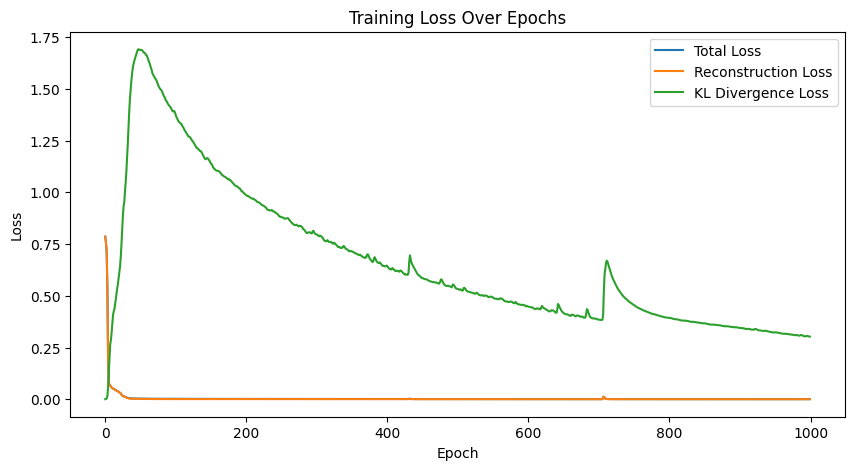

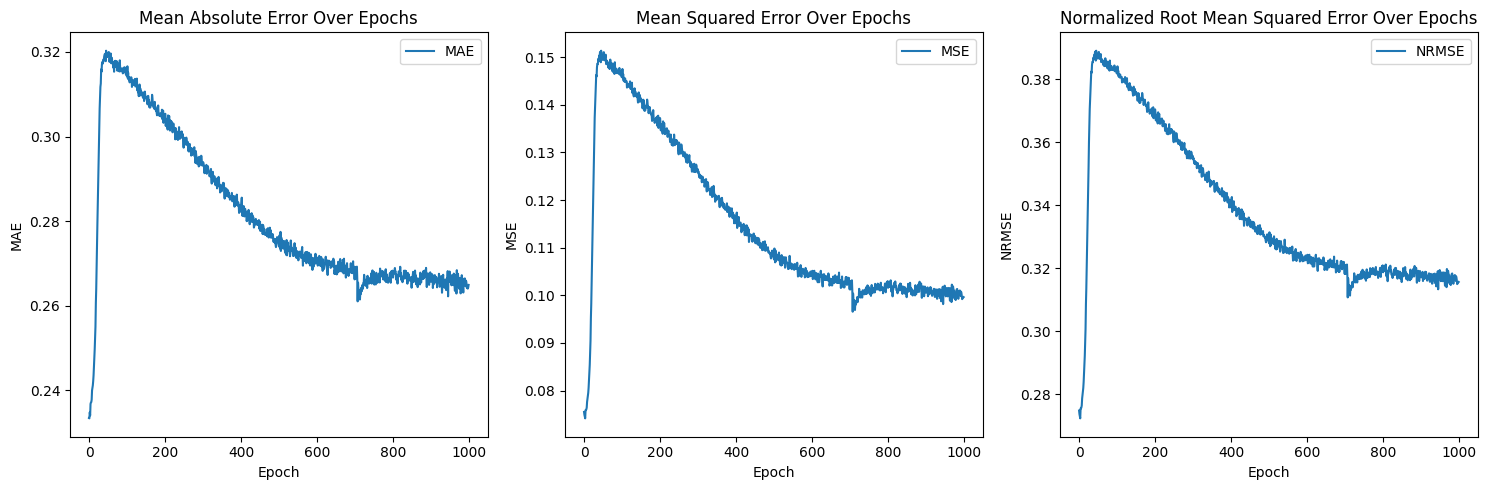

In [21]:
# Cell 4 (modified)
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        total_loss = reconstruction_loss + total_kl_loss
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, reconstruction_loss, kl_loss

batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices(combined_data).shuffle(10000).batch(batch_size)

epochs = 1000
early_stopping_patience = 1000
min_delta = 0.0001
best_loss = float('inf')
patience_counter = 0

total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
mae_history = []
mse_history = []
nrmse_history = []

for epoch in range(epochs):
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = len(train_dataset)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataset:
            total_loss_batch, reconstruction_loss, kl_loss = train_step(vae, batch, optimizer)
            total_loss += total_loss_batch
            reconstruction_loss_sum += reconstruction_loss
            kl_loss_sum += kl_loss
            pbar.update(1)
            pbar.set_postfix({'Total Loss': float(total_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    avg_total_loss = total_loss / num_batches
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    total_loss_history.append(avg_total_loss)
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate MAE, MSE, NRMSE
    augmented_data = vae.decode(tf.random.normal(shape=(combined_data.shape[0], latent_dim))).numpy()
    mae = mean_absolute_error(combined_data[:, :2], augmented_data[:, :2])
    mse = mean_squared_error(combined_data[:, :2], augmented_data[:, :2])
    rmse = np.sqrt(mse)
    nrmse = rmse / (combined_data[:, :2].max() - combined_data[:, :2].min())

    mae_history.append(mae)
    mse_history.append(mse)
    nrmse_history.append(nrmse)

    print(f"Epoch {epoch+1}: Total Loss = {avg_total_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"MAE = {mae:.6f}, MSE = {mse:.6f}, NRMSE = {nrmse:.6f}")

    if avg_total_loss < best_loss - min_delta:
        best_loss = avg_total_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Final output of metrics
print(f"Final MAE: {mae_history[-1]:.6f}")
print(f"Final MSE: {mse_history[-1]:.6f}")
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(total_loss_history, label='Total Loss')
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot MAE, MSE, and NRMSE history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(mae_history, label='MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(mse_history, label='MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

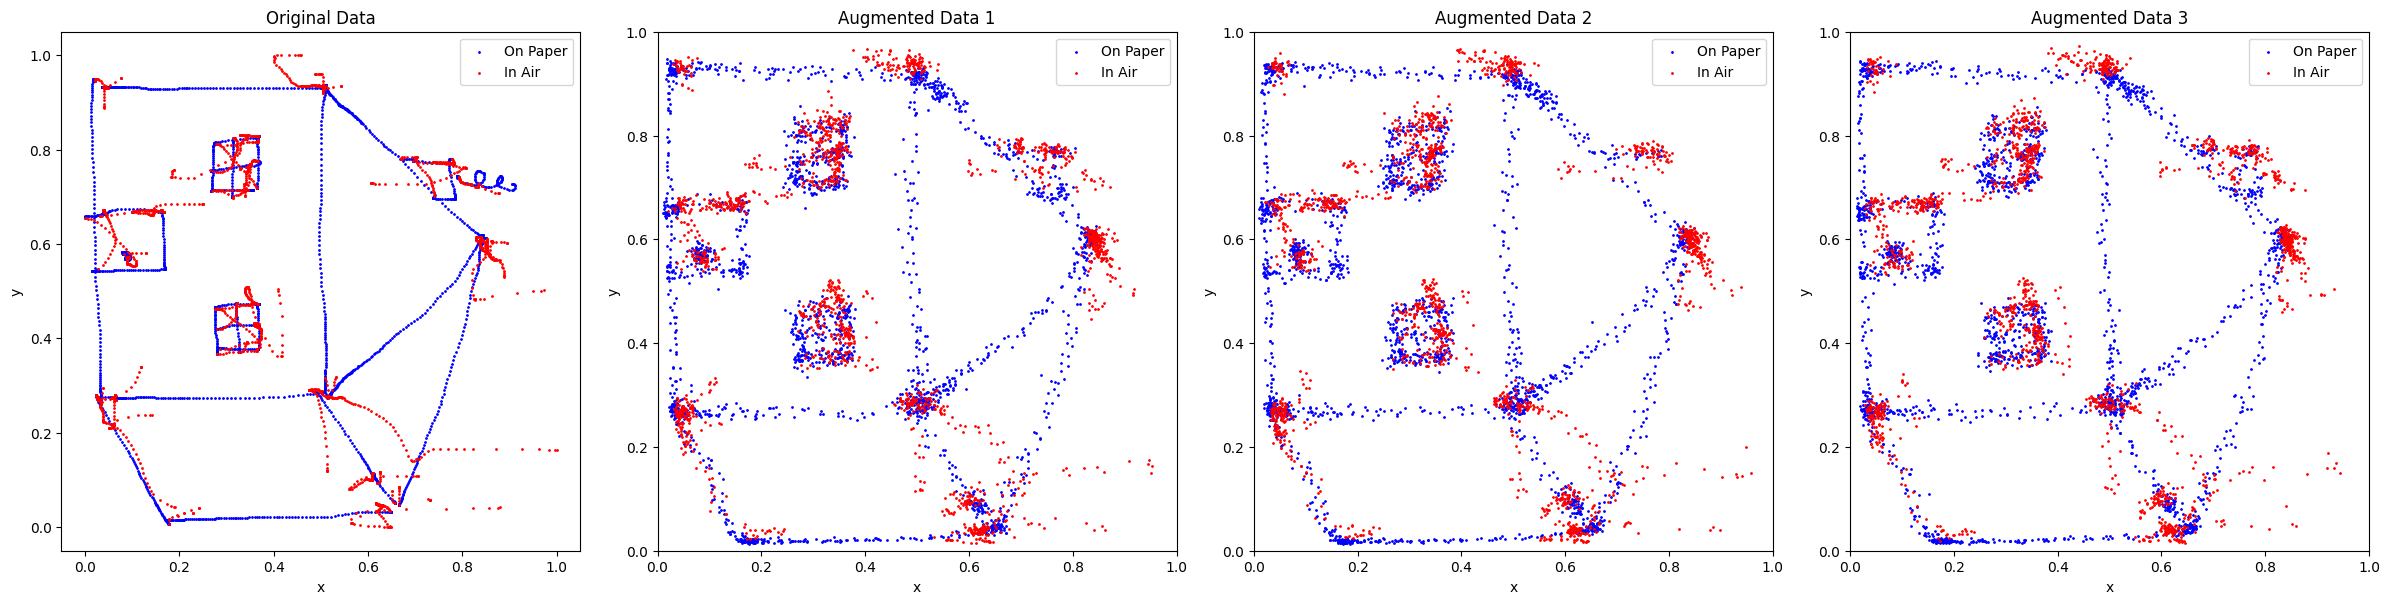

In [22]:
# Cell 5
def generate_augmented_data(model, num_augmented_files, avg_data_points, variability=0.1):
    augmented_datasets = []
    
    for _ in range(num_augmented_files):
        mean, logvar = model.encode(tf.convert_to_tensor(combined_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar)
        augmented_data = model.decode(z).numpy()

        # Determine the number of data points for this augmented dataset
        num_points = int(avg_data_points * (1 + variability * (random.random() - 0.5) * 2))
        
        # Truncate or pad the augmented data to match the number of points
        if num_points < augmented_data.shape[0]:
            augmented_data = augmented_data[:num_points]
        else:
            padding = np.zeros((num_points - augmented_data.shape[0], augmented_data.shape[1]))
            augmented_data = np.vstack([augmented_data, padding])

        # Post-process pen status
        augmented_data[:, 2] = post_process_pen_status(augmented_data[:, 2])
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

num_augmented_files = 3
augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points)

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(6*(num_augmented_files + 1), 6))
original_on_paper = combined_data[combined_data[:, 2] == 1]
original_in_air = combined_data[combined_data[:, 2] == 0]
axs[0].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
axs[0].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
axs[0].set_title('Original Data')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')
axs[0].legend()

# Set consistent axis limits for square aspect ratio
x_min, x_max = combined_data[:, 0].min(), combined_data[:, 0].max()
y_min, y_max = combined_data[:, 1].min(), combined_data[:, 1].max()

for i, augmented_data in enumerate(augmented_datasets):
    augmented_on_paper = augmented_data[augmented_data[:, 2] == 1]
    augmented_in_air = augmented_data[augmented_data[:, 2] == 0]
    axs[i+1].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i+1].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i+1].set_title(f'Augmented Data {i+1}')
    axs[i+1].set_xlabel('x')
    axs[i+1].set_ylabel('y')
    axs[i+1].set_aspect('equal')
    axs[i+1].set_xlim(x_min, x_max)
    axs[i+1].set_ylim(y_min, y_max)
    axs[i+1].legend()

plt.tight_layout()
plt.show()


In [39]:
# Cell 6
# Updated function for downloading augmented data
def download_augmented_data(augmented_datasets, scalers, directory='augmented_data'):
    # Ensure the output directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Iterate over augmented datasets and corresponding scalers
    for i, (augmented_data, scaler) in enumerate(zip(augmented_datasets, scalers)):
        # Inverse transform the x and y coordinates
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :2]),  # Inverse scale x, y
            augmented_data[:, 2]  # Keep pen_status unchanged
        ))
        
        # # Round coordinates and ensure pen_status is binary
        # augmented_data_original_scale[:, :2] = np.round(augmented_data_original_scale[:, :2])
        # augmented_data_original_scale[:, 2] = np.round(augmented_data_original_scale[:, 2]).astype(int)
        
        # Save each augmented dataset to a CSV file
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

# Call the updated function with your augmented datasets
download_augmented_data(augmented_datasets, scalers[:len(augmented_datasets)])


Saved augmented_data\augmented_data_1.csv
